In [ ]:
!git clone https://github.com/evgerritz/calligraphy_data.git

Cloning into 'calligraphy_data'...
remote: Enumerating objects: 105091, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 105091 (delta 1), reused 43 (delta 1), pack-reused 105048
Receiving objects: 100% (105091/105091), 167.90 MiB | 14.14 MiB/s, done.
Resolving deltas: 100% (502/502), done.
Updating files: 100% (105081/105081), done.


In [ ]:
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 34.5 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 7.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-n

In [ ]:
import pickle
from google.colab import files
import os
import torch
import numpy as np
from glob import glob
from PIL import Image
from datasets import Dataset, load_metric, load_dataset
import transformers
from transformers import AutoImageProcessor, ViTImageProcessor, Trainer, TrainingArguments, TrainerCallback, \
    ResNetForImageClassification, ViTForImageClassification, SwinForImageClassification, PvtForImageClassification, CvtForImageClassification, PoolFormerForImageClassification, ConvNextV2ForImageClassification
from sklearn.metrics import normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import rcParams
from torchvision import transforms
import shutil

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

try:
    os.mkdir('data')
except FileExistsError:
    pass

try:
    os.mkdir('Trainers')
except FileExistsError:
    pass

In [ ]:
# Test browser download
with open('test.pkl','wb') as f:
  pickle.dump([1,2,3],f)
files.download('test.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Calligraphy Dataset

In [ ]:
class AugmentedDataset:
    def __init__(self, name, abbrev, train, test, unseen, unseen_test, unseen_names, unseen_labs, test_labels, train_labels, unseen_test_labels, class_names):
        self.name = name
        self.abbrev = abbrev
        self.train = train
        self.test = test
        self.unseen = unseen
        self.unseen_test = unseen_test
        self.unseen_names = unseen_names

        self.unseen_labels = unseen_labs
        self.test_labels = test_labels
        self.train_labels = train_labels
        self.unseen_test_labels = unseen_test_labels
        self.class_names = class_names

In [ ]:
### SEEN CLASSES
np.random.seed(42)
#1) grab all img paths
num_classes = 15
max_n_train, max_n_test = 9100, 2500
train_IDs = np.random.choice(glob(f'calligraphy_data/train_{num_classes}/*/*.jpg'), max_n_train, False)
print('Example train_id:',train_IDs[0])
test_IDs = np.random.choice(glob(f'calligraphy_data/test_{num_classes}/*/*.jpg'), max_n_test, False)
# partition = {'train':train_IDs, 'validation':test_IDs}
print(len(train_IDs),len(test_IDs))

class_names = sorted(set([tid.split('/')[2] for tid in test_IDs]))
class_name_to_ix = {cname:ci for ci,cname in enumerate(class_names)}
ix_to_class_name = {ci:cname for ci,cname in enumerate(class_names)}
print(class_name_to_ix)

# assign numeric label to each training and test sample
train_labels = [class_name_to_ix[tid.split('/')[2]] for tid in train_IDs]
test_labels = [class_name_to_ix[tid.split('/')[2]] for tid in test_IDs]

Example train_id: calligraphy_data/train_15/gj/4811.jpg
9100 2500
{'bdsr': 0, 'fwq': 1, 'gj': 2, 'htj': 3, 'lgq': 4, 'lqs': 5, 'lx': 6, 'mzd': 7, 'oyx': 8, 'sgt': 9, 'smh': 10, 'wxz': 11, 'yyr': 12, 'yzq': 13, 'zmf': 14}


In [ ]:
### UNSEEN CLASSES
all_classes = os.listdir('calligraphy_data/train_20')
unseen_names = sorted(set(all_classes).difference(class_names))
unseen_name_to_ix = {cname:ci for ci,cname in enumerate(unseen_names)}
ix_to_unseen_name = {ci:cname for ci,cname in enumerate(unseen_names)}
print(unseen_names)
max_n_per_unseen = 500
max_test_n_per_unseen = 360
unseen_IDs = []
unseen_labels = []
unseen_test_IDs = []
unseen_test_labels = []

for i,uc in enumerate(unseen_names):
  ids = glob(f'calligraphy_data/train_20/{uc}/*.jpg')
  train_ids = ids[:max_n_per_unseen]
  test_ids = ids[max_n_per_unseen:max_n_per_unseen + max_test_n_per_unseen]
  unseen_IDs += train_ids
  unseen_labels += [i]*len(train_ids)
  unseen_test_IDs += test_ids
  unseen_test_labels += [i]*len(test_ids)
len(unseen_labels), len(unseen_test_IDs)

['csl', 'hy', 'mf', 'shz', 'wzm']


(2500, 1800)

In [ ]:
def train_gen():
  for i,img_path in enumerate(train_IDs):
    yield {'image':Image.open(img_path), 'labels':train_labels[i]}

def test_gen():
  for i,img_path in enumerate(test_IDs):
    yield {'image':Image.open(img_path), 'labels':test_labels[i]}

def unseen_gen():
  for i,img_path in enumerate(unseen_IDs):
    yield {'image':Image.open(img_path), 'labels':unseen_labels[i]}

def unseen_test_gen():
  for i,img_path in enumerate(unseen_test_IDs):
    yield {'image':Image.open(img_path), 'labels':unseen_labels[i]}


#https://stackoverflow.com/questions/76001128/splitting-dataset-into-train-test-and-validation-using-huggingface-datasets-fun
ds_train = Dataset.from_generator(train_gen)
ds_test = Dataset.from_generator(test_gen)
ds_unseen = Dataset.from_generator(unseen_gen)
ds_unseen_test = Dataset.from_generator(unseen_test_gen)

ds_train.shape, ds_test.shape, ds_unseen.shape, ds_unseen_test.shape

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

((9100, 2), (2500, 2), (2500, 2), (1800, 2))

Cifar-100

In [ ]:
ds_train_cf, ds_test_cf = load_dataset('cifar100', split=['train[:50000]', 'test[:10000]'])
ds_train_cf = ds_train_cf.rename_column("fine_label", "labels")
ds_test_cf = ds_test_cf.rename_column("fine_label", "labels")
ds_train_cf = ds_train_cf.rename_column("img", "image")
ds_test_cf = ds_test_cf.rename_column("img", "image")

id2label_cf = {id:label for id, label in enumerate(ds_train_cf.features['labels'].names)}
label2id_cf = {label:id for id,label in id2label_cf.items()}

unseen_names_cf = ['orchid', 'poppy', 'rose', 'sunflower', 'tulip']
unseen_ids_cf = [label2id_cf[x] for x in unseen_names_cf]

ds_unseen_cf = ds_train_cf.filter(lambda x: x['labels'] in unseen_ids_cf)
ds_unseen_test_cf = ds_train_cf.filter(lambda x: x['labels'] in unseen_ids_cf).train_test_split(train_size=max_test_n_per_unseen*len(unseen_names_cf))['train']
ds_train_cf = ds_train_cf.filter(lambda x: x['labels'] not in unseen_ids_cf and x['labels'] < 20)
ds_test_cf = ds_test_cf.filter(lambda x: x['labels'] not in unseen_ids_cf and x['labels'] < 20)
print(ds_train_cf.shape, ds_test_cf.shape, ds_unseen_cf.shape, ds_unseen_test_cf.shape)

class_names_cf = [name for name in ds_train_cf.features['labels'].names if name not in unseen_names_cf]

old_indices = list(np.unique(ds_train_cf['labels']))
def new_class_index(x):
    x['labels'] = int(old_indices.index(x['labels']))
    return x
ds_train_cf = ds_train_cf.map(new_class_index)
ds_test_cf = ds_test_cf.map(new_class_index)

unseen_labels_cf = ds_unseen_cf['labels']
unseen_test_labels_cf = ds_unseen_test_cf['labels']
test_labels_cf = ds_test_cf['labels']
train_labels_cf = ds_train_cf['labels']

ds_train_cf.shape, ds_test_cf.shape, ds_unseen_cf.shape, ds_unseen_test_cf.shape, len(unseen_labels_cf), len(unseen_test_labels_cf)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/50000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

(10000, 3) (2000, 3) (2500, 3) (1800, 3)


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

((10000, 3), (2000, 3), (2500, 3), (1800, 3), 2500, 1800)

In [ ]:
callig = AugmentedDataset('Calligraphy', 'callig', ds_train, ds_test, ds_unseen, ds_unseen_test, unseen_names, unseen_labels, test_labels, train_labels, unseen_test_labels, class_names)
cifar = AugmentedDataset('CIFAR-100', 'cifar', ds_train_cf, ds_test_cf, ds_unseen_cf, ds_unseen_test_cf, unseen_names_cf, unseen_labels_cf, test_labels_cf, train_labels_cf, unseen_test_labels_cf, class_names_cf)

Fine-tuning

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }


metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-11-0e65dc52cfbe>:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
class FTModel:
    def __init__(self, data, model_name_or_path, nickname, nhs, processor_class, basemodel, model_type, n_batches=4, batch_size=72):
        self.modelname = nickname
        self.data = data
        self.processor = processor_class.from_pretrained(model_name_or_path)
        self.datadir = 'data/' + self.modelname + self.data.name
        self.nhs = nhs
        self.model_type = model_type
        self.plot = True
        self.calc_seen_nmi = True
        try:
            os.mkdir(self.datadir)
        except FileExistsError:
            pass

        size_key = 'height' if 'height' in self.processor.size else 'shortest_edge'
        size = self.processor.size[size_key]

        image_mean = self.processor.image_mean
        image_std = self.processor.image_std

        my_transforms = transforms.Compose([
            transforms.Resize(size),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(mean=image_mean, std=image_std),
        ])

        def transform(example_batch):
            inputs = {}
            inputs['pixel_values'] = [my_transforms(image) for image in example_batch['image']]

            # Don't forget to include the labels!
            inputs['labels'] = example_batch['labels']
            return inputs

        self.prepared_ds_train = data.train.with_transform(transform)
        self.prepared_ds_test = data.test.with_transform(transform)
        self.prepared_ds_unseen = data.unseen.with_transform(transform)
        self.prepared_ds_unseen_test = data.unseen_test.with_transform(transform)
        self.data_class_names = data.class_names

        self.model = basemodel.from_pretrained(
            model_name_or_path,
            num_labels=len(self.data_class_names),
            id2label={str(i): c for i, c in enumerate(self.data_class_names)},
            label2id={c: str(i) for i, c in enumerate(self.data_class_names)},
            ignore_mismatched_sizes = True,
        )
        self.model = self.model.to(device)

        self.BATCH_SIZE = batch_size
        self.training_args = TrainingArguments(
            output_dir=f"./Trainers/{self.modelname}_{self.data.abbrev}Trainer",
            per_device_train_batch_size=self.BATCH_SIZE,
            evaluation_strategy="steps",
            num_train_epochs=n_batches,
            fp16=True if torch.cuda.is_available() else False,
            save_steps=100,
            eval_steps=100,
            logging_steps=10,
            learning_rate=2e-4,
            save_total_limit=2,
            remove_unused_columns=False,
            push_to_hub=False,
            report_to='tensorboard',
            load_best_model_at_end=True,
        )

        self.trainer = Trainer(
            model=self.model,
            args=self.training_args,
            data_collator=collate_fn,
            compute_metrics=compute_metrics,
            train_dataset=self.prepared_ds_train,
            eval_dataset=self.prepared_ds_test,
            tokenizer=self.processor,
        )

    def get_embed_pkl_fname(self, step, unseen_str, trial_no=0):
        return f'{self.datadir}/saved_embeds_step{step if step is not None else ""}_{unseen_str}_{trial_no}.pkl'

    def get_embed_plot_fname(self, step, unseen_str):
        return f'{self.datadir}/{step}_{unseen_str}.pdf'

    def get_dir(self):
        return f'{self.datadir}/'

def newResNet(data=callig, **kwargs):
    return FTModel(
        model_name_or_path = 'microsoft/resnet-152', # ImageNet 1-k
        data = data,
        nickname = 'ResNet',
        nhs = 5,
        processor_class = AutoImageProcessor,
        basemodel = ResNetForImageClassification,
        model_type = 'CNN',
        **kwargs
    )

def newViT(data=callig, **kwargs):
    return FTModel(
        model_name_or_path = 'google/vit-base-patch16-224-in21k', # ImageNet-21k BAD
        data = data,
        nickname = 'ViT',
        nhs = 13,
        processor_class = ViTImageProcessor,
        basemodel = ViTForImageClassification,
        model_type = 'Transformer',
        **kwargs,
    )

def newSwin(data=callig, **kwargs):
    return FTModel(
        model_name_or_path = 'microsoft/swin-tiny-patch4-window7-224', # ImageNet 1-k
        data = data,
        nickname = 'Swin',
        nhs = 5,
        processor_class = AutoImageProcessor,
        basemodel = SwinForImageClassification,
        model_type = 'Transformer',
        **kwargs
    )

def newPViT(data=callig, **kwargs):
    return FTModel(
        model_name_or_path = 'Zetatech/pvt-tiny-224', # ImageNet 1-k
        data = data,
        nickname = 'PViT',
        nhs = 9,
        processor_class = AutoImageProcessor,
        basemodel = PvtForImageClassification,
        model_type = 'Transformer',
    )

def newCvT(data=callig):
    return FTModel(
        model_name_or_path = 'microsoft/cvt-21', # ImageNet 1-k
        data = data,
        nickname = 'CvT',
        nhs = 3,
        processor_class = AutoImageProcessor,
        basemodel = CvtForImageClassification,
        model_type = 'CNN',
    )

def newPoolFormer(data=callig):
    return FTModel(
        model_name_or_path = 'sail/poolformer_s12', # ImageNet 1-k
        data = data,
        nickname = 'PoolFormer',
        nhs = 4,
        processor_class = AutoImageProcessor,
        basemodel = PoolFormerForImageClassification,
        model_type = 'CNN',
    )

def newConvNeXtV2(data=callig):
    return FTModel(
        model_name_or_path = "facebook/convnextv2-tiny-1k-224", # ImageNet 1-k
        data = data,
        nickname = 'ConvNeXtV2',
        nhs = 5,
        processor_class = AutoImageProcessor,
        basemodel = ConvNextV2ForImageClassification,
        model_type = 'CNN',
    )

In [ ]:
def initial_eval(ftmodel):
    metrics = ftmodel.trainer.evaluate(ftmodel.prepared_ds_test)
    ftmodel.trainer.log_metrics("eval", metrics)
    ftmodel.trainer.save_metrics("eval", metrics)

def retrieveAllSparseNbrs(A):
    assert A.shape[0] == len(A.indptr)-1
    for i in range(A.shape[0]):
        iptr0, iptr1 = A.indptr[i:i+2]
        yield A.indices[iptr0:iptr1]

def get_intermediate_embed(ftmodel, which_ds, batch_size, embed_type):
    data = ftmodel.data
    n = len(which_ds)
    n_batches = int(np.ceil(n/batch_size))

    embed = {}

    for bi in range(n_batches):
      print(bi,end=' ')

      inputs = torch.stack(which_ds[bi*batch_size:(bi+1)*batch_size]['pixel_values'])
      inputs = inputs.to(device)
      with torch.no_grad():
        outputs = ftmodel.model(inputs, output_hidden_states=True)
      inputs.to('cpu')
      for li in range(len(outputs['hidden_states'])):
        normed_hidden_state = outputs.hidden_states[li].detach().cpu().numpy()
        if ftmodel.model_type == 'CNN':
            if bi > 0:
                if 'e0' == embed_type:
                    embed[li] = np.concatenate((embed[li],normed_hidden_state.reshape(normed_hidden_state.shape[0],-1)))
                elif 'mean' == embed_type:
                    embed[li] = np.concatenate((embed[li],normed_hidden_state.mean((2,3))))
            else:
                if 'e0' == embed_type:
                    embed[li] = normed_hidden_state.reshape(normed_hidden_state.shape[0],-1)
                elif 'mean' == embed_type:
                    embed[li] = normed_hidden_state.mean((2,3))
        else:
            if bi > 0:
                if 'e0' == embed_type:
                    embed[li] = np.concatenate((embed[li],normed_hidden_state[:,0]))
                elif 'mean' == embed_type:
                    embed[li] = np.concatenate((embed[li],normed_hidden_state.mean(1)))
            else:
                if 'e0' == embed_type:
                    embed[li] = normed_hidden_state[:,0]
                elif 'mean' == embed_type:
                    embed[li] = normed_hidden_state.mean(1)
    return embed

metric_names = ['NMI', 'NNk1', 'NNk500', 'lin_probe_acc']

def compute_g_metrics(ftmodel, which_ds, which_ds_train, which_classes, which_labels, train_labels, lis, modelname, batch_size, step=None, plot=False, unseen=True):
    global trial_no
    unseen_str = f'{"unseen" if unseen else "seen"}'

    print()
    print(trial_no)
    pca = PCA(2)
    knn = NearestNeighbors(algorithm='auto', n_jobs=-1, n_neighbors=max_n_per_unseen) #k = 500)
    km = KMeans(n_clusters=len(which_classes), random_state=42, n_init="auto")

    embed_type = 'mean' if ftmodel.model_type == 'CNN' else 'e0'
    embed = get_intermediate_embed(ftmodel, which_ds, batch_size, embed_type)
    train_subset_indices = np.random.choice(len(which_ds_train), size = len(which_ds_train)//4, replace=False)
    train_subset = which_ds_train.shuffle().select(indices=train_subset_indices)
    train_subset_labels = [x['labels'] for x in train_subset]
    probe_train_embed = get_intermediate_embed(ftmodel, train_subset, batch_size, embed_type)

    # metrics is a dictionary mapping metric types to their results across layer indices
    metrics = {m: [] for m in metric_names}

    if plot:
      f, axes = plt.subplots(len(lis),figsize=(4,len(lis)*4))
    for i,li in enumerate(lis):
        x = embed[li]
        x_train = probe_train_embed[li]

        ### COMPUTE K-MEANS
        km.fit(x)
        metrics['NMI'].append(normalized_mutual_info_score(which_labels,km.labels_))

        ### COMPUTE NNs
        knn.fit(x)
        X_NN_graph = knn.kneighbors_graph()
        NN_idxs = np.array(list(retrieveAllSparseNbrs(X_NN_graph)))
        ylabels = np.asarray(which_labels)

        NN_labels = ylabels[NN_idxs]
        pct_k1_same_class = (ylabels == NN_labels[:,0]).sum()/len(ylabels)
        metrics['NNk1'].append(pct_k1_same_class)
        pct_k500_same_class = np.mean((ylabels[:,None] == NN_labels).sum(1)/max_n_per_unseen)
        metrics['NNk500'].append(pct_k500_same_class)

        ### Compute classif acc
        linclass = SGDClassifier(loss='hinge', penalty='l2')
        linclass.fit(x_train, train_subset_labels)
        yhat = linclass.predict(x)
        metrics['lin_probe_acc'].append(np.mean(yhat == which_labels))

        titl = f"L{li}: "
        for metric_name in metric_names:
            titl += f"{metric_name}={metrics[metric_name][i]:.2f} "
        print(f'\n{unseen_str.upper()} step {step}: {titl}', end='')
        if plot:
            y = pca.fit_transform(x) #run pca for plotting
            with plt.style.context('seaborn-v0_8-paper'):
                ax = axes[i]
                ax.scatter(*y.T, c=which_labels, s=8, cmap='Paired', alpha=.75, label=unseen_str)

                ax.set_title(titl,size=7)
                ax.legend()

    if plot:
      f.suptitle(unseen_str)
      plt.savefig(ftmodel.get_embed_plot_fname(step, unseen_str), transparent=True, bbox_inches='tight')
      plt.close()
      #plt.show()

    pklfname = ftmodel.get_embed_pkl_fname(step, unseen_str, trial_no)
    with open(pklfname,'wb') as f:
      pickle.dump(metrics,f)

class CustomCallback(TrainerCallback):
    def __init__(self, ftmodel) -> None:
        super().__init__()
        self.ftmodel = ftmodel
        self._trainer = ftmodel.trainer

        self.batch_size = ftmodel.BATCH_SIZE
        self.lis = range(ftmodel.nhs)
        self.modelname = ftmodel.modelname

    def seen_and_unseen_metrics(self, global_step):
        data = self.ftmodel.data
        compute_g_metrics(self.ftmodel, self.ftmodel.prepared_ds_unseen_test,
                        self.ftmodel.prepared_ds_unseen,
                        data.unseen_names, data.unseen_test_labels, data.unseen_labels, self.lis,
                        self.modelname, self.batch_size,
                        step=global_step, plot=self.ftmodel.plot)

        if self.ftmodel.calc_seen_nmi:
            compute_g_metrics(self.ftmodel, self.ftmodel.prepared_ds_test, self.ftmodel.prepared_ds_train, self.ftmodel.data_class_names, data.test_labels, data.train_labels,
                         self.lis, self.modelname, self.batch_size, step=global_step, plot=self.ftmodel.plot, unseen=False)

    def on_evaluate(self, args, state, control, **kwargs):
        global_step = self._trainer.state.global_step
        self.seen_and_unseen_metrics(global_step)

    def on_epoch_begin(self, args, state, control, **kwargs):
        global_step = self._trainer.state.global_step
        self.seen_and_unseen_metrics(global_step)

def train_and_save(ftmodel):
    ftmodel.trainer.add_callback(CustomCallback(ftmodel))
    train_results = ftmodel.trainer.train()
    ftmodel.trainer.save_model()
    ftmodel.trainer.log_metrics("train", train_results.metrics)
    ftmodel.trainer.save_metrics("train", train_results.metrics)
    ftmodel.trainer.save_state()
    return train_results


def aggregate_trials(ftmodel, trials, steps):
    results = {}
    n_trials = len(trials)

    # for each metric, produce an n_trials x num_lis matrix
    for metric in metric_names:
        results[metric] = []
        for step in steps:
            results[metric].append(np.zeros((n_trials, ftmodel.nhs)))

    print(len(results['NMI']))
    for step_i, step in enumerate(steps):
        for trial_no in range(n_trials):
            with open(ftmodel.get_embed_pkl_fname(step, 'unseen', trial_no),'rb') as f:
                data = pickle.load(f)
                for metric in metric_names:
                    #print(metric, step, trial_no)
                    results[metric][step_i][trial_no] = data[metric]

    with open(ftmodel.get_embed_pkl_fname(step, 'unseen', 'all'), 'wb') as result_f:
        pickle.dump(results, result_f)

    return results

def plot_NMI_across_layers(ftmodel, trials):
    steps = [0,100,200,300,400,500]
    emb_results = aggregate_trials(ftmodel, trials, steps)

    for metric in metric_names:
        for step_i, step in enumerate(steps):
            mean_vals = emb_results[metric][step_i].mean(axis=0)
            stds = emb_results[metric][step_i].std(axis=0)
            plt.errorbar(list(range(ftmodel.nhs)), mean_vals, yerr=stds, label=f'{step=}')
        plt.ylabel(metric)
        plt.xlabel('Layer')
        plt.title(f'{ftmodel.modelname} on {ftmodel.data.name}')
        plt.legend()
        plt.savefig(ftmodel.get_dir() + f'g_across_layers_{metric}.png', transparent=True, bbox_inches='tight')
        plt.show()

Train

In [ ]:
# [ResNet, ViT, Swin, PViT, CvT, PoolFormer, ConvNeXtV2]
trial_no = 0
def run_trials(model_gen, dataset, n_trials):
    global trial_no
    trial_no = 0
    np.random.seed(42)
    seeds = np.random.randint(np.iinfo(np.uint32).max, size=n_trials)
    for i, seed in enumerate(seeds):
        trial_no = i
        transformers.set_seed(seed)
        model = model_gen(dataset)
        train_and_save(model)
    trials = list(range(n_trials))
    plot_NMI_across_layers(model, trials)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 0: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 0: L1: NMI=0.08 NNk1=0.56 NNk500=0.28 lin_probe_acc=0.39 
UNSEEN step 0: L2: NMI=0.43 NNk1=0.76 NNk500=0.42 lin_probe_acc=0.48 
UNSEEN step 0: L3: NMI=0.54 NNk1=0.86 NNk500=0.48 lin_probe_acc=0.66 
UNSEEN step 0: L4: NMI=0.64 NNk1=0.87 NNk500=0.49 lin_probe_acc=0.88 
UNSEEN step 0: L5: NMI=0.57 NNk1=0.88 NNk500=0.50 lin_probe_acc=0.94 
UNSEEN step 0: L6: NMI=0.57 NNk1=0.88 NNk500=0.48 lin_probe_acc=0.81 
UNSEEN step 0: L7: NMI=0.56 NNk1=0.90 NNk500=0.48 lin_probe_acc=0.91 
UNSEEN step 0: L8: NMI=0.54 NNk1=0.88 NNk500=0.46 lin_probe_acc=0.89 
UNSEEN step 0: L9: NMI=0.54 NNk1=0.87 NNk500=0.45 lin_probe_acc=0.89 
UNSEEN step 0: L10: NMI=0.47 NNk1=0.84 NNk500=0.42 lin_probe_acc=0.90 
UNSEEN step 0: L11: NMI=0.41 NNk1=0.82 NNk500=0.38 lin_probe_acc=0.95 
UNSEEN step 0: L12: NMI=0.35 NNk1=0.76 NNk500=0.33 lin_probe_acc=0.93 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 3

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 0: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 0: L1: NMI=0.27 NNk1=0.45 NNk500=0.17 lin_probe_acc=0.37 
SEEN step 0: L2: NMI=0.38 NNk1=0.65 NNk500=0.21 lin_probe_acc=0.61 
SEEN step 0: L3: NMI=0.47 NNk1=0.76 NNk500=0.23 lin_probe_acc=0.62 
SEEN step 0: L4: NMI=0.57 NNk1=0.81 NNk500=0.25 lin_probe_acc=0.74 
SEEN step 0: L5: NMI=0.62 NNk1=0.83 NNk500=0.25 lin_probe_acc=0.82 
SEEN step 0: L6: NMI=0.58 NNk1=0.82 NNk500=0.25 lin_probe_acc=0.89 
SEEN step 0: L7: NMI=0.60 NNk1=0.80 NNk500=0.24 lin_probe_acc=0.87 
SEEN step 0: L8: NMI=0.49 NNk1=0.79 NNk500=0.23 lin_probe_acc=0.92 
SEEN step 0: L9: NMI=0.47 NNk1=0.77 NNk500=0.22 lin_probe_acc=0.91 
SEEN step 0: L10: NMI=0.37 NNk1=0.74 NNk500=0.20 lin_probe_acc=0.87 
SEEN step 0: L11: NMI=0.32 NNk1=0.69 NNk500=0.18 lin_probe_acc=0.89 
SEEN step 0: L12: NMI=0.20 NNk1=0.58 NNk500=0.16 lin_probe_acc=0.90 


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 100: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 100: L1: NMI=0.28 NNk1=0.64 NNk500=0.36 lin_probe_acc=0.50 
UNSEEN step 100: L2: NMI=0.43 NNk1=0.75 NNk500=0.43 lin_probe_acc=0.62 
UNSEEN step 100: L3: NMI=0.63 NNk1=0.90 NNk500=0.52 lin_probe_acc=0.65 
UNSEEN step 100: L4: NMI=0.68 NNk1=0.92 NNk500=0.54 lin_probe_acc=0.87 
UNSEEN step 100: L5: NMI=0.60 NNk1=0.92 NNk500=0.54 lin_probe_acc=0.96 
UNSEEN step 100: L6: NMI=0.67 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.95 
UNSEEN step 100: L7: NMI=0.63 NNk1=0.92 NNk500=0.54 lin_probe_acc=0.96 
UNSEEN step 100: L8: NMI=0.67 NNk1=0.92 NNk500=0.54 lin_probe_acc=0.94 
UNSEEN step 100: L9: NMI=0.64 NNk1=0.92 NNk500=0.54 lin_probe_acc=0.93 
UNSEEN step 100: L10: NMI=0.66 NNk1=0.92 NNk500=0.53 lin_probe_acc=0.88 
UNSEEN step 100: L11: NMI=0.59 NNk1=0.93 NNk500=0.52 lin_probe_acc=0.97 
UNSEEN step 100: L12: NMI=0.50 NNk1=0.91 NNk500=0.48 lin_probe_acc=0.96 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 100: L0: NMI=0.00 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 100: L1: NMI=0.33 NNk1=0.46 NNk500=0.19 lin_probe_acc=0.31 
SEEN step 100: L2: NMI=0.38 NNk1=0.64 NNk500=0.22 lin_probe_acc=0.47 
SEEN step 100: L3: NMI=0.57 NNk1=0.81 NNk500=0.26 lin_probe_acc=0.77 
SEEN step 100: L4: NMI=0.72 NNk1=0.89 NNk500=0.31 lin_probe_acc=0.92 
SEEN step 100: L5: NMI=0.73 NNk1=0.91 NNk500=0.33 lin_probe_acc=0.94 
SEEN step 100: L6: NMI=0.82 NNk1=0.93 NNk500=0.34 lin_probe_acc=0.93 
SEEN step 100: L7: NMI=0.83 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.88 
SEEN step 100: L8: NMI=0.82 NNk1=0.94 NNk500=0.35 lin_probe_acc=0.92 
SEEN step 100: L9: NMI=0.83 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.95 
SEEN step 100: L10: NMI=0.86 NNk1=0.96 NNk500=0.36 lin_probe_acc=0.95 
SEEN step 100: L11: NMI=0.89 NNk1=0.97 NNk500=0.37 lin_probe_acc=0.97 
SEEN step 100: L12: NMI=0.91 NNk1=0.96 NNk500=0.38 lin_probe_acc=0.97 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 127: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 127: L1: NMI=0.27 NNk1=0.63 NNk500=0.36 lin_probe_acc=0.41 
UNSEEN step 127: L2: NMI=0.44 NNk1=0.76 NNk500=0.43 lin_probe_acc=0.82 
UNSEEN step 127: L3: NMI=0.64 NNk1=0.90 NNk500=0.52 lin_probe_acc=0.81 
UNSEEN step 127: L4: NMI=0.63 NNk1=0.91 NNk500=0.54 lin_probe_acc=0.87 
UNSEEN step 127: L5: NMI=0.64 NNk1=0.92 NNk500=0.54 lin_probe_acc=0.95 
UNSEEN step 127: L6: NMI=0.64 NNk1=0.92 NNk500=0.55 lin_probe_acc=0.89 
UNSEEN step 127: L7: NMI=0.64 NNk1=0.92 NNk500=0.55 lin_probe_acc=0.95 
UNSEEN step 127: L8: NMI=0.66 NNk1=0.92 NNk500=0.55 lin_probe_acc=0.94 
UNSEEN step 127: L9: NMI=0.66 NNk1=0.92 NNk500=0.55 lin_probe_acc=0.90 
UNSEEN step 127: L10: NMI=0.68 NNk1=0.94 NNk500=0.55 lin_probe_acc=0.94 
UNSEEN step 127: L11: NMI=0.61 NNk1=0.94 NNk500=0.55 lin_probe_acc=0.97 
UNSEEN step 127: L12: NMI=0.53 NNk1=0.91 NNk500=0.52 lin_probe_acc=0.94 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 127: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 127: L1: NMI=0.35 NNk1=0.45 NNk500=0.19 lin_probe_acc=0.36 
SEEN step 127: L2: NMI=0.38 NNk1=0.65 NNk500=0.22 lin_probe_acc=0.63 
SEEN step 127: L3: NMI=0.59 NNk1=0.82 NNk500=0.27 lin_probe_acc=0.61 
SEEN step 127: L4: NMI=0.71 NNk1=0.89 NNk500=0.31 lin_probe_acc=0.91 
SEEN step 127: L5: NMI=0.77 NNk1=0.92 NNk500=0.33 lin_probe_acc=0.90 
SEEN step 127: L6: NMI=0.80 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.93 
SEEN step 127: L7: NMI=0.83 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.94 
SEEN step 127: L8: NMI=0.83 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.95 
SEEN step 127: L9: NMI=0.83 NNk1=0.94 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 127: L10: NMI=0.87 NNk1=0.96 NNk500=0.36 lin_probe_acc=0.97 
SEEN step 127: L11: NMI=0.88 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.97 
SEEN step 127: L12: NMI=0.90 NNk1=0.97 NNk500=0.38 lin_probe_acc=0.97 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 200: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 200: L1: NMI=0.22 NNk1=0.61 NNk500=0.33 lin_probe_acc=0.34 
UNSEEN step 200: L2: NMI=0.38 NNk1=0.77 NNk500=0.42 lin_probe_acc=0.68 
UNSEEN step 200: L3: NMI=0.62 NNk1=0.90 NNk500=0.51 lin_probe_acc=0.87 
UNSEEN step 200: L4: NMI=0.63 NNk1=0.91 NNk500=0.53 lin_probe_acc=0.90 
UNSEEN step 200: L5: NMI=0.60 NNk1=0.92 NNk500=0.52 lin_probe_acc=0.94 
UNSEEN step 200: L6: NMI=0.58 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.93 
UNSEEN step 200: L7: NMI=0.60 NNk1=0.93 NNk500=0.53 lin_probe_acc=0.83 
UNSEEN step 200: L8: NMI=0.64 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.95 
UNSEEN step 200: L9: NMI=0.65 NNk1=0.93 NNk500=0.53 lin_probe_acc=0.90 
UNSEEN step 200: L10: NMI=0.70 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.94 
UNSEEN step 200: L11: NMI=0.58 NNk1=0.92 NNk500=0.54 lin_probe_acc=0.96 
UNSEEN step 200: L12: NMI=0.43 NNk1=0.89 NNk500=0.45 lin_probe_acc=0.95 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 200: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 200: L1: NMI=0.32 NNk1=0.44 NNk500=0.18 lin_probe_acc=0.31 
SEEN step 200: L2: NMI=0.38 NNk1=0.65 NNk500=0.22 lin_probe_acc=0.56 
SEEN step 200: L3: NMI=0.60 NNk1=0.83 NNk500=0.27 lin_probe_acc=0.79 
SEEN step 200: L4: NMI=0.68 NNk1=0.89 NNk500=0.30 lin_probe_acc=0.89 
SEEN step 200: L5: NMI=0.74 NNk1=0.93 NNk500=0.33 lin_probe_acc=0.94 
SEEN step 200: L6: NMI=0.78 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.96 
SEEN step 200: L7: NMI=0.81 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.96 
SEEN step 200: L8: NMI=0.81 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.95 
SEEN step 200: L9: NMI=0.81 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.93 
SEEN step 200: L10: NMI=0.87 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.97 
SEEN step 200: L11: NMI=0.90 NNk1=0.98 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 200: L12: NMI=0.92 NNk1=0.97 NNk500=0.38 lin_probe_acc=0.98 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 254: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 254: L1: NMI=0.26 NNk1=0.63 NNk500=0.35 lin_probe_acc=0.34 
UNSEEN step 254: L2: NMI=0.39 NNk1=0.77 NNk500=0.42 lin_probe_acc=0.48 
UNSEEN step 254: L3: NMI=0.60 NNk1=0.88 NNk500=0.51 lin_probe_acc=0.70 
UNSEEN step 254: L4: NMI=0.64 NNk1=0.90 NNk500=0.53 lin_probe_acc=0.94 
UNSEEN step 254: L5: NMI=0.60 NNk1=0.91 NNk500=0.52 lin_probe_acc=0.92 
UNSEEN step 254: L6: NMI=0.61 NNk1=0.92 NNk500=0.54 lin_probe_acc=0.95 
UNSEEN step 254: L7: NMI=0.66 NNk1=0.91 NNk500=0.54 lin_probe_acc=0.94 
UNSEEN step 254: L8: NMI=0.66 NNk1=0.91 NNk500=0.55 lin_probe_acc=0.93 
UNSEEN step 254: L9: NMI=0.67 NNk1=0.91 NNk500=0.55 lin_probe_acc=0.88 
UNSEEN step 254: L10: NMI=0.64 NNk1=0.92 NNk500=0.54 lin_probe_acc=0.90 
UNSEEN step 254: L11: NMI=0.60 NNk1=0.92 NNk500=0.52 lin_probe_acc=0.97 
UNSEEN step 254: L12: NMI=0.34 NNk1=0.89 NNk500=0.42 lin_probe_acc=0.94 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 254: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 254: L1: NMI=0.34 NNk1=0.45 NNk500=0.19 lin_probe_acc=0.35 
SEEN step 254: L2: NMI=0.38 NNk1=0.65 NNk500=0.21 lin_probe_acc=0.61 
SEEN step 254: L3: NMI=0.62 NNk1=0.82 NNk500=0.27 lin_probe_acc=0.80 
SEEN step 254: L4: NMI=0.71 NNk1=0.90 NNk500=0.31 lin_probe_acc=0.92 
SEEN step 254: L5: NMI=0.75 NNk1=0.92 NNk500=0.33 lin_probe_acc=0.94 
SEEN step 254: L6: NMI=0.81 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.95 
SEEN step 254: L7: NMI=0.82 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 254: L8: NMI=0.84 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.95 
SEEN step 254: L9: NMI=0.80 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 254: L10: NMI=0.87 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.96 
SEEN step 254: L11: NMI=0.93 NNk1=0.98 NNk500=0.37 lin_probe_acc=0.97 
SEEN step 254: L12: NMI=0.95 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 300: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 300: L1: NMI=0.27 NNk1=0.62 NNk500=0.36 lin_probe_acc=0.42 
UNSEEN step 300: L2: NMI=0.40 NNk1=0.78 NNk500=0.42 lin_probe_acc=0.52 
UNSEEN step 300: L3: NMI=0.64 NNk1=0.89 NNk500=0.51 lin_probe_acc=0.82 
UNSEEN step 300: L4: NMI=0.62 NNk1=0.90 NNk500=0.52 lin_probe_acc=0.94 
UNSEEN step 300: L5: NMI=0.58 NNk1=0.91 NNk500=0.51 lin_probe_acc=0.92 
UNSEEN step 300: L6: NMI=0.58 NNk1=0.93 NNk500=0.53 lin_probe_acc=0.91 
UNSEEN step 300: L7: NMI=0.58 NNk1=0.92 NNk500=0.52 lin_probe_acc=0.95 
UNSEEN step 300: L8: NMI=0.56 NNk1=0.92 NNk500=0.52 lin_probe_acc=0.87 
UNSEEN step 300: L9: NMI=0.58 NNk1=0.93 NNk500=0.52 lin_probe_acc=0.85 
UNSEEN step 300: L10: NMI=0.61 NNk1=0.93 NNk500=0.52 lin_probe_acc=0.94 
UNSEEN step 300: L11: NMI=0.58 NNk1=0.92 NNk500=0.52 lin_probe_acc=0.97 
UNSEEN step 300: L12: NMI=0.44 NNk1=0.88 NNk500=0.44 lin_probe_acc=0.95 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 300: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 300: L1: NMI=0.34 NNk1=0.45 NNk500=0.19 lin_probe_acc=0.33 
SEEN step 300: L2: NMI=0.38 NNk1=0.66 NNk500=0.22 lin_probe_acc=0.72 
SEEN step 300: L3: NMI=0.63 NNk1=0.83 NNk500=0.27 lin_probe_acc=0.85 
SEEN step 300: L4: NMI=0.70 NNk1=0.91 NNk500=0.31 lin_probe_acc=0.92 
SEEN step 300: L5: NMI=0.75 NNk1=0.94 NNk500=0.33 lin_probe_acc=0.96 
SEEN step 300: L6: NMI=0.81 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.94 
SEEN step 300: L7: NMI=0.81 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.95 
SEEN step 300: L8: NMI=0.81 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.95 
SEEN step 300: L9: NMI=0.82 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 300: L10: NMI=0.88 NNk1=0.98 NNk500=0.36 lin_probe_acc=0.98 
SEEN step 300: L11: NMI=0.92 NNk1=0.99 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 300: L12: NMI=0.97 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 381: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 381: L1: NMI=0.27 NNk1=0.62 NNk500=0.35 lin_probe_acc=0.46 
UNSEEN step 381: L2: NMI=0.42 NNk1=0.76 NNk500=0.42 lin_probe_acc=0.49 
UNSEEN step 381: L3: NMI=0.62 NNk1=0.89 NNk500=0.51 lin_probe_acc=0.84 
UNSEEN step 381: L4: NMI=0.59 NNk1=0.90 NNk500=0.53 lin_probe_acc=0.92 
UNSEEN step 381: L5: NMI=0.60 NNk1=0.92 NNk500=0.52 lin_probe_acc=0.95 
UNSEEN step 381: L6: NMI=0.62 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.92 
UNSEEN step 381: L7: NMI=0.63 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.95 
UNSEEN step 381: L8: NMI=0.64 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.92 
UNSEEN step 381: L9: NMI=0.61 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.93 
UNSEEN step 381: L10: NMI=0.65 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.93 
UNSEEN step 381: L11: NMI=0.55 NNk1=0.93 NNk500=0.52 lin_probe_acc=0.96 
UNSEEN step 381: L12: NMI=0.41 NNk1=0.88 NNk500=0.44 lin_probe_acc=0.95 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 381: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.07 
SEEN step 381: L1: NMI=0.33 NNk1=0.45 NNk500=0.19 lin_probe_acc=0.42 
SEEN step 381: L2: NMI=0.37 NNk1=0.66 NNk500=0.21 lin_probe_acc=0.53 
SEEN step 381: L3: NMI=0.63 NNk1=0.82 NNk500=0.27 lin_probe_acc=0.77 
SEEN step 381: L4: NMI=0.71 NNk1=0.90 NNk500=0.31 lin_probe_acc=0.87 
SEEN step 381: L5: NMI=0.73 NNk1=0.93 NNk500=0.32 lin_probe_acc=0.94 
SEEN step 381: L6: NMI=0.78 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.95 
SEEN step 381: L7: NMI=0.80 NNk1=0.96 NNk500=0.34 lin_probe_acc=0.97 
SEEN step 381: L8: NMI=0.81 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 381: L9: NMI=0.83 NNk1=0.97 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 381: L10: NMI=0.85 NNk1=0.98 NNk500=0.36 lin_probe_acc=0.97 
SEEN step 381: L11: NMI=0.92 NNk1=0.99 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 381: L12: NMI=0.97 NNk1=0.99 NNk500=0.38 lin_probe_acc=0.99 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 400: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 400: L1: NMI=0.28 NNk1=0.63 NNk500=0.36 lin_probe_acc=0.29 
UNSEEN step 400: L2: NMI=0.43 NNk1=0.76 NNk500=0.42 lin_probe_acc=0.63 
UNSEEN step 400: L3: NMI=0.59 NNk1=0.89 NNk500=0.51 lin_probe_acc=0.80 
UNSEEN step 400: L4: NMI=0.63 NNk1=0.90 NNk500=0.53 lin_probe_acc=0.94 
UNSEEN step 400: L5: NMI=0.57 NNk1=0.92 NNk500=0.52 lin_probe_acc=0.86 
UNSEEN step 400: L6: NMI=0.63 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.94 
UNSEEN step 400: L7: NMI=0.61 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.95 
UNSEEN step 400: L8: NMI=0.65 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.94 
UNSEEN step 400: L9: NMI=0.61 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.91 
UNSEEN step 400: L10: NMI=0.65 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.97 
UNSEEN step 400: L11: NMI=0.60 NNk1=0.93 NNk500=0.52 lin_probe_acc=0.95 
UNSEEN step 400: L12: NMI=0.48 NNk1=0.88 NNk500=0.43 lin_probe_acc=0.91 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 400: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 400: L1: NMI=0.35 NNk1=0.46 NNk500=0.19 lin_probe_acc=0.33 
SEEN step 400: L2: NMI=0.38 NNk1=0.66 NNk500=0.21 lin_probe_acc=0.52 
SEEN step 400: L3: NMI=0.63 NNk1=0.82 NNk500=0.27 lin_probe_acc=0.80 
SEEN step 400: L4: NMI=0.69 NNk1=0.90 NNk500=0.31 lin_probe_acc=0.87 
SEEN step 400: L5: NMI=0.74 NNk1=0.94 NNk500=0.32 lin_probe_acc=0.93 
SEEN step 400: L6: NMI=0.80 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.95 
SEEN step 400: L7: NMI=0.81 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.95 
SEEN step 400: L8: NMI=0.80 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 400: L9: NMI=0.83 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 400: L10: NMI=0.88 NNk1=0.98 NNk500=0.36 lin_probe_acc=0.98 
SEEN step 400: L11: NMI=0.93 NNk1=0.99 NNk500=0.37 lin_probe_acc=0.99 
SEEN step 400: L12: NMI=0.97 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.99 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 500: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 500: L1: NMI=0.27 NNk1=0.62 NNk500=0.35 lin_probe_acc=0.38 
UNSEEN step 500: L2: NMI=0.42 NNk1=0.77 NNk500=0.42 lin_probe_acc=0.42 
UNSEEN step 500: L3: NMI=0.63 NNk1=0.89 NNk500=0.51 lin_probe_acc=0.91 
UNSEEN step 500: L4: NMI=0.64 NNk1=0.91 NNk500=0.53 lin_probe_acc=0.95 
UNSEEN step 500: L5: NMI=0.59 NNk1=0.92 NNk500=0.52 lin_probe_acc=0.85 
UNSEEN step 500: L6: NMI=0.65 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.96 
UNSEEN step 500: L7: NMI=0.65 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.96 
UNSEEN step 500: L8: NMI=0.65 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.95 
UNSEEN step 500: L9: NMI=0.62 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.95 
UNSEEN step 500: L10: NMI=0.67 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.91 
UNSEEN step 500: L11: NMI=0.59 NNk1=0.94 NNk500=0.52 lin_probe_acc=0.97 
UNSEEN step 500: L12: NMI=0.45 NNk1=0.89 NNk500=0.43 lin_probe_acc=0.94 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 500: L0: NMI=0.00 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 500: L1: NMI=0.34 NNk1=0.46 NNk500=0.19 lin_probe_acc=0.29 
SEEN step 500: L2: NMI=0.39 NNk1=0.66 NNk500=0.21 lin_probe_acc=0.48 
SEEN step 500: L3: NMI=0.64 NNk1=0.82 NNk500=0.28 lin_probe_acc=0.86 
SEEN step 500: L4: NMI=0.70 NNk1=0.91 NNk500=0.31 lin_probe_acc=0.92 
SEEN step 500: L5: NMI=0.73 NNk1=0.93 NNk500=0.33 lin_probe_acc=0.94 
SEEN step 500: L6: NMI=0.79 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.97 
SEEN step 500: L7: NMI=0.78 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 500: L8: NMI=0.82 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 500: L9: NMI=0.85 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.94 
SEEN step 500: L10: NMI=0.90 NNk1=0.98 NNk500=0.36 lin_probe_acc=0.97 
SEEN step 500: L11: NMI=0.93 NNk1=0.99 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 500: L12: NMI=0.98 NNk1=0.99 NNk500=0.38 lin_probe_acc=0.99 

***** train metrics *****
  epoch                    =          4.0
  total_flos               = 2627295513GF
  train_loss               =       0.2799
  train_runtime            =   0:27:25.24
  train_samples_per_second =       22.124
  train_steps_per_second   =        0.309


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 0: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 0: L1: NMI=0.08 NNk1=0.56 NNk500=0.28 lin_probe_acc=0.39 
UNSEEN step 0: L2: NMI=0.43 NNk1=0.76 NNk500=0.42 lin_probe_acc=0.48 
UNSEEN step 0: L3: NMI=0.54 NNk1=0.86 NNk500=0.48 lin_probe_acc=0.66 
UNSEEN step 0: L4: NMI=0.64 NNk1=0.87 NNk500=0.49 lin_probe_acc=0.88 
UNSEEN step 0: L5: NMI=0.57 NNk1=0.88 NNk500=0.50 lin_probe_acc=0.94 
UNSEEN step 0: L6: NMI=0.57 NNk1=0.88 NNk500=0.48 lin_probe_acc=0.81 
UNSEEN step 0: L7: NMI=0.56 NNk1=0.90 NNk500=0.48 lin_probe_acc=0.91 
UNSEEN step 0: L8: NMI=0.54 NNk1=0.88 NNk500=0.46 lin_probe_acc=0.89 
UNSEEN step 0: L9: NMI=0.54 NNk1=0.87 NNk500=0.45 lin_probe_acc=0.89 
UNSEEN step 0: L10: NMI=0.47 NNk1=0.84 NNk500=0.42 lin_probe_acc=0.90 
UNSEEN step 0: L11: NMI=0.41 NNk1=0.82 NNk500=0.38 lin_probe_acc=0.95 
UNSEEN step 0: L12: NMI=0.35 NNk1=0.76 NNk500=0.33 lin_probe_acc=0.93 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 3

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 0: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 0: L1: NMI=0.27 NNk1=0.45 NNk500=0.17 lin_probe_acc=0.37 
SEEN step 0: L2: NMI=0.38 NNk1=0.65 NNk500=0.21 lin_probe_acc=0.61 
SEEN step 0: L3: NMI=0.47 NNk1=0.76 NNk500=0.23 lin_probe_acc=0.62 
SEEN step 0: L4: NMI=0.57 NNk1=0.81 NNk500=0.25 lin_probe_acc=0.74 
SEEN step 0: L5: NMI=0.62 NNk1=0.83 NNk500=0.25 lin_probe_acc=0.82 
SEEN step 0: L6: NMI=0.58 NNk1=0.82 NNk500=0.25 lin_probe_acc=0.89 
SEEN step 0: L7: NMI=0.60 NNk1=0.80 NNk500=0.24 lin_probe_acc=0.87 
SEEN step 0: L8: NMI=0.49 NNk1=0.79 NNk500=0.23 lin_probe_acc=0.92 
SEEN step 0: L9: NMI=0.47 NNk1=0.77 NNk500=0.22 lin_probe_acc=0.91 
SEEN step 0: L10: NMI=0.37 NNk1=0.74 NNk500=0.20 lin_probe_acc=0.87 
SEEN step 0: L11: NMI=0.32 NNk1=0.69 NNk500=0.18 lin_probe_acc=0.89 
SEEN step 0: L12: NMI=0.20 NNk1=0.58 NNk500=0.16 lin_probe_acc=0.90 


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 100: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 100: L1: NMI=0.21 NNk1=0.61 NNk500=0.32 lin_probe_acc=0.29 
UNSEEN step 100: L2: NMI=0.45 NNk1=0.77 NNk500=0.45 lin_probe_acc=0.54 
UNSEEN step 100: L3: NMI=0.64 NNk1=0.89 NNk500=0.52 lin_probe_acc=0.72 
UNSEEN step 100: L4: NMI=0.65 NNk1=0.90 NNk500=0.53 lin_probe_acc=0.84 
UNSEEN step 100: L5: NMI=0.59 NNk1=0.91 NNk500=0.54 lin_probe_acc=0.93 
UNSEEN step 100: L6: NMI=0.73 NNk1=0.93 NNk500=0.56 lin_probe_acc=0.96 
UNSEEN step 100: L7: NMI=0.68 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.93 
UNSEEN step 100: L8: NMI=0.75 NNk1=0.94 NNk500=0.58 lin_probe_acc=0.97 
UNSEEN step 100: L9: NMI=0.67 NNk1=0.95 NNk500=0.58 lin_probe_acc=0.96 
UNSEEN step 100: L10: NMI=0.72 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.97 
UNSEEN step 100: L11: NMI=0.67 NNk1=0.94 NNk500=0.54 lin_probe_acc=0.96 
UNSEEN step 100: L12: NMI=0.51 NNk1=0.93 NNk500=0.48 lin_probe_acc=0.94 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 100: L0: NMI=0.00 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 100: L1: NMI=0.32 NNk1=0.45 NNk500=0.18 lin_probe_acc=0.19 
SEEN step 100: L2: NMI=0.43 NNk1=0.63 NNk500=0.22 lin_probe_acc=0.46 
SEEN step 100: L3: NMI=0.58 NNk1=0.82 NNk500=0.27 lin_probe_acc=0.78 
SEEN step 100: L4: NMI=0.67 NNk1=0.87 NNk500=0.30 lin_probe_acc=0.85 
SEEN step 100: L5: NMI=0.74 NNk1=0.90 NNk500=0.32 lin_probe_acc=0.90 
SEEN step 100: L6: NMI=0.76 NNk1=0.93 NNk500=0.34 lin_probe_acc=0.97 
SEEN step 100: L7: NMI=0.81 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.95 
SEEN step 100: L8: NMI=0.83 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 100: L9: NMI=0.87 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.96 
SEEN step 100: L10: NMI=0.93 NNk1=0.98 NNk500=0.37 lin_probe_acc=0.97 
SEEN step 100: L11: NMI=0.90 NNk1=0.97 NNk500=0.37 lin_probe_acc=0.97 
SEEN step 100: L12: NMI=0.91 NNk1=0.97 NNk500=0.38 lin_probe_acc=0.97 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 127: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 127: L1: NMI=0.12 NNk1=0.59 NNk500=0.30 lin_probe_acc=0.41 
UNSEEN step 127: L2: NMI=0.46 NNk1=0.78 NNk500=0.43 lin_probe_acc=0.61 
UNSEEN step 127: L3: NMI=0.63 NNk1=0.88 NNk500=0.51 lin_probe_acc=0.80 
UNSEEN step 127: L4: NMI=0.65 NNk1=0.90 NNk500=0.53 lin_probe_acc=0.83 
UNSEEN step 127: L5: NMI=0.65 NNk1=0.92 NNk500=0.53 lin_probe_acc=0.95 
UNSEEN step 127: L6: NMI=0.68 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.93 
UNSEEN step 127: L7: NMI=0.69 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.90 
UNSEEN step 127: L8: NMI=0.75 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.95 
UNSEEN step 127: L9: NMI=0.69 NNk1=0.94 NNk500=0.58 lin_probe_acc=0.95 
UNSEEN step 127: L10: NMI=0.75 NNk1=0.94 NNk500=0.58 lin_probe_acc=0.96 
UNSEEN step 127: L11: NMI=0.57 NNk1=0.93 NNk500=0.53 lin_probe_acc=0.95 
UNSEEN step 127: L12: NMI=0.48 NNk1=0.92 NNk500=0.50 lin_probe_acc=0.96 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 127: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 127: L1: NMI=0.30 NNk1=0.45 NNk500=0.17 lin_probe_acc=0.32 
SEEN step 127: L2: NMI=0.42 NNk1=0.65 NNk500=0.22 lin_probe_acc=0.57 
SEEN step 127: L3: NMI=0.58 NNk1=0.81 NNk500=0.27 lin_probe_acc=0.75 
SEEN step 127: L4: NMI=0.65 NNk1=0.88 NNk500=0.30 lin_probe_acc=0.86 
SEEN step 127: L5: NMI=0.73 NNk1=0.91 NNk500=0.32 lin_probe_acc=0.92 
SEEN step 127: L6: NMI=0.77 NNk1=0.93 NNk500=0.33 lin_probe_acc=0.95 
SEEN step 127: L7: NMI=0.78 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.96 
SEEN step 127: L8: NMI=0.83 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 127: L9: NMI=0.86 NNk1=0.96 NNk500=0.36 lin_probe_acc=0.97 
SEEN step 127: L10: NMI=0.92 NNk1=0.97 NNk500=0.37 lin_probe_acc=0.97 
SEEN step 127: L11: NMI=0.92 NNk1=0.98 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 127: L12: NMI=0.93 NNk1=0.97 NNk500=0.38 lin_probe_acc=0.98 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 200: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 200: L1: NMI=0.22 NNk1=0.63 NNk500=0.33 lin_probe_acc=0.41 
UNSEEN step 200: L2: NMI=0.43 NNk1=0.77 NNk500=0.42 lin_probe_acc=0.68 
UNSEEN step 200: L3: NMI=0.63 NNk1=0.86 NNk500=0.50 lin_probe_acc=0.72 
UNSEEN step 200: L4: NMI=0.59 NNk1=0.90 NNk500=0.51 lin_probe_acc=0.88 
UNSEEN step 200: L5: NMI=0.62 NNk1=0.93 NNk500=0.53 lin_probe_acc=0.87 
UNSEEN step 200: L6: NMI=0.67 NNk1=0.94 NNk500=0.55 lin_probe_acc=0.95 
UNSEEN step 200: L7: NMI=0.68 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.95 
UNSEEN step 200: L8: NMI=0.71 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.92 
UNSEEN step 200: L9: NMI=0.70 NNk1=0.94 NNk500=0.58 lin_probe_acc=0.95 
UNSEEN step 200: L10: NMI=0.73 NNk1=0.94 NNk500=0.58 lin_probe_acc=0.96 
UNSEEN step 200: L11: NMI=0.60 NNk1=0.93 NNk500=0.53 lin_probe_acc=0.97 
UNSEEN step 200: L12: NMI=0.49 NNk1=0.92 NNk500=0.47 lin_probe_acc=0.96 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 200: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 200: L1: NMI=0.32 NNk1=0.45 NNk500=0.18 lin_probe_acc=0.27 
SEEN step 200: L2: NMI=0.41 NNk1=0.65 NNk500=0.22 lin_probe_acc=0.59 
SEEN step 200: L3: NMI=0.60 NNk1=0.80 NNk500=0.27 lin_probe_acc=0.77 
SEEN step 200: L4: NMI=0.64 NNk1=0.89 NNk500=0.29 lin_probe_acc=0.89 
SEEN step 200: L5: NMI=0.71 NNk1=0.92 NNk500=0.32 lin_probe_acc=0.94 
SEEN step 200: L6: NMI=0.76 NNk1=0.94 NNk500=0.33 lin_probe_acc=0.95 
SEEN step 200: L7: NMI=0.77 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.96 
SEEN step 200: L8: NMI=0.84 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 200: L9: NMI=0.88 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.97 
SEEN step 200: L10: NMI=0.92 NNk1=0.98 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 200: L11: NMI=0.90 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
SEEN step 200: L12: NMI=0.93 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 254: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 254: L1: NMI=0.21 NNk1=0.59 NNk500=0.31 lin_probe_acc=0.39 
UNSEEN step 254: L2: NMI=0.43 NNk1=0.76 NNk500=0.42 lin_probe_acc=0.52 
UNSEEN step 254: L3: NMI=0.65 NNk1=0.87 NNk500=0.51 lin_probe_acc=0.81 
UNSEEN step 254: L4: NMI=0.58 NNk1=0.89 NNk500=0.51 lin_probe_acc=0.82 
UNSEEN step 254: L5: NMI=0.56 NNk1=0.92 NNk500=0.52 lin_probe_acc=0.96 
UNSEEN step 254: L6: NMI=0.67 NNk1=0.94 NNk500=0.55 lin_probe_acc=0.91 
UNSEEN step 254: L7: NMI=0.68 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.96 
UNSEEN step 254: L8: NMI=0.74 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.92 
UNSEEN step 254: L9: NMI=0.70 NNk1=0.95 NNk500=0.58 lin_probe_acc=0.97 
UNSEEN step 254: L10: NMI=0.76 NNk1=0.95 NNk500=0.58 lin_probe_acc=0.97 
UNSEEN step 254: L11: NMI=0.63 NNk1=0.92 NNk500=0.53 lin_probe_acc=0.97 
UNSEEN step 254: L12: NMI=0.50 NNk1=0.89 NNk500=0.47 lin_probe_acc=0.95 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 254: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 254: L1: NMI=0.31 NNk1=0.44 NNk500=0.18 lin_probe_acc=0.23 
SEEN step 254: L2: NMI=0.41 NNk1=0.64 NNk500=0.22 lin_probe_acc=0.31 
SEEN step 254: L3: NMI=0.61 NNk1=0.80 NNk500=0.27 lin_probe_acc=0.75 
SEEN step 254: L4: NMI=0.64 NNk1=0.87 NNk500=0.29 lin_probe_acc=0.90 
SEEN step 254: L5: NMI=0.72 NNk1=0.92 NNk500=0.32 lin_probe_acc=0.88 
SEEN step 254: L6: NMI=0.78 NNk1=0.94 NNk500=0.33 lin_probe_acc=0.96 
SEEN step 254: L7: NMI=0.79 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.95 
SEEN step 254: L8: NMI=0.82 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 254: L9: NMI=0.86 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.97 
SEEN step 254: L10: NMI=0.91 NNk1=0.98 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 254: L11: NMI=0.92 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
SEEN step 254: L12: NMI=0.94 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 300: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 300: L1: NMI=0.21 NNk1=0.60 NNk500=0.32 lin_probe_acc=0.29 
UNSEEN step 300: L2: NMI=0.42 NNk1=0.76 NNk500=0.41 lin_probe_acc=0.46 
UNSEEN step 300: L3: NMI=0.62 NNk1=0.88 NNk500=0.51 lin_probe_acc=0.77 
UNSEEN step 300: L4: NMI=0.54 NNk1=0.90 NNk500=0.51 lin_probe_acc=0.91 
UNSEEN step 300: L5: NMI=0.64 NNk1=0.90 NNk500=0.52 lin_probe_acc=0.94 
UNSEEN step 300: L6: NMI=0.66 NNk1=0.92 NNk500=0.55 lin_probe_acc=0.97 
UNSEEN step 300: L7: NMI=0.67 NNk1=0.92 NNk500=0.55 lin_probe_acc=0.91 
UNSEEN step 300: L8: NMI=0.68 NNk1=0.93 NNk500=0.56 lin_probe_acc=0.96 
UNSEEN step 300: L9: NMI=0.75 NNk1=0.93 NNk500=0.57 lin_probe_acc=0.94 
UNSEEN step 300: L10: NMI=0.69 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.97 
UNSEEN step 300: L11: NMI=0.62 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.95 
UNSEEN step 300: L12: NMI=0.50 NNk1=0.90 NNk500=0.47 lin_probe_acc=0.95 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 300: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 300: L1: NMI=0.32 NNk1=0.46 NNk500=0.18 lin_probe_acc=0.20 
SEEN step 300: L2: NMI=0.41 NNk1=0.65 NNk500=0.22 lin_probe_acc=0.42 
SEEN step 300: L3: NMI=0.58 NNk1=0.81 NNk500=0.27 lin_probe_acc=0.79 
SEEN step 300: L4: NMI=0.66 NNk1=0.88 NNk500=0.30 lin_probe_acc=0.87 
SEEN step 300: L5: NMI=0.72 NNk1=0.92 NNk500=0.32 lin_probe_acc=0.93 
SEEN step 300: L6: NMI=0.77 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.90 
SEEN step 300: L7: NMI=0.81 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.97 
SEEN step 300: L8: NMI=0.81 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 300: L9: NMI=0.86 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.98 
SEEN step 300: L10: NMI=0.91 NNk1=0.98 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 300: L11: NMI=0.93 NNk1=0.98 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 300: L12: NMI=0.96 NNk1=0.99 NNk500=0.38 lin_probe_acc=0.98 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 381: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 381: L1: NMI=0.23 NNk1=0.62 NNk500=0.32 lin_probe_acc=0.60 
UNSEEN step 381: L2: NMI=0.43 NNk1=0.78 NNk500=0.42 lin_probe_acc=0.40 
UNSEEN step 381: L3: NMI=0.63 NNk1=0.89 NNk500=0.51 lin_probe_acc=0.78 
UNSEEN step 381: L4: NMI=0.62 NNk1=0.91 NNk500=0.52 lin_probe_acc=0.90 
UNSEEN step 381: L5: NMI=0.67 NNk1=0.91 NNk500=0.53 lin_probe_acc=0.93 
UNSEEN step 381: L6: NMI=0.70 NNk1=0.93 NNk500=0.56 lin_probe_acc=0.95 
UNSEEN step 381: L7: NMI=0.69 NNk1=0.93 NNk500=0.56 lin_probe_acc=0.97 
UNSEEN step 381: L8: NMI=0.72 NNk1=0.94 NNk500=0.58 lin_probe_acc=0.94 
UNSEEN step 381: L9: NMI=0.75 NNk1=0.94 NNk500=0.58 lin_probe_acc=0.95 
UNSEEN step 381: L10: NMI=0.71 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.92 
UNSEEN step 381: L11: NMI=0.62 NNk1=0.92 NNk500=0.52 lin_probe_acc=0.97 
UNSEEN step 381: L12: NMI=0.48 NNk1=0.89 NNk500=0.45 lin_probe_acc=0.95 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 381: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.07 
SEEN step 381: L1: NMI=0.32 NNk1=0.44 NNk500=0.18 lin_probe_acc=0.32 
SEEN step 381: L2: NMI=0.41 NNk1=0.65 NNk500=0.22 lin_probe_acc=0.58 
SEEN step 381: L3: NMI=0.60 NNk1=0.81 NNk500=0.27 lin_probe_acc=0.80 
SEEN step 381: L4: NMI=0.67 NNk1=0.89 NNk500=0.30 lin_probe_acc=0.89 
SEEN step 381: L5: NMI=0.73 NNk1=0.93 NNk500=0.32 lin_probe_acc=0.94 
SEEN step 381: L6: NMI=0.78 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.96 
SEEN step 381: L7: NMI=0.84 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 381: L8: NMI=0.87 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.94 
SEEN step 381: L9: NMI=0.90 NNk1=0.98 NNk500=0.36 lin_probe_acc=0.98 
SEEN step 381: L10: NMI=0.93 NNk1=0.99 NNk500=0.37 lin_probe_acc=0.99 
SEEN step 381: L11: NMI=0.94 NNk1=0.99 NNk500=0.38 lin_probe_acc=0.98 
SEEN step 381: L12: NMI=0.95 NNk1=0.99 NNk500=0.38 lin_probe_acc=0.99 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 400: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 400: L1: NMI=0.22 NNk1=0.61 NNk500=0.32 lin_probe_acc=0.52 
UNSEEN step 400: L2: NMI=0.44 NNk1=0.78 NNk500=0.42 lin_probe_acc=0.66 
UNSEEN step 400: L3: NMI=0.63 NNk1=0.89 NNk500=0.51 lin_probe_acc=0.79 
UNSEEN step 400: L4: NMI=0.62 NNk1=0.91 NNk500=0.52 lin_probe_acc=0.90 
UNSEEN step 400: L5: NMI=0.66 NNk1=0.91 NNk500=0.53 lin_probe_acc=0.92 
UNSEEN step 400: L6: NMI=0.67 NNk1=0.93 NNk500=0.56 lin_probe_acc=0.96 
UNSEEN step 400: L7: NMI=0.69 NNk1=0.93 NNk500=0.57 lin_probe_acc=0.94 
UNSEEN step 400: L8: NMI=0.72 NNk1=0.94 NNk500=0.58 lin_probe_acc=0.96 
UNSEEN step 400: L9: NMI=0.71 NNk1=0.94 NNk500=0.59 lin_probe_acc=0.95 
UNSEEN step 400: L10: NMI=0.75 NNk1=0.95 NNk500=0.59 lin_probe_acc=0.95 
UNSEEN step 400: L11: NMI=0.64 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.97 
UNSEEN step 400: L12: NMI=0.57 NNk1=0.89 NNk500=0.51 lin_probe_acc=0.95 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 400: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 400: L1: NMI=0.31 NNk1=0.45 NNk500=0.18 lin_probe_acc=0.23 
SEEN step 400: L2: NMI=0.41 NNk1=0.65 NNk500=0.22 lin_probe_acc=0.43 
SEEN step 400: L3: NMI=0.61 NNk1=0.81 NNk500=0.27 lin_probe_acc=0.76 
SEEN step 400: L4: NMI=0.66 NNk1=0.89 NNk500=0.30 lin_probe_acc=0.89 
SEEN step 400: L5: NMI=0.74 NNk1=0.93 NNk500=0.33 lin_probe_acc=0.95 
SEEN step 400: L6: NMI=0.79 NNk1=0.96 NNk500=0.34 lin_probe_acc=0.97 
SEEN step 400: L7: NMI=0.84 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 400: L8: NMI=0.87 NNk1=0.97 NNk500=0.35 lin_probe_acc=0.98 
SEEN step 400: L9: NMI=0.88 NNk1=0.98 NNk500=0.36 lin_probe_acc=0.98 
SEEN step 400: L10: NMI=0.92 NNk1=0.99 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 400: L11: NMI=0.95 NNk1=0.99 NNk500=0.38 lin_probe_acc=0.99 
SEEN step 400: L12: NMI=0.97 NNk1=0.99 NNk500=0.38 lin_probe_acc=0.98 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 500: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 500: L1: NMI=0.22 NNk1=0.61 NNk500=0.32 lin_probe_acc=0.29 
UNSEEN step 500: L2: NMI=0.43 NNk1=0.78 NNk500=0.42 lin_probe_acc=0.37 
UNSEEN step 500: L3: NMI=0.63 NNk1=0.89 NNk500=0.51 lin_probe_acc=0.69 
UNSEEN step 500: L4: NMI=0.61 NNk1=0.90 NNk500=0.52 lin_probe_acc=0.90 
UNSEEN step 500: L5: NMI=0.66 NNk1=0.91 NNk500=0.53 lin_probe_acc=0.95 
UNSEEN step 500: L6: NMI=0.68 NNk1=0.92 NNk500=0.56 lin_probe_acc=0.95 
UNSEEN step 500: L7: NMI=0.69 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.95 
UNSEEN step 500: L8: NMI=0.72 NNk1=0.94 NNk500=0.58 lin_probe_acc=0.96 
UNSEEN step 500: L9: NMI=0.70 NNk1=0.95 NNk500=0.58 lin_probe_acc=0.97 
UNSEEN step 500: L10: NMI=0.75 NNk1=0.95 NNk500=0.58 lin_probe_acc=0.96 
UNSEEN step 500: L11: NMI=0.65 NNk1=0.93 NNk500=0.54 lin_probe_acc=0.97 
UNSEEN step 500: L12: NMI=0.52 NNk1=0.91 NNk500=0.47 lin_probe_acc=0.96 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 500: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 500: L1: NMI=0.31 NNk1=0.45 NNk500=0.18 lin_probe_acc=0.34 
SEEN step 500: L2: NMI=0.41 NNk1=0.65 NNk500=0.22 lin_probe_acc=0.48 
SEEN step 500: L3: NMI=0.60 NNk1=0.81 NNk500=0.27 lin_probe_acc=0.61 
SEEN step 500: L4: NMI=0.67 NNk1=0.89 NNk500=0.30 lin_probe_acc=0.89 
SEEN step 500: L5: NMI=0.75 NNk1=0.93 NNk500=0.32 lin_probe_acc=0.95 
SEEN step 500: L6: NMI=0.80 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.97 
SEEN step 500: L7: NMI=0.82 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.98 
SEEN step 500: L8: NMI=0.87 NNk1=0.97 NNk500=0.35 lin_probe_acc=0.98 
SEEN step 500: L9: NMI=0.88 NNk1=0.98 NNk500=0.36 lin_probe_acc=0.98 
SEEN step 500: L10: NMI=0.91 NNk1=0.99 NNk500=0.37 lin_probe_acc=0.99 
SEEN step 500: L11: NMI=0.96 NNk1=0.99 NNk500=0.38 lin_probe_acc=0.98 
SEEN step 500: L12: NMI=0.97 NNk1=0.99 NNk500=0.38 lin_probe_acc=0.99 ***** train metrics *****
  epoch                    =          4.0
  total_flos       

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 0: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 0: L1: NMI=0.08 NNk1=0.56 NNk500=0.28 lin_probe_acc=0.39 
UNSEEN step 0: L2: NMI=0.43 NNk1=0.76 NNk500=0.42 lin_probe_acc=0.48 
UNSEEN step 0: L3: NMI=0.54 NNk1=0.86 NNk500=0.48 lin_probe_acc=0.66 
UNSEEN step 0: L4: NMI=0.64 NNk1=0.87 NNk500=0.49 lin_probe_acc=0.88 
UNSEEN step 0: L5: NMI=0.57 NNk1=0.88 NNk500=0.50 lin_probe_acc=0.94 
UNSEEN step 0: L6: NMI=0.57 NNk1=0.88 NNk500=0.48 lin_probe_acc=0.81 
UNSEEN step 0: L7: NMI=0.56 NNk1=0.90 NNk500=0.48 lin_probe_acc=0.91 
UNSEEN step 0: L8: NMI=0.54 NNk1=0.88 NNk500=0.46 lin_probe_acc=0.89 
UNSEEN step 0: L9: NMI=0.54 NNk1=0.87 NNk500=0.45 lin_probe_acc=0.89 
UNSEEN step 0: L10: NMI=0.47 NNk1=0.84 NNk500=0.42 lin_probe_acc=0.90 
UNSEEN step 0: L11: NMI=0.41 NNk1=0.82 NNk500=0.38 lin_probe_acc=0.95 
UNSEEN step 0: L12: NMI=0.35 NNk1=0.76 NNk500=0.33 lin_probe_acc=0.93 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 3

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 0: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 0: L1: NMI=0.27 NNk1=0.45 NNk500=0.17 lin_probe_acc=0.37 
SEEN step 0: L2: NMI=0.38 NNk1=0.65 NNk500=0.21 lin_probe_acc=0.61 
SEEN step 0: L3: NMI=0.47 NNk1=0.76 NNk500=0.23 lin_probe_acc=0.62 
SEEN step 0: L4: NMI=0.57 NNk1=0.81 NNk500=0.25 lin_probe_acc=0.74 
SEEN step 0: L5: NMI=0.62 NNk1=0.83 NNk500=0.25 lin_probe_acc=0.82 
SEEN step 0: L6: NMI=0.58 NNk1=0.82 NNk500=0.25 lin_probe_acc=0.89 
SEEN step 0: L7: NMI=0.60 NNk1=0.80 NNk500=0.24 lin_probe_acc=0.87 
SEEN step 0: L8: NMI=0.49 NNk1=0.79 NNk500=0.23 lin_probe_acc=0.92 
SEEN step 0: L9: NMI=0.47 NNk1=0.77 NNk500=0.22 lin_probe_acc=0.91 
SEEN step 0: L10: NMI=0.37 NNk1=0.74 NNk500=0.20 lin_probe_acc=0.87 
SEEN step 0: L11: NMI=0.32 NNk1=0.69 NNk500=0.18 lin_probe_acc=0.89 
SEEN step 0: L12: NMI=0.20 NNk1=0.58 NNk500=0.16 lin_probe_acc=0.90 


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 100: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 100: L1: NMI=0.25 NNk1=0.62 NNk500=0.34 lin_probe_acc=0.41 
UNSEEN step 100: L2: NMI=0.46 NNk1=0.77 NNk500=0.45 lin_probe_acc=0.46 
UNSEEN step 100: L3: NMI=0.66 NNk1=0.90 NNk500=0.54 lin_probe_acc=0.90 
UNSEEN step 100: L4: NMI=0.69 NNk1=0.92 NNk500=0.56 lin_probe_acc=0.90 
UNSEEN step 100: L5: NMI=0.67 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.91 
UNSEEN step 100: L6: NMI=0.62 NNk1=0.93 NNk500=0.56 lin_probe_acc=0.95 
UNSEEN step 100: L7: NMI=0.67 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.96 
UNSEEN step 100: L8: NMI=0.67 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.96 
UNSEEN step 100: L9: NMI=0.66 NNk1=0.94 NNk500=0.55 lin_probe_acc=0.95 
UNSEEN step 100: L10: NMI=0.60 NNk1=0.94 NNk500=0.53 lin_probe_acc=0.96 
UNSEEN step 100: L11: NMI=0.48 NNk1=0.94 NNk500=0.50 lin_probe_acc=0.97 
UNSEEN step 100: L12: NMI=0.47 NNk1=0.92 NNk500=0.49 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 100: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 100: L1: NMI=0.33 NNk1=0.46 NNk500=0.19 lin_probe_acc=0.35 
SEEN step 100: L2: NMI=0.43 NNk1=0.65 NNk500=0.22 lin_probe_acc=0.57 
SEEN step 100: L3: NMI=0.51 NNk1=0.81 NNk500=0.26 lin_probe_acc=0.80 
SEEN step 100: L4: NMI=0.69 NNk1=0.87 NNk500=0.30 lin_probe_acc=0.89 
SEEN step 100: L5: NMI=0.73 NNk1=0.89 NNk500=0.31 lin_probe_acc=0.95 
SEEN step 100: L6: NMI=0.74 NNk1=0.91 NNk500=0.33 lin_probe_acc=0.96 
SEEN step 100: L7: NMI=0.77 NNk1=0.92 NNk500=0.33 lin_probe_acc=0.95 
SEEN step 100: L8: NMI=0.80 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.96 
SEEN step 100: L9: NMI=0.82 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 100: L10: NMI=0.87 NNk1=0.96 NNk500=0.36 lin_probe_acc=0.96 
SEEN step 100: L11: NMI=0.89 NNk1=0.96 NNk500=0.37 lin_probe_acc=0.97 
SEEN step 100: L12: NMI=0.90 NNk1=0.96 NNk500=0.38 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 127: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 127: L1: NMI=0.23 NNk1=0.61 NNk500=0.33 lin_probe_acc=0.36 
UNSEEN step 127: L2: NMI=0.50 NNk1=0.76 NNk500=0.44 lin_probe_acc=0.33 
UNSEEN step 127: L3: NMI=0.64 NNk1=0.89 NNk500=0.52 lin_probe_acc=0.89 
UNSEEN step 127: L4: NMI=0.68 NNk1=0.92 NNk500=0.55 lin_probe_acc=0.92 
UNSEEN step 127: L5: NMI=0.68 NNk1=0.92 NNk500=0.55 lin_probe_acc=0.94 
UNSEEN step 127: L6: NMI=0.66 NNk1=0.94 NNk500=0.55 lin_probe_acc=0.95 
UNSEEN step 127: L7: NMI=0.66 NNk1=0.94 NNk500=0.55 lin_probe_acc=0.91 
UNSEEN step 127: L8: NMI=0.66 NNk1=0.94 NNk500=0.55 lin_probe_acc=0.96 
UNSEEN step 127: L9: NMI=0.65 NNk1=0.94 NNk500=0.55 lin_probe_acc=0.97 
UNSEEN step 127: L10: NMI=0.60 NNk1=0.93 NNk500=0.52 lin_probe_acc=0.97 
UNSEEN step 127: L11: NMI=0.48 NNk1=0.91 NNk500=0.47 lin_probe_acc=0.94 
UNSEEN step 127: L12: NMI=0.45 NNk1=0.90 NNk500=0.45 lin_probe_acc=0.97 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 127: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 127: L1: NMI=0.32 NNk1=0.46 NNk500=0.19 lin_probe_acc=0.39 
SEEN step 127: L2: NMI=0.43 NNk1=0.64 NNk500=0.22 lin_probe_acc=0.63 
SEEN step 127: L3: NMI=0.53 NNk1=0.81 NNk500=0.26 lin_probe_acc=0.74 
SEEN step 127: L4: NMI=0.66 NNk1=0.88 NNk500=0.30 lin_probe_acc=0.89 
SEEN step 127: L5: NMI=0.77 NNk1=0.90 NNk500=0.32 lin_probe_acc=0.92 
SEEN step 127: L6: NMI=0.76 NNk1=0.92 NNk500=0.33 lin_probe_acc=0.96 
SEEN step 127: L7: NMI=0.81 NNk1=0.93 NNk500=0.34 lin_probe_acc=0.94 
SEEN step 127: L8: NMI=0.82 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.95 
SEEN step 127: L9: NMI=0.83 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 127: L10: NMI=0.86 NNk1=0.96 NNk500=0.36 lin_probe_acc=0.97 
SEEN step 127: L11: NMI=0.87 NNk1=0.95 NNk500=0.37 lin_probe_acc=0.96 
SEEN step 127: L12: NMI=0.89 NNk1=0.95 NNk500=0.37 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 200: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 200: L1: NMI=0.22 NNk1=0.62 NNk500=0.33 lin_probe_acc=0.38 
UNSEEN step 200: L2: NMI=0.45 NNk1=0.78 NNk500=0.44 lin_probe_acc=0.56 
UNSEEN step 200: L3: NMI=0.66 NNk1=0.90 NNk500=0.53 lin_probe_acc=0.90 
UNSEEN step 200: L4: NMI=0.69 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.92 
UNSEEN step 200: L5: NMI=0.67 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.96 
UNSEEN step 200: L6: NMI=0.65 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.94 
UNSEEN step 200: L7: NMI=0.66 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.88 
UNSEEN step 200: L8: NMI=0.68 NNk1=0.93 NNk500=0.56 lin_probe_acc=0.94 
UNSEEN step 200: L9: NMI=0.65 NNk1=0.94 NNk500=0.55 lin_probe_acc=0.95 
UNSEEN step 200: L10: NMI=0.63 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.96 
UNSEEN step 200: L11: NMI=0.55 NNk1=0.91 NNk500=0.51 lin_probe_acc=0.97 
UNSEEN step 200: L12: NMI=0.52 NNk1=0.89 NNk500=0.49 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 200: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 200: L1: NMI=0.31 NNk1=0.45 NNk500=0.18 lin_probe_acc=0.34 
SEEN step 200: L2: NMI=0.42 NNk1=0.64 NNk500=0.22 lin_probe_acc=0.57 
SEEN step 200: L3: NMI=0.53 NNk1=0.81 NNk500=0.26 lin_probe_acc=0.78 
SEEN step 200: L4: NMI=0.70 NNk1=0.90 NNk500=0.31 lin_probe_acc=0.91 
SEEN step 200: L5: NMI=0.75 NNk1=0.91 NNk500=0.32 lin_probe_acc=0.91 
SEEN step 200: L6: NMI=0.78 NNk1=0.93 NNk500=0.34 lin_probe_acc=0.96 
SEEN step 200: L7: NMI=0.78 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.96 
SEEN step 200: L8: NMI=0.81 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.94 
SEEN step 200: L9: NMI=0.83 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 200: L10: NMI=0.88 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.97 
SEEN step 200: L11: NMI=0.91 NNk1=0.97 NNk500=0.37 lin_probe_acc=0.97 
SEEN step 200: L12: NMI=0.91 NNk1=0.97 NNk500=0.38 lin_probe_acc=0.97 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 254: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 254: L1: NMI=0.24 NNk1=0.62 NNk500=0.34 lin_probe_acc=0.33 
UNSEEN step 254: L2: NMI=0.45 NNk1=0.78 NNk500=0.44 lin_probe_acc=0.50 
UNSEEN step 254: L3: NMI=0.62 NNk1=0.90 NNk500=0.53 lin_probe_acc=0.74 
UNSEEN step 254: L4: NMI=0.69 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.91 
UNSEEN step 254: L5: NMI=0.68 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.96 
UNSEEN step 254: L6: NMI=0.68 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.97 
UNSEEN step 254: L7: NMI=0.67 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.97 
UNSEEN step 254: L8: NMI=0.68 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.95 
UNSEEN step 254: L9: NMI=0.63 NNk1=0.94 NNk500=0.54 lin_probe_acc=0.96 
UNSEEN step 254: L10: NMI=0.59 NNk1=0.93 NNk500=0.52 lin_probe_acc=0.95 
UNSEEN step 254: L11: NMI=0.49 NNk1=0.90 NNk500=0.46 lin_probe_acc=0.96 
UNSEEN step 254: L12: NMI=0.40 NNk1=0.89 NNk500=0.43 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 254: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 254: L1: NMI=0.35 NNk1=0.46 NNk500=0.19 lin_probe_acc=0.37 
SEEN step 254: L2: NMI=0.42 NNk1=0.66 NNk500=0.22 lin_probe_acc=0.54 
SEEN step 254: L3: NMI=0.57 NNk1=0.81 NNk500=0.27 lin_probe_acc=0.78 
SEEN step 254: L4: NMI=0.73 NNk1=0.90 NNk500=0.31 lin_probe_acc=0.92 
SEEN step 254: L5: NMI=0.79 NNk1=0.92 NNk500=0.33 lin_probe_acc=0.94 
SEEN step 254: L6: NMI=0.80 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.93 
SEEN step 254: L7: NMI=0.80 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 254: L8: NMI=0.84 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 254: L9: NMI=0.86 NNk1=0.96 NNk500=0.36 lin_probe_acc=0.97 
SEEN step 254: L10: NMI=0.88 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.98 
SEEN step 254: L11: NMI=0.92 NNk1=0.97 NNk500=0.37 lin_probe_acc=0.97 
SEEN step 254: L12: NMI=0.93 NNk1=0.97 NNk500=0.38 lin_probe_acc=0.97 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 300: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 300: L1: NMI=0.23 NNk1=0.60 NNk500=0.34 lin_probe_acc=0.25 
UNSEEN step 300: L2: NMI=0.44 NNk1=0.77 NNk500=0.44 lin_probe_acc=0.61 
UNSEEN step 300: L3: NMI=0.66 NNk1=0.90 NNk500=0.53 lin_probe_acc=0.81 
UNSEEN step 300: L4: NMI=0.68 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.90 
UNSEEN step 300: L5: NMI=0.67 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.88 
UNSEEN step 300: L6: NMI=0.67 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.94 
UNSEEN step 300: L7: NMI=0.68 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.96 
UNSEEN step 300: L8: NMI=0.68 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.94 
UNSEEN step 300: L9: NMI=0.61 NNk1=0.94 NNk500=0.54 lin_probe_acc=0.97 
UNSEEN step 300: L10: NMI=0.58 NNk1=0.93 NNk500=0.52 lin_probe_acc=0.97 
UNSEEN step 300: L11: NMI=0.42 NNk1=0.91 NNk500=0.46 lin_probe_acc=0.93 
UNSEEN step 300: L12: NMI=0.42 NNk1=0.89 NNk500=0.43 lin_probe_acc=0.94 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 300: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 300: L1: NMI=0.34 NNk1=0.46 NNk500=0.19 lin_probe_acc=0.23 
SEEN step 300: L2: NMI=0.41 NNk1=0.66 NNk500=0.22 lin_probe_acc=0.59 
SEEN step 300: L3: NMI=0.55 NNk1=0.81 NNk500=0.26 lin_probe_acc=0.78 
SEEN step 300: L4: NMI=0.75 NNk1=0.90 NNk500=0.31 lin_probe_acc=0.90 
SEEN step 300: L5: NMI=0.77 NNk1=0.92 NNk500=0.33 lin_probe_acc=0.95 
SEEN step 300: L6: NMI=0.81 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.95 
SEEN step 300: L7: NMI=0.84 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 300: L8: NMI=0.85 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 300: L9: NMI=0.89 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.98 
SEEN step 300: L10: NMI=0.89 NNk1=0.98 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 300: L11: NMI=0.92 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
SEEN step 300: L12: NMI=0.93 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 381: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 381: L1: NMI=0.25 NNk1=0.60 NNk500=0.34 lin_probe_acc=0.41 
UNSEEN step 381: L2: NMI=0.45 NNk1=0.77 NNk500=0.44 lin_probe_acc=0.67 
UNSEEN step 381: L3: NMI=0.66 NNk1=0.90 NNk500=0.53 lin_probe_acc=0.82 
UNSEEN step 381: L4: NMI=0.70 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.90 
UNSEEN step 381: L5: NMI=0.68 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.93 
UNSEEN step 381: L6: NMI=0.69 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.95 
UNSEEN step 381: L7: NMI=0.68 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.96 
UNSEEN step 381: L8: NMI=0.68 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.96 
UNSEEN step 381: L9: NMI=0.62 NNk1=0.94 NNk500=0.55 lin_probe_acc=0.96 
UNSEEN step 381: L10: NMI=0.59 NNk1=0.94 NNk500=0.52 lin_probe_acc=0.95 
UNSEEN step 381: L11: NMI=0.50 NNk1=0.91 NNk500=0.46 lin_probe_acc=0.96 
UNSEEN step 381: L12: NMI=0.45 NNk1=0.90 NNk500=0.43 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 381: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.07 
SEEN step 381: L1: NMI=0.35 NNk1=0.45 NNk500=0.19 lin_probe_acc=0.40 
SEEN step 381: L2: NMI=0.40 NNk1=0.64 NNk500=0.22 lin_probe_acc=0.55 
SEEN step 381: L3: NMI=0.54 NNk1=0.81 NNk500=0.26 lin_probe_acc=0.76 
SEEN step 381: L4: NMI=0.72 NNk1=0.91 NNk500=0.32 lin_probe_acc=0.92 
SEEN step 381: L5: NMI=0.81 NNk1=0.93 NNk500=0.33 lin_probe_acc=0.92 
SEEN step 381: L6: NMI=0.84 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.96 
SEEN step 381: L7: NMI=0.83 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 381: L8: NMI=0.84 NNk1=0.97 NNk500=0.35 lin_probe_acc=0.98 
SEEN step 381: L9: NMI=0.87 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.98 
SEEN step 381: L10: NMI=0.93 NNk1=0.98 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 381: L11: NMI=0.94 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
SEEN step 381: L12: NMI=0.95 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 400: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 400: L1: NMI=0.26 NNk1=0.60 NNk500=0.34 lin_probe_acc=0.41 
UNSEEN step 400: L2: NMI=0.45 NNk1=0.77 NNk500=0.43 lin_probe_acc=0.60 
UNSEEN step 400: L3: NMI=0.62 NNk1=0.90 NNk500=0.53 lin_probe_acc=0.91 
UNSEEN step 400: L4: NMI=0.69 NNk1=0.92 NNk500=0.55 lin_probe_acc=0.91 
UNSEEN step 400: L5: NMI=0.69 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.91 
UNSEEN step 400: L6: NMI=0.67 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.96 
UNSEEN step 400: L7: NMI=0.68 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.97 
UNSEEN step 400: L8: NMI=0.68 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.93 
UNSEEN step 400: L9: NMI=0.62 NNk1=0.94 NNk500=0.54 lin_probe_acc=0.96 
UNSEEN step 400: L10: NMI=0.59 NNk1=0.94 NNk500=0.52 lin_probe_acc=0.95 
UNSEEN step 400: L11: NMI=0.51 NNk1=0.91 NNk500=0.45 lin_probe_acc=0.96 
UNSEEN step 400: L12: NMI=0.45 NNk1=0.89 NNk500=0.42 lin_probe_acc=0.94 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 400: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 400: L1: NMI=0.34 NNk1=0.46 NNk500=0.19 lin_probe_acc=0.34 
SEEN step 400: L2: NMI=0.41 NNk1=0.64 NNk500=0.22 lin_probe_acc=0.54 
SEEN step 400: L3: NMI=0.57 NNk1=0.81 NNk500=0.26 lin_probe_acc=0.80 
SEEN step 400: L4: NMI=0.77 NNk1=0.90 NNk500=0.32 lin_probe_acc=0.88 
SEEN step 400: L5: NMI=0.82 NNk1=0.93 NNk500=0.33 lin_probe_acc=0.90 
SEEN step 400: L6: NMI=0.83 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.95 
SEEN step 400: L7: NMI=0.84 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 400: L8: NMI=0.85 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 400: L9: NMI=0.83 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.98 
SEEN step 400: L10: NMI=0.91 NNk1=0.98 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 400: L11: NMI=0.95 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
SEEN step 400: L12: NMI=0.96 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 500: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 500: L1: NMI=0.25 NNk1=0.61 NNk500=0.34 lin_probe_acc=0.40 
UNSEEN step 500: L2: NMI=0.45 NNk1=0.77 NNk500=0.43 lin_probe_acc=0.63 
UNSEEN step 500: L3: NMI=0.66 NNk1=0.90 NNk500=0.53 lin_probe_acc=0.91 
UNSEEN step 500: L4: NMI=0.69 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.93 
UNSEEN step 500: L5: NMI=0.68 NNk1=0.93 NNk500=0.56 lin_probe_acc=0.95 
UNSEEN step 500: L6: NMI=0.68 NNk1=0.93 NNk500=0.56 lin_probe_acc=0.95 
UNSEEN step 500: L7: NMI=0.68 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.92 
UNSEEN step 500: L8: NMI=0.68 NNk1=0.94 NNk500=0.57 lin_probe_acc=0.96 
UNSEEN step 500: L9: NMI=0.65 NNk1=0.94 NNk500=0.55 lin_probe_acc=0.96 
UNSEEN step 500: L10: NMI=0.59 NNk1=0.94 NNk500=0.53 lin_probe_acc=0.94 
UNSEEN step 500: L11: NMI=0.52 NNk1=0.92 NNk500=0.46 lin_probe_acc=0.96 
UNSEEN step 500: L12: NMI=0.47 NNk1=0.88 NNk500=0.43 lin_probe_acc=0.95 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-13-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 500: L0: NMI=0.00 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 500: L1: NMI=0.35 NNk1=0.46 NNk500=0.19 lin_probe_acc=0.32 
SEEN step 500: L2: NMI=0.41 NNk1=0.64 NNk500=0.22 lin_probe_acc=0.50 
SEEN step 500: L3: NMI=0.56 NNk1=0.82 NNk500=0.27 lin_probe_acc=0.75 
SEEN step 500: L4: NMI=0.76 NNk1=0.91 NNk500=0.32 lin_probe_acc=0.94 
SEEN step 500: L5: NMI=0.80 NNk1=0.93 NNk500=0.33 lin_probe_acc=0.97 
SEEN step 500: L6: NMI=0.83 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.97 
SEEN step 500: L7: NMI=0.84 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.95 
SEEN step 500: L8: NMI=0.83 NNk1=0.96 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 500: L9: NMI=0.89 NNk1=0.97 NNk500=0.36 lin_probe_acc=0.98 
SEEN step 500: L10: NMI=0.90 NNk1=0.99 NNk500=0.37 lin_probe_acc=0.98 
SEEN step 500: L11: NMI=0.95 NNk1=0.98 NNk500=0.38 lin_probe_acc=0.98 
SEEN step 500: L12: NMI=0.97 NNk1=0.99 NNk500=0.38 lin_probe_acc=0.98 ***** train metrics *****
  epoch                    =          4.0
  total_flos       

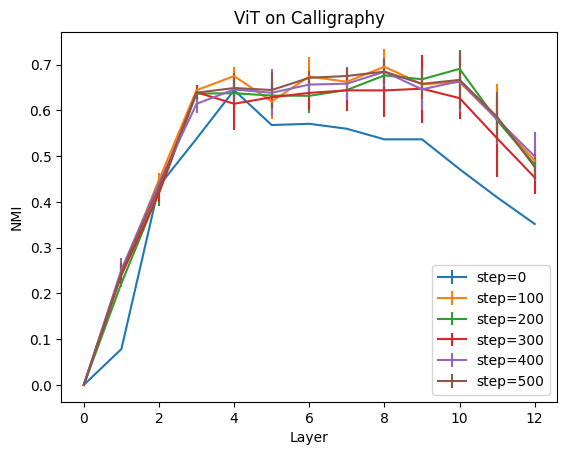

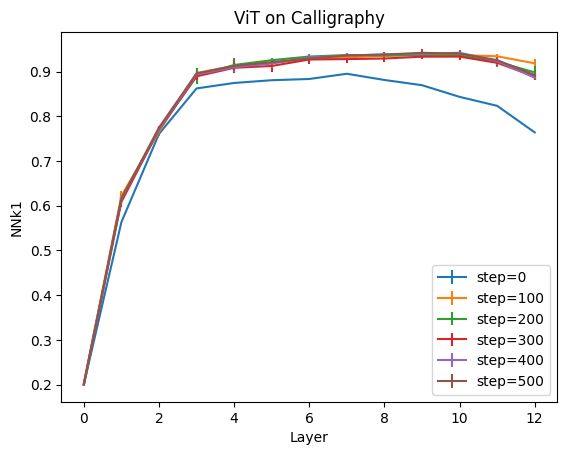

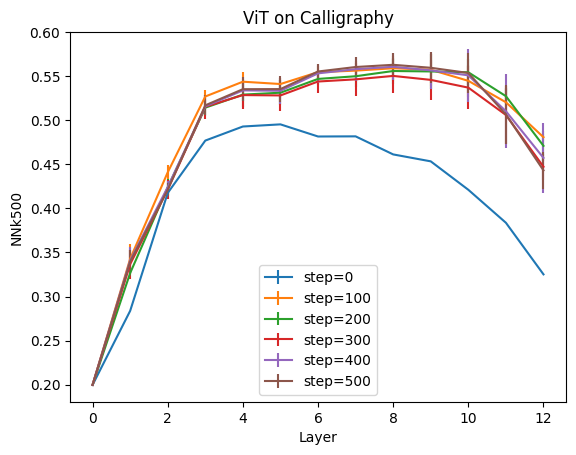

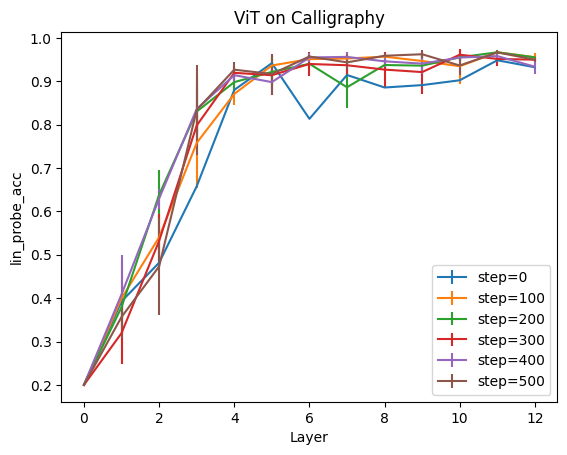

In [ ]:
run_trials(newViT, callig, 3)

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=Tru


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 0: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 0: L1: NMI=0.01 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 0: L2: NMI=0.00 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.29 
UNSEEN step 0: L3: NMI=0.00 NNk1=0.34 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 0: L4: NMI=0.01 NNk1=0.54 NNk500=0.23 lin_probe_acc=0.61 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 0: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 0: L1: NMI=0.02 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 0: L2: NMI=0.04 NNk1=0.14 NNk500=0.08 lin_probe_acc=0.14 
SEEN step 0: L3: NMI=0.03 NNk1=0.17 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 0: L4: NMI=0.03 NNk1=0.33 NNk500=0.10 lin_probe_acc=0.47 


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 100: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 100: L1: NMI=0.04 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 100: L2: NMI=0.02 NNk1=0.34 NNk500=0.21 lin_probe_acc=0.26 
UNSEEN step 100: L3: NMI=0.06 NNk1=0.75 NNk500=0.28 lin_probe_acc=0.20 
UNSEEN step 100: L4: NMI=0.58 NNk1=0.91 NNk500=0.53 lin_probe_acc=0.91 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 100: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 100: L1: NMI=0.02 NNk1=0.11 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 100: L2: NMI=0.06 NNk1=0.16 NNk500=0.09 lin_probe_acc=0.10 
SEEN step 100: L3: NMI=0.13 NNk1=0.60 NNk500=0.14 lin_probe_acc=0.14 
SEEN step 100: L4: NMI=0.79 NNk1=0.93 NNk500=0.34 lin_probe_acc=0.91 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 127: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 127: L1: NMI=0.01 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 127: L2: NMI=0.00 NNk1=0.28 NNk500=0.21 lin_probe_acc=0.25 
UNSEEN step 127: L3: NMI=0.01 NNk1=0.42 NNk500=0.22 lin_probe_acc=0.20 
UNSEEN step 127: L4: NMI=0.21 NNk1=0.82 NNk500=0.35 lin_probe_acc=0.83 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 127: L0: NMI=0.01 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.03 
SEEN step 127: L1: NMI=0.01 NNk1=0.11 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 127: L2: NMI=0.04 NNk1=0.15 NNk500=0.08 lin_probe_acc=0.07 
SEEN step 127: L3: NMI=0.05 NNk1=0.30 NNk500=0.09 lin_probe_acc=0.08 
SEEN step 127: L4: NMI=0.45 NNk1=0.86 NNk500=0.22 lin_probe_acc=0.88 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 200: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 200: L1: NMI=0.04 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 200: L2: NMI=0.02 NNk1=0.32 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 200: L3: NMI=0.03 NNk1=0.75 NNk500=0.28 lin_probe_acc=0.46 
UNSEEN step 200: L4: NMI=0.56 NNk1=0.92 NNk500=0.52 lin_probe_acc=0.92 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 200: L0: NMI=0.01 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 200: L1: NMI=0.03 NNk1=0.10 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 200: L2: NMI=0.05 NNk1=0.15 NNk500=0.09 lin_probe_acc=0.08 
SEEN step 200: L3: NMI=0.07 NNk1=0.60 NNk500=0.14 lin_probe_acc=0.08 
SEEN step 200: L4: NMI=0.81 NNk1=0.95 NNk500=0.34 lin_probe_acc=0.96 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 254: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 254: L1: NMI=0.01 NNk1=0.25 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 254: L2: NMI=0.01 NNk1=0.27 NNk500=0.20 lin_probe_acc=0.21 
UNSEEN step 254: L3: NMI=0.00 NNk1=0.51 NNk500=0.23 lin_probe_acc=0.28 
UNSEEN step 254: L4: NMI=0.36 NNk1=0.86 NNk500=0.41 lin_probe_acc=0.90 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 254: L0: NMI=0.01 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 254: L1: NMI=0.01 NNk1=0.10 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 254: L2: NMI=0.04 NNk1=0.12 NNk500=0.08 lin_probe_acc=0.10 
SEEN step 254: L3: NMI=0.04 NNk1=0.37 NNk500=0.10 lin_probe_acc=0.20 
SEEN step 254: L4: NMI=0.48 NNk1=0.91 NNk500=0.25 lin_probe_acc=0.92 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 300: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 300: L1: NMI=0.04 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 300: L2: NMI=0.02 NNk1=0.29 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 300: L3: NMI=0.02 NNk1=0.57 NNk500=0.23 lin_probe_acc=0.20 
UNSEEN step 300: L4: NMI=0.43 NNk1=0.92 NNk500=0.46 lin_probe_acc=0.95 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 300: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 300: L1: NMI=0.04 NNk1=0.10 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 300: L2: NMI=0.06 NNk1=0.14 NNk500=0.09 lin_probe_acc=0.08 
SEEN step 300: L3: NMI=0.06 NNk1=0.43 NNk500=0.10 lin_probe_acc=0.21 
SEEN step 300: L4: NMI=0.75 NNk1=0.96 NNk500=0.30 lin_probe_acc=0.93 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 381: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 381: L1: NMI=0.01 NNk1=0.23 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 381: L2: NMI=0.01 NNk1=0.28 NNk500=0.21 lin_probe_acc=0.24 
UNSEEN step 381: L3: NMI=0.01 NNk1=0.54 NNk500=0.23 lin_probe_acc=0.34 
UNSEEN step 381: L4: NMI=0.30 NNk1=0.88 NNk500=0.41 lin_probe_acc=0.89 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 381: L0: NMI=0.01 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 381: L1: NMI=0.01 NNk1=0.12 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 381: L2: NMI=0.04 NNk1=0.14 NNk500=0.08 lin_probe_acc=0.10 
SEEN step 381: L3: NMI=0.04 NNk1=0.41 NNk500=0.11 lin_probe_acc=0.15 
SEEN step 381: L4: NMI=0.62 NNk1=0.92 NNk500=0.26 lin_probe_acc=0.92 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 400: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 400: L1: NMI=0.03 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.21 
UNSEEN step 400: L2: NMI=0.02 NNk1=0.29 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 400: L3: NMI=0.04 NNk1=0.75 NNk500=0.28 lin_probe_acc=0.20 
UNSEEN step 400: L4: NMI=0.57 NNk1=0.93 NNk500=0.52 lin_probe_acc=0.94 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 400: L0: NMI=0.01 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 400: L1: NMI=0.03 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 400: L2: NMI=0.06 NNk1=0.16 NNk500=0.09 lin_probe_acc=0.13 
SEEN step 400: L3: NMI=0.08 NNk1=0.64 NNk500=0.15 lin_probe_acc=0.10 
SEEN step 400: L4: NMI=0.87 NNk1=0.97 NNk500=0.35 lin_probe_acc=0.97 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 500: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 500: L1: NMI=0.04 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.22 
UNSEEN step 500: L2: NMI=0.02 NNk1=0.29 NNk500=0.21 lin_probe_acc=0.21 
UNSEEN step 500: L3: NMI=0.03 NNk1=0.75 NNk500=0.28 lin_probe_acc=0.20 
UNSEEN step 500: L4: NMI=0.61 NNk1=0.92 NNk500=0.53 lin_probe_acc=0.94 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 500: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 500: L1: NMI=0.03 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 500: L2: NMI=0.06 NNk1=0.16 NNk500=0.09 lin_probe_acc=0.13 
SEEN step 500: L3: NMI=0.10 NNk1=0.65 NNk500=0.15 lin_probe_acc=0.18 
SEEN step 500: L4: NMI=0.86 NNk1=0.97 NNk500=0.35 lin_probe_acc=0.96 

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 842927632GF
  train_loss               =      0.2091
  train_runtime            =  0:10:53.30
  train_samples_per_second =      55.716
  train_steps_per_second   =       0.778


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=Tru


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 0: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 0: L1: NMI=0.01 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 0: L2: NMI=0.00 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.29 
UNSEEN step 0: L3: NMI=0.00 NNk1=0.34 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 0: L4: NMI=0.01 NNk1=0.54 NNk500=0.23 lin_probe_acc=0.61 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 0: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 0: L1: NMI=0.02 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 0: L2: NMI=0.04 NNk1=0.14 NNk500=0.08 lin_probe_acc=0.14 
SEEN step 0: L3: NMI=0.03 NNk1=0.17 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 0: L4: NMI=0.03 NNk1=0.33 NNk500=0.10 lin_probe_acc=0.47 


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 100: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 100: L1: NMI=0.03 NNk1=0.23 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 100: L2: NMI=0.02 NNk1=0.32 NNk500=0.21 lin_probe_acc=0.22 
UNSEEN step 100: L3: NMI=0.06 NNk1=0.54 NNk500=0.23 lin_probe_acc=0.30 
UNSEEN step 100: L4: NMI=0.40 NNk1=0.88 NNk500=0.41 lin_probe_acc=0.70 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 100: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 100: L1: NMI=0.03 NNk1=0.10 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 100: L2: NMI=0.05 NNk1=0.16 NNk500=0.09 lin_probe_acc=0.10 
SEEN step 100: L3: NMI=0.07 NNk1=0.38 NNk500=0.10 lin_probe_acc=0.14 
SEEN step 100: L4: NMI=0.62 NNk1=0.91 NNk500=0.24 lin_probe_acc=0.91 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 127: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 127: L1: NMI=0.01 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 127: L2: NMI=0.00 NNk1=0.27 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 127: L3: NMI=0.03 NNk1=0.41 NNk500=0.22 lin_probe_acc=0.30 
UNSEEN step 127: L4: NMI=0.21 NNk1=0.84 NNk500=0.33 lin_probe_acc=0.90 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 127: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 127: L1: NMI=0.01 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 127: L2: NMI=0.04 NNk1=0.15 NNk500=0.08 lin_probe_acc=0.04 
SEEN step 127: L3: NMI=0.05 NNk1=0.28 NNk500=0.09 lin_probe_acc=0.08 
SEEN step 127: L4: NMI=0.40 NNk1=0.86 NNk500=0.20 lin_probe_acc=0.88 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 200: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 200: L1: NMI=0.04 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 200: L2: NMI=0.02 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 200: L3: NMI=0.03 NNk1=0.62 NNk500=0.23 lin_probe_acc=0.21 
UNSEEN step 200: L4: NMI=0.36 NNk1=0.90 NNk500=0.46 lin_probe_acc=0.89 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 200: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 200: L1: NMI=0.04 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 200: L2: NMI=0.06 NNk1=0.15 NNk500=0.09 lin_probe_acc=0.11 
SEEN step 200: L3: NMI=0.06 NNk1=0.47 NNk500=0.10 lin_probe_acc=0.28 
SEEN step 200: L4: NMI=0.66 NNk1=0.94 NNk500=0.30 lin_probe_acc=0.96 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 254: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 254: L1: NMI=0.01 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 254: L2: NMI=0.00 NNk1=0.30 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 254: L3: NMI=0.03 NNk1=0.37 NNk500=0.22 lin_probe_acc=0.29 
UNSEEN step 254: L4: NMI=0.23 NNk1=0.84 NNk500=0.35 lin_probe_acc=0.86 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 254: L0: NMI=0.01 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 254: L1: NMI=0.01 NNk1=0.12 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 254: L2: NMI=0.04 NNk1=0.15 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 254: L3: NMI=0.04 NNk1=0.26 NNk500=0.08 lin_probe_acc=0.13 
SEEN step 254: L4: NMI=0.49 NNk1=0.89 NNk500=0.21 lin_probe_acc=0.90 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 300: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 300: L1: NMI=0.03 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 300: L2: NMI=0.02 NNk1=0.33 NNk500=0.21 lin_probe_acc=0.23 
UNSEEN step 300: L3: NMI=0.03 NNk1=0.61 NNk500=0.23 lin_probe_acc=0.20 
UNSEEN step 300: L4: NMI=0.57 NNk1=0.90 NNk500=0.49 lin_probe_acc=0.90 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 300: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 300: L1: NMI=0.05 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 300: L2: NMI=0.06 NNk1=0.17 NNk500=0.09 lin_probe_acc=0.09 
SEEN step 300: L3: NMI=0.07 NNk1=0.46 NNk500=0.10 lin_probe_acc=0.09 
SEEN step 300: L4: NMI=0.75 NNk1=0.95 NNk500=0.32 lin_probe_acc=0.96 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 381: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 381: L1: NMI=0.01 NNk1=0.23 NNk500=0.20 lin_probe_acc=0.21 
UNSEEN step 381: L2: NMI=0.01 NNk1=0.30 NNk500=0.20 lin_probe_acc=0.22 
UNSEEN step 381: L3: NMI=0.01 NNk1=0.49 NNk500=0.22 lin_probe_acc=0.22 
UNSEEN step 381: L4: NMI=0.30 NNk1=0.86 NNk500=0.39 lin_probe_acc=0.88 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 381: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 381: L1: NMI=0.01 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 381: L2: NMI=0.04 NNk1=0.13 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 381: L3: NMI=0.05 NNk1=0.36 NNk500=0.09 lin_probe_acc=0.12 
SEEN step 381: L4: NMI=0.56 NNk1=0.92 NNk500=0.25 lin_probe_acc=0.93 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 400: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 400: L1: NMI=0.03 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 400: L2: NMI=0.02 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.21 
UNSEEN step 400: L3: NMI=0.04 NNk1=0.53 NNk500=0.23 lin_probe_acc=0.20 
UNSEEN step 400: L4: NMI=0.39 NNk1=0.92 NNk500=0.43 lin_probe_acc=0.96 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 400: L0: NMI=0.01 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 400: L1: NMI=0.03 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.04 
SEEN step 400: L2: NMI=0.05 NNk1=0.15 NNk500=0.09 lin_probe_acc=0.09 
SEEN step 400: L3: NMI=0.06 NNk1=0.43 NNk500=0.09 lin_probe_acc=0.09 
SEEN step 400: L4: NMI=0.69 NNk1=0.97 NNk500=0.29 lin_probe_acc=0.98 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 500: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 500: L1: NMI=0.03 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 500: L2: NMI=0.02 NNk1=0.30 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 500: L3: NMI=0.05 NNk1=0.56 NNk500=0.23 lin_probe_acc=0.20 
UNSEEN step 500: L4: NMI=0.51 NNk1=0.90 NNk500=0.46 lin_probe_acc=0.96 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 500: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 500: L1: NMI=0.04 NNk1=0.11 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 500: L2: NMI=0.06 NNk1=0.16 NNk500=0.09 lin_probe_acc=0.13 
SEEN step 500: L3: NMI=0.07 NNk1=0.45 NNk500=0.09 lin_probe_acc=0.10 
SEEN step 500: L4: NMI=0.68 NNk1=0.97 NNk500=0.31 lin_probe_acc=0.94 

Checkpoint destination directory ./Trainers/Swin_calligTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 842927632GF
  train_loss               =      0.2487
  train_runtime            =  0:11:05.25
  train_samples_per_second =      54.716
  train_steps_per_second   =       0.764


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=Tru


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 0: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 0: L1: NMI=0.01 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 0: L2: NMI=0.00 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.29 
UNSEEN step 0: L3: NMI=0.00 NNk1=0.34 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 0: L4: NMI=0.01 NNk1=0.54 NNk500=0.23 lin_probe_acc=0.61 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 0: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 0: L1: NMI=0.02 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 0: L2: NMI=0.04 NNk1=0.14 NNk500=0.08 lin_probe_acc=0.14 
SEEN step 0: L3: NMI=0.03 NNk1=0.17 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 0: L4: NMI=0.03 NNk1=0.33 NNk500=0.10 lin_probe_acc=0.47 


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 100: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 100: L1: NMI=0.03 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 100: L2: NMI=0.02 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 100: L3: NMI=0.03 NNk1=0.36 NNk500=0.22 lin_probe_acc=0.20 
UNSEEN step 100: L4: NMI=0.30 NNk1=0.88 NNk500=0.34 lin_probe_acc=0.81 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 100: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 100: L1: NMI=0.03 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 100: L2: NMI=0.05 NNk1=0.16 NNk500=0.09 lin_probe_acc=0.09 
SEEN step 100: L3: NMI=0.06 NNk1=0.25 NNk500=0.09 lin_probe_acc=0.10 
SEEN step 100: L4: NMI=0.53 NNk1=0.91 NNk500=0.21 lin_probe_acc=0.87 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 127: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 127: L1: NMI=0.01 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.19 
UNSEEN step 127: L2: NMI=0.01 NNk1=0.28 NNk500=0.20 lin_probe_acc=0.23 
UNSEEN step 127: L3: NMI=0.03 NNk1=0.32 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 127: L4: NMI=0.14 NNk1=0.85 NNk500=0.29 lin_probe_acc=0.77 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 127: L0: NMI=0.01 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 127: L1: NMI=0.01 NNk1=0.10 NNk500=0.08 lin_probe_acc=0.02 
SEEN step 127: L2: NMI=0.04 NNk1=0.14 NNk500=0.08 lin_probe_acc=0.02 
SEEN step 127: L3: NMI=0.04 NNk1=0.22 NNk500=0.09 lin_probe_acc=0.08 
SEEN step 127: L4: NMI=0.34 NNk1=0.85 NNk500=0.18 lin_probe_acc=0.90 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 200: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 200: L1: NMI=0.03 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.21 
UNSEEN step 200: L2: NMI=0.01 NNk1=0.30 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 200: L3: NMI=0.04 NNk1=0.54 NNk500=0.22 lin_probe_acc=0.28 
UNSEEN step 200: L4: NMI=0.53 NNk1=0.91 NNk500=0.48 lin_probe_acc=0.88 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 200: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 200: L1: NMI=0.03 NNk1=0.10 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 200: L2: NMI=0.06 NNk1=0.16 NNk500=0.09 lin_probe_acc=0.14 
SEEN step 200: L3: NMI=0.07 NNk1=0.41 NNk500=0.10 lin_probe_acc=0.10 
SEEN step 200: L4: NMI=0.74 NNk1=0.95 NNk500=0.31 lin_probe_acc=0.91 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 254: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 254: L1: NMI=0.01 NNk1=0.26 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 254: L2: NMI=0.01 NNk1=0.27 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 254: L3: NMI=0.01 NNk1=0.39 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 254: L4: NMI=0.19 NNk1=0.86 NNk500=0.33 lin_probe_acc=0.84 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 254: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 254: L1: NMI=0.01 NNk1=0.10 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 254: L2: NMI=0.04 NNk1=0.12 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 254: L3: NMI=0.04 NNk1=0.29 NNk500=0.09 lin_probe_acc=0.14 
SEEN step 254: L4: NMI=0.47 NNk1=0.90 NNk500=0.21 lin_probe_acc=0.81 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 300: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 300: L1: NMI=0.03 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 300: L2: NMI=0.02 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 300: L3: NMI=0.04 NNk1=0.63 NNk500=0.23 lin_probe_acc=0.34 
UNSEEN step 300: L4: NMI=0.60 NNk1=0.91 NNk500=0.49 lin_probe_acc=0.84 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 300: L0: NMI=0.01 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 300: L1: NMI=0.03 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 300: L2: NMI=0.06 NNk1=0.17 NNk500=0.09 lin_probe_acc=0.12 
SEEN step 300: L3: NMI=0.07 NNk1=0.48 NNk500=0.11 lin_probe_acc=0.18 
SEEN step 300: L4: NMI=0.82 NNk1=0.96 NNk500=0.33 lin_probe_acc=0.94 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 381: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 381: L1: NMI=0.01 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 381: L2: NMI=0.00 NNk1=0.29 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 381: L3: NMI=0.00 NNk1=0.53 NNk500=0.22 lin_probe_acc=0.20 
UNSEEN step 381: L4: NMI=0.35 NNk1=0.88 NNk500=0.39 lin_probe_acc=0.84 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 381: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 381: L1: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 381: L2: NMI=0.04 NNk1=0.15 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 381: L3: NMI=0.05 NNk1=0.38 NNk500=0.10 lin_probe_acc=0.09 
SEEN step 381: L4: NMI=0.58 NNk1=0.92 NNk500=0.25 lin_probe_acc=0.94 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 400: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 400: L1: NMI=0.03 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.21 
UNSEEN step 400: L2: NMI=0.02 NNk1=0.30 NNk500=0.21 lin_probe_acc=0.24 
UNSEEN step 400: L3: NMI=0.05 NNk1=0.71 NNk500=0.24 lin_probe_acc=0.32 
UNSEEN step 400: L4: NMI=0.63 NNk1=0.92 NNk500=0.51 lin_probe_acc=0.94 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 400: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 400: L1: NMI=0.03 NNk1=0.10 NNk500=0.08 lin_probe_acc=0.08 
SEEN step 400: L2: NMI=0.06 NNk1=0.15 NNk500=0.09 lin_probe_acc=0.11 
SEEN step 400: L3: NMI=0.07 NNk1=0.56 NNk500=0.12 lin_probe_acc=0.22 
SEEN step 400: L4: NMI=0.84 NNk1=0.97 NNk500=0.34 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 500: L0: NMI=0.00 NNk1=0.20 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 500: L1: NMI=0.03 NNk1=0.22 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 500: L2: NMI=0.02 NNk1=0.30 NNk500=0.21 lin_probe_acc=0.20 
UNSEEN step 500: L3: NMI=0.04 NNk1=0.70 NNk500=0.25 lin_probe_acc=0.20 
UNSEEN step 500: L4: NMI=0.65 NNk1=0.94 NNk500=0.52 lin_probe_acc=0.90 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 

<ipython-input-32-c31bf8b9e2da>:82: ConvergenceWarning: Number of distinct clusters (14) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 500: L0: NMI=0.01 NNk1=0.09 NNk500=0.08 lin_probe_acc=0.09 
SEEN step 500: L1: NMI=0.03 NNk1=0.08 NNk500=0.08 lin_probe_acc=0.04 
SEEN step 500: L2: NMI=0.06 NNk1=0.15 NNk500=0.09 lin_probe_acc=0.11 
SEEN step 500: L3: NMI=0.07 NNk1=0.58 NNk500=0.13 lin_probe_acc=0.19 
SEEN step 500: L4: NMI=0.87 NNk1=0.97 NNk500=0.35 lin_probe_acc=0.95 

Checkpoint destination directory ./Trainers/Swin_calligTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 842927632GF
  train_loss               =      0.2032
  train_runtime            =  0:11:05.94
  train_samples_per_second =      54.659
  train_steps_per_second   =       0.763
6


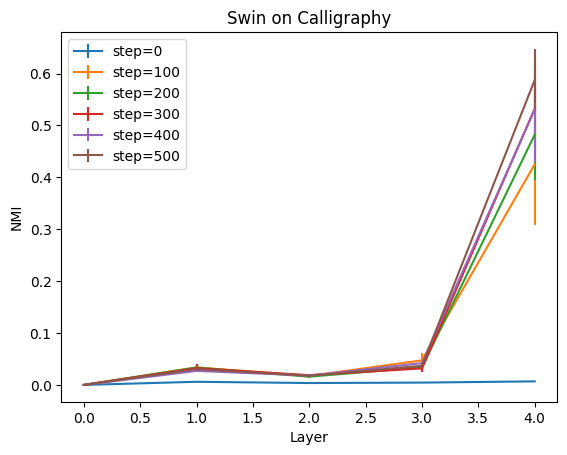

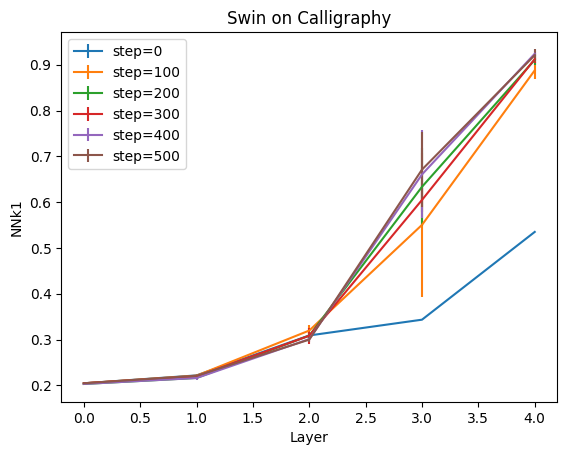

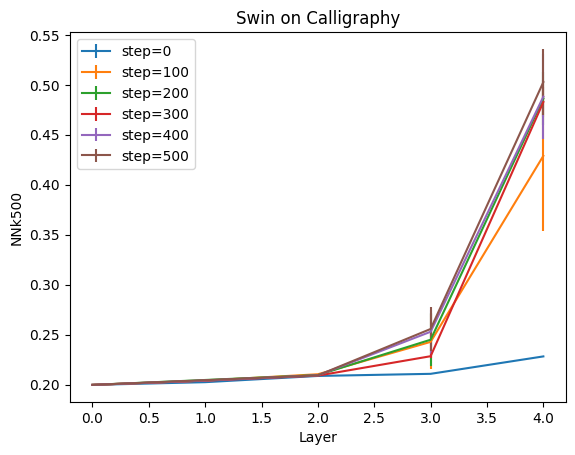

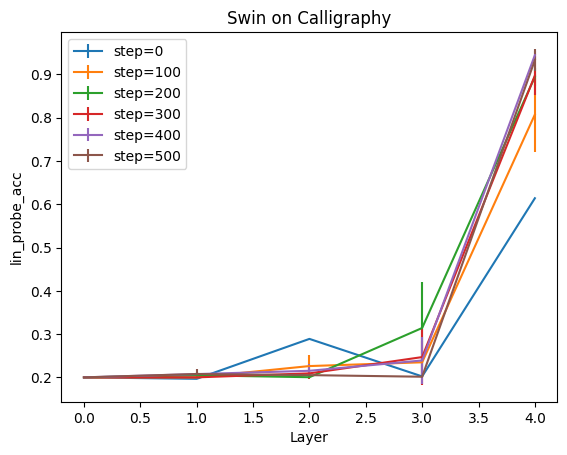

In [ ]:
run_trials(newSwin, callig, 3)

preprocessor_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/52.9M [00:00<?, ?B/s]

Some weights of PvtForImageClassification were not initialized from the model checkpoint at Zetatech/pvt-tiny-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([15, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sa


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.06 NNk1=0.37 NNk500=0.23 lin_probe_acc=0.20 
UNSEEN step 0: L1: NMI=0.03 NNk1=0.51 NNk500=0.25 lin_probe_acc=0.40 
UNSEEN step 0: L2: NMI=0.04 NNk1=0.55 NNk500=0.26 lin_probe_acc=0.37 
UNSEEN step 0: L3: NMI=0.03 NNk1=0.55 NNk500=0.27 lin_probe_acc=0.55 
UNSEEN step 0: L4: NMI=0.20 NNk1=0.70 NNk500=0.32 lin_probe_acc=0.69 
UNSEEN step 0: L5: NMI=0.17 NNk1=0.69 NNk500=0.32 lin_probe_acc=0.71 
UNSEEN step 0: L6: NMI=0.44 NNk1=0.82 NNk500=0.41 lin_probe_acc=0.82 
UNSEEN step 0: L7: NMI=0.33 NNk1=0.75 NNk500=0.36 lin_probe_acc=0.90 
UNSEEN step 0: L8: NMI=0.36 NNk1=0.76 NNk500=0.37 lin_probe_acc=0.92 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 0: L0: NMI=0.28 NNk1=0.32 NNk500=0.16 lin_probe_acc=0.21 
SEEN step 0: L1: NMI=0.23 NNk1=


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.02 NNk1=0.41 NNk500=0.25 lin_probe_acc=0.20 
UNSEEN step 100: L1: NMI=0.10 NNk1=0.52 NNk500=0.26 lin_probe_acc=0.33 
UNSEEN step 100: L2: NMI=0.17 NNk1=0.62 NNk500=0.30 lin_probe_acc=0.39 
UNSEEN step 100: L3: NMI=0.32 NNk1=0.71 NNk500=0.36 lin_probe_acc=0.71 
UNSEEN step 100: L4: NMI=0.34 NNk1=0.75 NNk500=0.37 lin_probe_acc=0.65 
UNSEEN step 100: L5: NMI=0.39 NNk1=0.78 NNk500=0.40 lin_probe_acc=0.86 
UNSEEN step 100: L6: NMI=0.70 NNk1=0.91 NNk500=0.54 lin_probe_acc=0.96 
UNSEEN step 100: L7: NMI=0.61 NNk1=0.89 NNk500=0.52 lin_probe_acc=0.95 
UNSEEN step 100: L8: NMI=0.63 NNk1=0.89 NNk500=0.53 lin_probe_acc=0.96 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 100: L0: NMI=0.08 NNk1=0.21 NNk500=0.10 lin_probe_acc=0.08 
SEEN step 1

Some weights of PvtForImageClassification were not initialized from the model checkpoint at Zetatech/pvt-tiny-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([15, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sa


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.06 NNk1=0.37 NNk500=0.23 lin_probe_acc=0.20 
UNSEEN step 0: L1: NMI=0.03 NNk1=0.51 NNk500=0.25 lin_probe_acc=0.40 
UNSEEN step 0: L2: NMI=0.04 NNk1=0.55 NNk500=0.26 lin_probe_acc=0.37 
UNSEEN step 0: L3: NMI=0.03 NNk1=0.55 NNk500=0.27 lin_probe_acc=0.55 
UNSEEN step 0: L4: NMI=0.20 NNk1=0.70 NNk500=0.32 lin_probe_acc=0.69 
UNSEEN step 0: L5: NMI=0.17 NNk1=0.69 NNk500=0.32 lin_probe_acc=0.71 
UNSEEN step 0: L6: NMI=0.44 NNk1=0.82 NNk500=0.41 lin_probe_acc=0.82 
UNSEEN step 0: L7: NMI=0.33 NNk1=0.75 NNk500=0.36 lin_probe_acc=0.90 
UNSEEN step 0: L8: NMI=0.36 NNk1=0.76 NNk500=0.37 lin_probe_acc=0.92 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 0: L0: NMI=0.28 NNk1=0.32 NNk500=0.16 lin_probe_acc=0.21 
SEEN step 0: L1: NMI=0.23 NNk1=


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.03 NNk1=0.43 NNk500=0.24 lin_probe_acc=0.20 
UNSEEN step 100: L1: NMI=0.16 NNk1=0.55 NNk500=0.29 lin_probe_acc=0.48 
UNSEEN step 100: L2: NMI=0.06 NNk1=0.57 NNk500=0.27 lin_probe_acc=0.29 
UNSEEN step 100: L3: NMI=0.30 NNk1=0.71 NNk500=0.38 lin_probe_acc=0.61 
UNSEEN step 100: L4: NMI=0.35 NNk1=0.77 NNk500=0.38 lin_probe_acc=0.49 
UNSEEN step 100: L5: NMI=0.31 NNk1=0.80 NNk500=0.38 lin_probe_acc=0.87 
UNSEEN step 100: L6: NMI=0.73 NNk1=0.90 NNk500=0.55 lin_probe_acc=0.91 
UNSEEN step 100: L7: NMI=0.65 NNk1=0.90 NNk500=0.54 lin_probe_acc=0.95 
UNSEEN step 100: L8: NMI=0.62 NNk1=0.90 NNk500=0.53 lin_probe_acc=0.95 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 100: L0: NMI=0.09 NNk1=0.21 NNk500=0.10 lin_probe_acc=0.12 
SEEN step 1

Checkpoint destination directory ./Trainers/PViT_calligTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 389576844GF
  train_loss               =       0.218
  train_runtime            =  0:09:02.01
  train_samples_per_second =      67.156
  train_steps_per_second   =       0.937


Some weights of PvtForImageClassification were not initialized from the model checkpoint at Zetatech/pvt-tiny-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([15, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sa


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.06 NNk1=0.37 NNk500=0.23 lin_probe_acc=0.20 
UNSEEN step 0: L1: NMI=0.03 NNk1=0.51 NNk500=0.25 lin_probe_acc=0.40 
UNSEEN step 0: L2: NMI=0.04 NNk1=0.55 NNk500=0.26 lin_probe_acc=0.37 
UNSEEN step 0: L3: NMI=0.03 NNk1=0.55 NNk500=0.27 lin_probe_acc=0.55 
UNSEEN step 0: L4: NMI=0.20 NNk1=0.70 NNk500=0.32 lin_probe_acc=0.69 
UNSEEN step 0: L5: NMI=0.17 NNk1=0.69 NNk500=0.32 lin_probe_acc=0.71 
UNSEEN step 0: L6: NMI=0.44 NNk1=0.82 NNk500=0.41 lin_probe_acc=0.82 
UNSEEN step 0: L7: NMI=0.33 NNk1=0.75 NNk500=0.36 lin_probe_acc=0.90 
UNSEEN step 0: L8: NMI=0.36 NNk1=0.76 NNk500=0.37 lin_probe_acc=0.92 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 0: L0: NMI=0.28 NNk1=0.32 NNk500=0.16 lin_probe_acc=0.21 
SEEN step 0: L1: NMI=0.23 NNk1=


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.03 NNk1=0.48 NNk500=0.25 lin_probe_acc=0.29 
UNSEEN step 100: L1: NMI=0.08 NNk1=0.53 NNk500=0.27 lin_probe_acc=0.31 
UNSEEN step 100: L2: NMI=0.03 NNk1=0.60 NNk500=0.28 lin_probe_acc=0.34 
UNSEEN step 100: L3: NMI=0.22 NNk1=0.69 NNk500=0.34 lin_probe_acc=0.61 
UNSEEN step 100: L4: NMI=0.32 NNk1=0.75 NNk500=0.36 lin_probe_acc=0.65 
UNSEEN step 100: L5: NMI=0.29 NNk1=0.79 NNk500=0.37 lin_probe_acc=0.66 
UNSEEN step 100: L6: NMI=0.66 NNk1=0.91 NNk500=0.55 lin_probe_acc=0.93 
UNSEEN step 100: L7: NMI=0.67 NNk1=0.91 NNk500=0.54 lin_probe_acc=0.94 
UNSEEN step 100: L8: NMI=0.59 NNk1=0.89 NNk500=0.53 lin_probe_acc=0.92 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 100: L0: NMI=0.06 NNk1=0.18 NNk500=0.10 lin_probe_acc=0.14 
SEEN step 1

Checkpoint destination directory ./Trainers/PViT_calligTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 389576844GF
  train_loss               =      0.2012
  train_runtime            =  0:08:48.63
  train_samples_per_second =      68.857
  train_steps_per_second   =       0.961
6


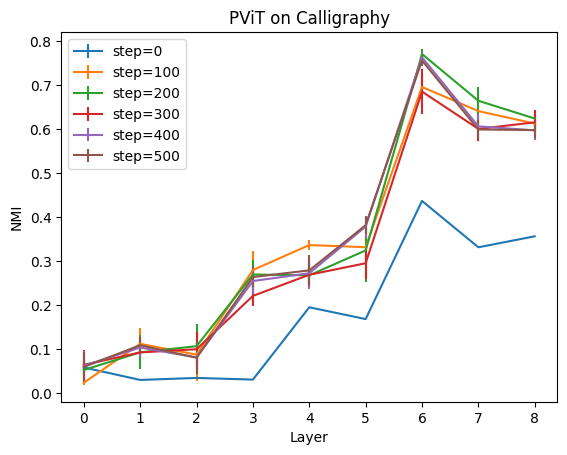

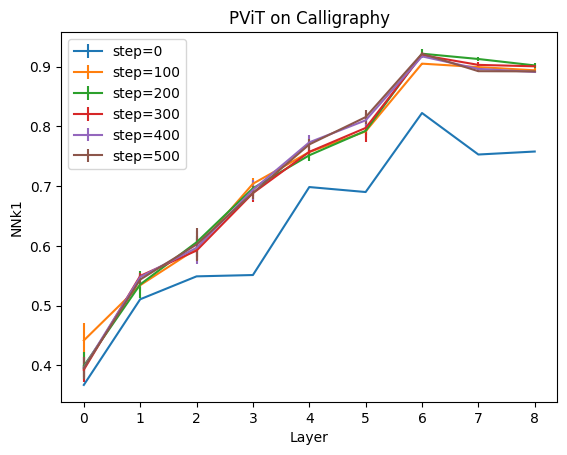

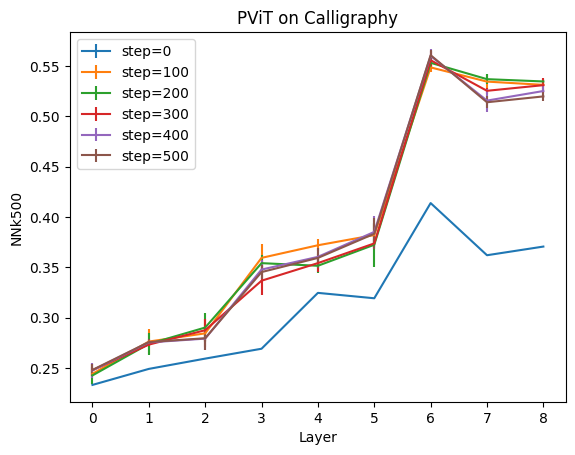

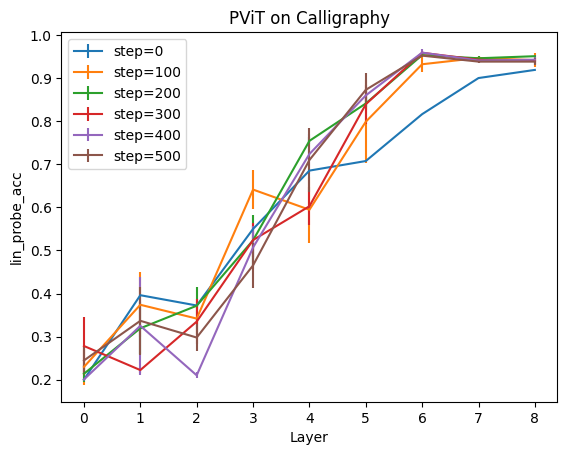

In [ ]:
run_trials(newPViT, callig, 3)

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/127M [00:00<?, ?B/s]

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([15, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.47 NNk1=0.99 NNk500=0.44 lin_probe_acc=0.46 
UNSEEN step 0: L1: NMI=0.59 NNk1=0.95 NNk500=0.46 lin_probe_acc=0.38 
UNSEEN step 0: L2: NMI=0.05 NNk1=0.57 NNk500=0.24 lin_probe_acc=0.31 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 0: L0: NMI=0.18 NNk1=0.46 NNk500=0.14 lin_probe_acc=0.53 
SEEN step 0: L1: NMI=0.26 NNk1=0.58 NNk500=0.18 lin_probe_acc=0.77 
SEEN step 0: L2: NMI=0.14 NNk1=0.39 NNk500=0.13 lin_probe_acc=0.60 


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.27 NNk1=0.73 NNk500=0.38 lin_probe_acc=0.57 
UNSEEN step 100: L1: NMI=0.38 NNk1=0.83 NNk500=0.43 lin_probe_acc=0.81 
UNSEEN step 100: L2: NMI=0.55 NNk1=0.93 NNk500=0.51 lin_probe_acc=0.96 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 100: L0: NMI=0.25 NNk1=0.46 NNk500=0.16 lin_probe_acc=0.49 
SEEN step 100: L1: NMI=0.34 NNk1=0.70 NNk500=0.20 lin_probe_acc=0.81 
SEEN step 100: L2: NMI=0.87 NNk1=0.95 NNk500=0.36 lin_probe_acc=0.96 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 127: L0: NMI=0.54 NNk1=1.00 NNk500=0.52 lin_probe_acc=0.40 
UNSEEN step 127: L1: NMI=0.46 NNk1=0.95 NNk500=0.39 lin_probe_acc=0.62 
UNSEEN step 127: L2: NMI=0.01 NNk1=0.53 NNk500=0.22 lin_probe_acc=0.38 
0

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([15, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is de


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.47 NNk1=0.99 NNk500=0.44 lin_probe_acc=0.46 
UNSEEN step 0: L1: NMI=0.59 NNk1=0.95 NNk500=0.46 lin_probe_acc=0.38 
UNSEEN step 0: L2: NMI=0.05 NNk1=0.57 NNk500=0.24 lin_probe_acc=0.31 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 0: L0: NMI=0.18 NNk1=0.46 NNk500=0.14 lin_probe_acc=0.53 
SEEN step 0: L1: NMI=0.26 NNk1=0.58 NNk500=0.18 lin_probe_acc=0.77 
SEEN step 0: L2: NMI=0.14 NNk1=0.39 NNk500=0.13 lin_probe_acc=0.60 


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.27 NNk1=0.72 NNk500=0.39 lin_probe_acc=0.38 
UNSEEN step 100: L1: NMI=0.33 NNk1=0.83 NNk500=0.38 lin_probe_acc=0.85 
UNSEEN step 100: L2: NMI=0.60 NNk1=0.93 NNk500=0.53 lin_probe_acc=0.92 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 100: L0: NMI=0.24 NNk1=0.46 NNk500=0.16 lin_probe_acc=0.39 
SEEN step 100: L1: NMI=0.31 NNk1=0.68 NNk500=0.19 lin_probe_acc=0.78 
SEEN step 100: L2: NMI=0.84 NNk1=0.95 NNk500=0.36 lin_probe_acc=0.96 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 127: L0: NMI=0.44 NNk1=0.97 NNk500=0.46 lin_probe_acc=0.52 
UNSEEN step 127: L1: NMI=0.18 NNk1=0.88 NNk500=0.33 lin_probe_acc=0.58 
UNSEEN step 127: L2: NMI=0.00 NNk1=0.54 NNk500=0.22 lin_probe_acc=0.32 
1

Checkpoint destination directory ./Trainers/CvT_calligTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 956597697GF
  train_loss               =      0.6474
  train_runtime            =  0:09:13.86
  train_samples_per_second =      65.721
  train_steps_per_second   =       0.917


Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([15, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.47 NNk1=0.99 NNk500=0.44 lin_probe_acc=0.46 
UNSEEN step 0: L1: NMI=0.59 NNk1=0.95 NNk500=0.46 lin_probe_acc=0.38 
UNSEEN step 0: L2: NMI=0.05 NNk1=0.57 NNk500=0.24 lin_probe_acc=0.31 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 0: L0: NMI=0.18 NNk1=0.46 NNk500=0.14 lin_probe_acc=0.53 
SEEN step 0: L1: NMI=0.26 NNk1=0.58 NNk500=0.18 lin_probe_acc=0.77 
SEEN step 0: L2: NMI=0.14 NNk1=0.39 NNk500=0.13 lin_probe_acc=0.60 


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.26 NNk1=0.72 NNk500=0.38 lin_probe_acc=0.42 
UNSEEN step 100: L1: NMI=0.35 NNk1=0.83 NNk500=0.38 lin_probe_acc=0.85 
UNSEEN step 100: L2: NMI=0.69 NNk1=0.92 NNk500=0.55 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 100: L0: NMI=0.24 NNk1=0.47 NNk500=0.16 lin_probe_acc=0.35 
SEEN step 100: L1: NMI=0.32 NNk1=0.70 NNk500=0.19 lin_probe_acc=0.71 
SEEN step 100: L2: NMI=0.88 NNk1=0.95 NNk500=0.36 lin_probe_acc=0.97 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 127: L0: NMI=0.49 NNk1=0.98 NNk500=0.49 lin_probe_acc=0.40 
UNSEEN step 127: L1: NMI=0.21 NNk1=0.92 NNk500=0.34 lin_probe_acc=0.54 
UNSEEN step 127: L2: NMI=0.02 NNk1=0.52 NNk500=0.22 lin_probe_acc=0.34 
2

Checkpoint destination directory ./Trainers/CvT_calligTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 956597697GF
  train_loss               =       0.651
  train_runtime            =  0:09:13.85
  train_samples_per_second =      65.721
  train_steps_per_second   =       0.917
6


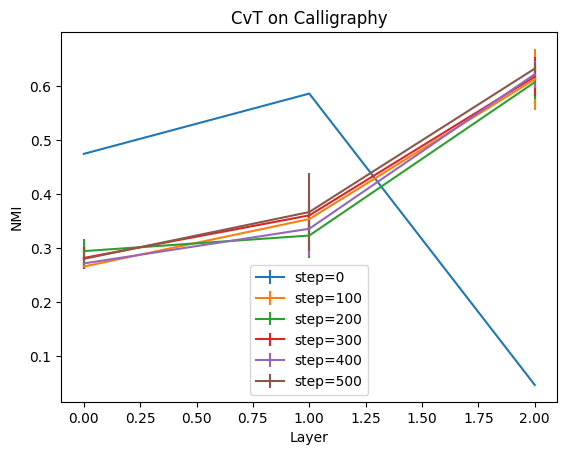

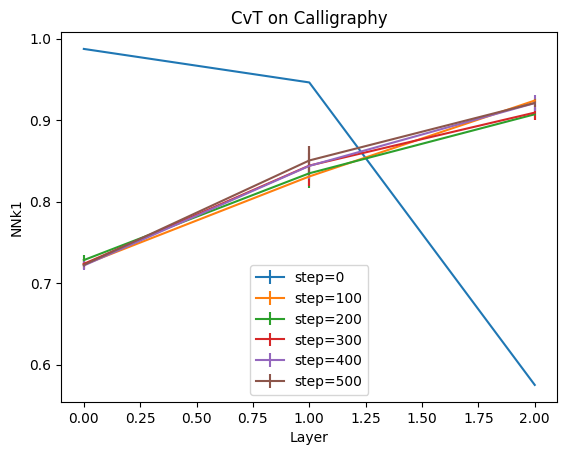

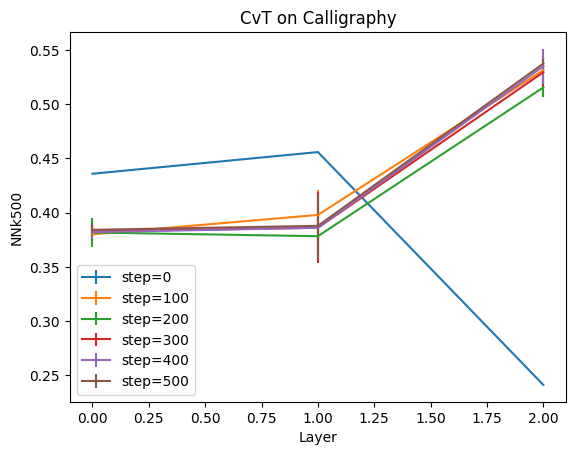

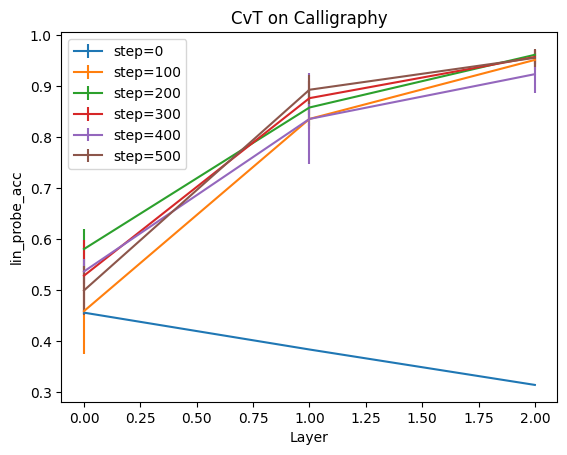

In [ ]:
run_trials(newCvT, callig, 3)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of PoolFormerForImageClassification were not initialized from the model checkpoint at sail/poolformer_s12 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([15, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelera


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.05 NNk1=0.69 NNk500=0.27 lin_probe_acc=0.60 
UNSEEN step 0: L1: NMI=0.17 NNk1=0.72 NNk500=0.31 lin_probe_acc=0.89 
UNSEEN step 0: L2: NMI=0.49 NNk1=0.87 NNk500=0.42 lin_probe_acc=0.89 
UNSEEN step 0: L3: NMI=0.34 NNk1=0.81 NNk500=0.36 lin_probe_acc=0.92 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 0: L0: NMI=0.14 NNk1=0.53 NNk500=0.14 lin_probe_acc=0.52 
SEEN step 0: L1: NMI=0.23 NNk1=0.63 NNk500=0.17 lin_probe_acc=0.80 
SEEN step 0: L2: NMI=0.45 NNk1=0.75 NNk500=0.22 lin_probe_acc=0.90 
SEEN step 0: L3: NMI=0.29 NNk1=0.62 NNk500=0.17 lin_probe_acc=0.79 


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.20 NNk1=0.72 NNk500=0.31 lin_probe_acc=0.61 
UNSEEN step 100: L1: NMI=0.22 NNk1=0.78 NNk500=0.34 lin_probe_acc=0.91 
UNSEEN step 100: L2: NMI=0.67 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.96 
UNSEEN step 100: L3: NMI=0.62 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.96 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 100: L0: NMI=0.23 NNk1=0.52 NNk500=0.16 lin_probe_acc=0.45 
SEEN step 100: L1: NMI=0.30 NNk1=0.67 NNk500=0.19 lin_probe_acc=0.86 
SEEN step 100: L2: NMI=0.80 NNk1=0.93 NNk500=0.34 lin_probe_acc=0.97 
SEEN step 100: L3: NMI=0.86 NNk1=0.94 NNk500=0.36 lin_probe_acc=0.96 

Checkpoint destination directory ./Trainers/PoolFormer_calligTrainer/checkpoint-100 already exists and is non-empty. Saving will proceed but saved results may be invalid.



0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 127: L0: NMI=0.21 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.65 
UNSEEN step 127: L1: NMI=0.21 NNk1=0.80 NNk500=0.34 lin_probe_acc=0.85 
UNSEEN step 127: L2: NMI=0.74 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.98 
UNSEEN step 127: L3: NMI=0.66 NNk1=0.91 NNk500=0.54 lin_probe_acc=0.97 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 127: L0: NMI=0.26 NNk1=0.53 NNk500=0.17 lin_probe_acc=0.55 
SEEN step 127: L1: NMI=0.31 NNk1=0.68 NNk500=0.19 lin_probe_acc=0.83 
SEEN step 127: L2: NMI=0.79 NNk1=0.95 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 127: L3: NMI=0.91 NNk1=0.95 NNk500=0.37 lin_probe_acc=0.96 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 200: L0: NMI=0.20 NNk1=0.73 NNk500=0.31 lin_probe_acc=0.67 
UNS

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 349341989GF
  train_loss               =      0.2048
  train_runtime            =  0:06:37.79
  train_samples_per_second =      91.504
  train_steps_per_second   =       1.277


Some weights of PoolFormerForImageClassification were not initialized from the model checkpoint at sail/poolformer_s12 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([15, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedab


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.05 NNk1=0.69 NNk500=0.27 lin_probe_acc=0.60 
UNSEEN step 0: L1: NMI=0.17 NNk1=0.72 NNk500=0.31 lin_probe_acc=0.89 
UNSEEN step 0: L2: NMI=0.49 NNk1=0.87 NNk500=0.42 lin_probe_acc=0.89 
UNSEEN step 0: L3: NMI=0.34 NNk1=0.81 NNk500=0.36 lin_probe_acc=0.92 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 0: L0: NMI=0.14 NNk1=0.53 NNk500=0.14 lin_probe_acc=0.52 
SEEN step 0: L1: NMI=0.23 NNk1=0.63 NNk500=0.17 lin_probe_acc=0.80 
SEEN step 0: L2: NMI=0.45 NNk1=0.75 NNk500=0.22 lin_probe_acc=0.90 
SEEN step 0: L3: NMI=0.29 NNk1=0.62 NNk500=0.17 lin_probe_acc=0.79 


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.18 NNk1=0.70 NNk500=0.32 lin_probe_acc=0.56 
UNSEEN step 100: L1: NMI=0.24 NNk1=0.80 NNk500=0.35 lin_probe_acc=0.88 
UNSEEN step 100: L2: NMI=0.76 NNk1=0.94 NNk500=0.56 lin_probe_acc=0.98 
UNSEEN step 100: L3: NMI=0.61 NNk1=0.92 NNk500=0.55 lin_probe_acc=0.97 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 100: L0: NMI=0.23 NNk1=0.50 NNk500=0.16 lin_probe_acc=0.52 
SEEN step 100: L1: NMI=0.33 NNk1=0.66 NNk500=0.20 lin_probe_acc=0.73 
SEEN step 100: L2: NMI=0.82 NNk1=0.94 NNk500=0.35 lin_probe_acc=0.96 
SEEN step 100: L3: NMI=0.87 NNk1=0.94 NNk500=0.36 lin_probe_acc=0.96 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 127: L0: NMI=0.21 NNk1=0.71 NNk500=0.32 lin_probe_acc=0.62 
UNS

Checkpoint destination directory ./Trainers/PoolFormer_calligTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 349341989GF
  train_loss               =      0.2061
  train_runtime            =  0:06:37.07
  train_samples_per_second =      91.671
  train_steps_per_second   =       1.279


Some weights of PoolFormerForImageClassification were not initialized from the model checkpoint at sail/poolformer_s12 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([15, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedab


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.05 NNk1=0.69 NNk500=0.27 lin_probe_acc=0.60 
UNSEEN step 0: L1: NMI=0.17 NNk1=0.72 NNk500=0.31 lin_probe_acc=0.89 
UNSEEN step 0: L2: NMI=0.49 NNk1=0.87 NNk500=0.42 lin_probe_acc=0.89 
UNSEEN step 0: L3: NMI=0.34 NNk1=0.81 NNk500=0.36 lin_probe_acc=0.92 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 0: L0: NMI=0.14 NNk1=0.53 NNk500=0.14 lin_probe_acc=0.52 
SEEN step 0: L1: NMI=0.23 NNk1=0.63 NNk500=0.17 lin_probe_acc=0.80 
SEEN step 0: L2: NMI=0.45 NNk1=0.75 NNk500=0.22 lin_probe_acc=0.90 
SEEN step 0: L3: NMI=0.29 NNk1=0.62 NNk500=0.17 lin_probe_acc=0.79 


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.22 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.58 
UNSEEN step 100: L1: NMI=0.22 NNk1=0.80 NNk500=0.34 lin_probe_acc=0.87 
UNSEEN step 100: L2: NMI=0.72 NNk1=0.93 NNk500=0.55 lin_probe_acc=0.95 
UNSEEN step 100: L3: NMI=0.65 NNk1=0.91 NNk500=0.55 lin_probe_acc=0.97 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 100: L0: NMI=0.22 NNk1=0.51 NNk500=0.16 lin_probe_acc=0.55 
SEEN step 100: L1: NMI=0.31 NNk1=0.67 NNk500=0.19 lin_probe_acc=0.86 
SEEN step 100: L2: NMI=0.79 NNk1=0.94 NNk500=0.34 lin_probe_acc=0.94 
SEEN step 100: L3: NMI=0.85 NNk1=0.94 NNk500=0.36 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 127: L0: NMI=0.22 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.56 
UNS

Checkpoint destination directory ./Trainers/PoolFormer_calligTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 349341989GF
  train_loss               =      0.2004
  train_runtime            =  0:06:42.67
  train_samples_per_second =      90.395
  train_steps_per_second   =       1.262
6


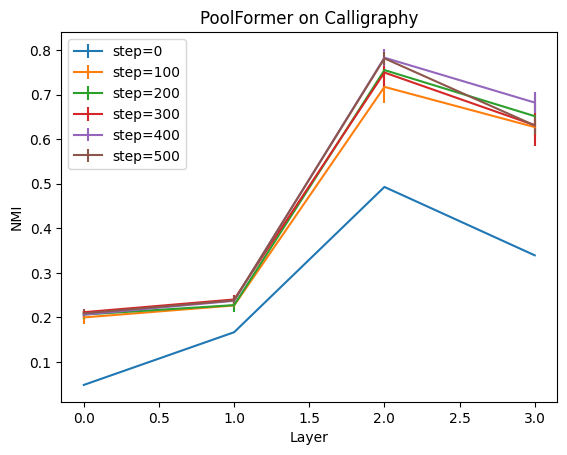

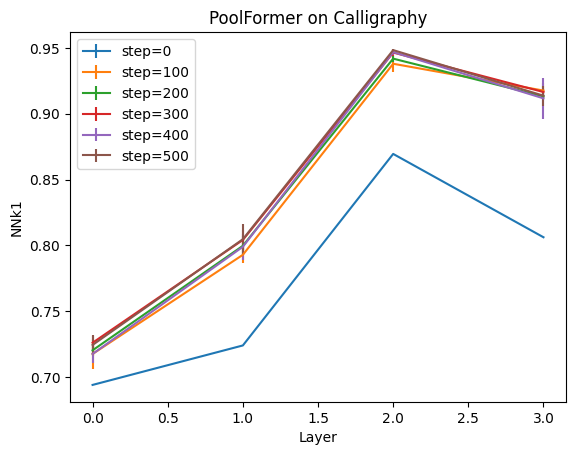

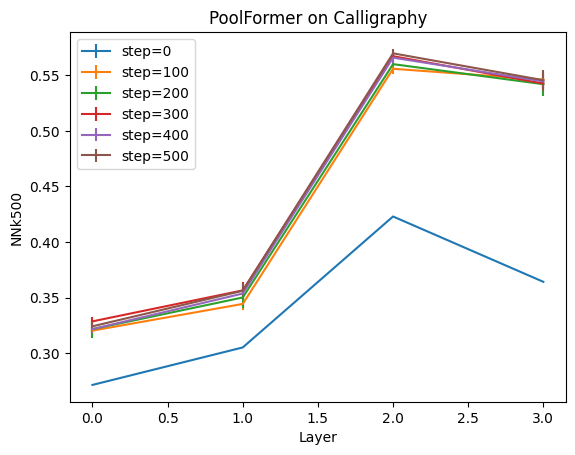

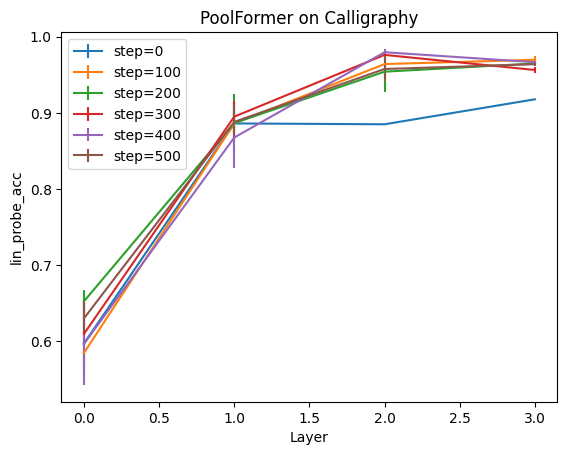

In [ ]:
run_trials(newPoolFormer, callig, 3)

preprocessor_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.27 NNk1=0.57 NNk500=0.34 lin_probe_acc=0.38 
UNSEEN step 0: L1: NMI=0.18 NNk1=0.69 NNk500=0.30 lin_probe_acc=0.38 
UNSEEN step 0: L2: NMI=0.02 NNk1=0.73 NNk500=0.22 lin_probe_acc=0.39 
UNSEEN step 0: L3: NMI=0.03 NNk1=0.65 NNk500=0.22 lin_probe_acc=0.20 
UNSEEN step 0: L4: NMI=0.30 NNk1=0.76 NNk500=0.34 lin_probe_acc=0.92 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 0: L0: NMI=0.21 NNk1=0.40 NNk500=0.15 lin_probe_acc=0.28 
SEEN step 0: L1: NMI=0.21 NNk1=0.53 NNk500=0.16 lin_probe_acc=0.15 
SEEN step 0: L2: NMI=0.10 NNk1=0.61 NNk500=0.11 lin_probe_acc=0.27 
SEEN step 0: L3: NMI=0.10 NNk1=0.51 NNk500=0.11 lin_probe_acc=0.31 
SEEN step 0: L4: NMI=0.26 NNk1=0.56 NNk500=0.16 lin_probe_acc=0.86 


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.27 NNk1=0.51 NNk500=0.34 lin_probe_acc=0.37 
UNSEEN step 100: L1: NMI=0.09 NNk1=0.72 NNk500=0.29 lin_probe_acc=0.29 
UNSEEN step 100: L2: NMI=0.03 NNk1=0.75 NNk500=0.24 lin_probe_acc=0.62 
UNSEEN step 100: L3: NMI=0.06 NNk1=0.78 NNk500=0.23 lin_probe_acc=0.44 
UNSEEN step 100: L4: NMI=0.57 NNk1=0.90 NNk500=0.49 lin_probe_acc=0.96 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 100: L0: NMI=0.19 NNk1=0.39 NNk500=0.14 lin_probe_acc=0.24 
SEEN step 100: L1: NMI=0.17 NNk1=0.45 NNk500=0.13 lin_probe_acc=0.24 
SEEN step 100: L2: NMI=0.13 NNk1=0.62 NNk500=0.12 lin_probe_acc=0.09 
SEEN step 100: L3: NMI=0.12 NNk1=0.86 NNk500=0.12 lin_probe_acc=0.65 
SEEN step 100: L4: NMI=0.86 NNk1=0.96 NNk500=0.37 lin_probe_acc=0.97 
0
0 1 2 3 4 5 6 7 8

Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.27 NNk1=0.57 NNk500=0.34 lin_probe_acc=0.38 
UNSEEN step 0: L1: NMI=0.18 NNk1=0.69 NNk500=0.30 lin_probe_acc=0.38 
UNSEEN step 0: L2: NMI=0.02 NNk1=0.73 NNk500=0.22 lin_probe_acc=0.39 
UNSEEN step 0: L3: NMI=0.03 NNk1=0.65 NNk500=0.22 lin_probe_acc=0.20 
UNSEEN step 0: L4: NMI=0.30 NNk1=0.76 NNk500=0.34 lin_probe_acc=0.92 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 0: L0: NMI=0.21 NNk1=0.40 NNk500=0.15 lin_probe_acc=0.28 
SEEN step 0: L1: NMI=0.21 NNk1=0.53 NNk500=0.16 lin_probe_acc=0.15 
SEEN step 0: L2: NMI=0.10 NNk1=0.61 NNk500=0.11 lin_probe_acc=0.27 
SEEN step 0: L3: NMI=0.10 NNk1=0.51 NNk500=0.11 lin_probe_acc=0.31 
SEEN step 0: L4: NMI=0.26 NNk1=0.56 NNk500=0.16 lin_probe_acc=0.86 


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.27 NNk1=0.51 NNk500=0.34 lin_probe_acc=0.36 
UNSEEN step 100: L1: NMI=0.12 NNk1=0.74 NNk500=0.28 lin_probe_acc=0.52 
UNSEEN step 100: L2: NMI=0.08 NNk1=0.74 NNk500=0.24 lin_probe_acc=0.59 
UNSEEN step 100: L3: NMI=0.18 NNk1=0.83 NNk500=0.29 lin_probe_acc=0.56 
UNSEEN step 100: L4: NMI=0.59 NNk1=0.90 NNk500=0.50 lin_probe_acc=0.94 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 100: L0: NMI=0.21 NNk1=0.39 NNk500=0.14 lin_probe_acc=0.34 
SEEN step 100: L1: NMI=0.16 NNk1=0.43 NNk500=0.13 lin_probe_acc=0.27 
SEEN step 100: L2: NMI=0.11 NNk1=0.62 NNk500=0.11 lin_probe_acc=0.57 
SEEN step 100: L3: NMI=0.18 NNk1=0.85 NNk500=0.13 lin_probe_acc=0.75 
SEEN step 100: L4: NMI=0.87 NNk1=0.96 NNk500=0.36 lin_probe_acc=0.97 
1
0 1 2 3 4 5 6 7 8

Checkpoint destination directory ./Trainers/ConvNeXtV2_calligTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 853556260GF
  train_loss               =      0.1949
  train_runtime            =  0:11:26.03
  train_samples_per_second =      53.059
  train_steps_per_second   =        0.74


Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.27 NNk1=0.57 NNk500=0.34 lin_probe_acc=0.38 
UNSEEN step 0: L1: NMI=0.18 NNk1=0.69 NNk500=0.30 lin_probe_acc=0.38 
UNSEEN step 0: L2: NMI=0.02 NNk1=0.73 NNk500=0.22 lin_probe_acc=0.39 
UNSEEN step 0: L3: NMI=0.03 NNk1=0.65 NNk500=0.22 lin_probe_acc=0.20 
UNSEEN step 0: L4: NMI=0.30 NNk1=0.76 NNk500=0.34 lin_probe_acc=0.92 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 0: L0: NMI=0.21 NNk1=0.40 NNk500=0.15 lin_probe_acc=0.28 
SEEN step 0: L1: NMI=0.21 NNk1=0.53 NNk500=0.16 lin_probe_acc=0.15 
SEEN step 0: L2: NMI=0.10 NNk1=0.61 NNk500=0.11 lin_probe_acc=0.27 
SEEN step 0: L3: NMI=0.10 NNk1=0.51 NNk500=0.11 lin_probe_acc=0.31 
SEEN step 0: L4: NMI=0.26 NNk1=0.56 NNk500=0.16 lin_probe_acc=0.86 


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.27 NNk1=0.53 NNk500=0.34 lin_probe_acc=0.39 
UNSEEN step 100: L1: NMI=0.02 NNk1=0.71 NNk500=0.25 lin_probe_acc=0.34 
UNSEEN step 100: L2: NMI=0.04 NNk1=0.78 NNk500=0.23 lin_probe_acc=0.42 
UNSEEN step 100: L3: NMI=0.16 NNk1=0.76 NNk500=0.28 lin_probe_acc=0.20 
UNSEEN step 100: L4: NMI=0.49 NNk1=0.90 NNk500=0.47 lin_probe_acc=0.94 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 
SEEN step 100: L0: NMI=0.18 NNk1=0.39 NNk500=0.14 lin_probe_acc=0.35 
SEEN step 100: L1: NMI=0.14 NNk1=0.45 NNk500=0.11 lin_probe_acc=0.17 
SEEN step 100: L2: NMI=0.13 NNk1=0.63 NNk500=0.12 lin_probe_acc=0.45 
SEEN step 100: L3: NMI=0.23 NNk1=0.86 NNk500=0.15 lin_probe_acc=0.72 
SEEN step 100: L4: NMI=0.90 NNk1=0.97 NNk500=0.37 lin_probe_acc=0.98 
2
0 1 2 3 4 5 6 7 8

Checkpoint destination directory ./Trainers/ConvNeXtV2_calligTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 853556260GF
  train_loss               =      0.1688
  train_runtime            =  0:11:16.74
  train_samples_per_second =      53.787
  train_steps_per_second   =       0.751
6


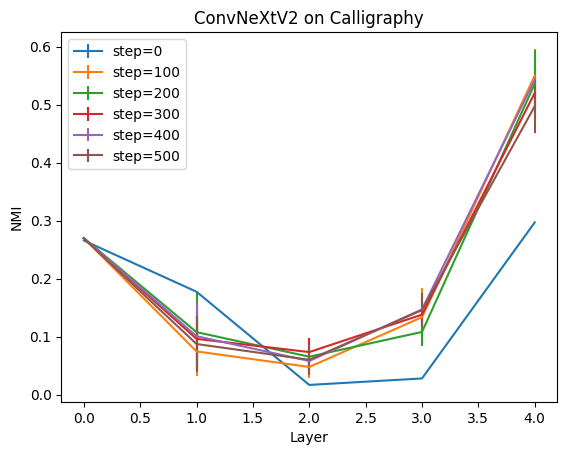

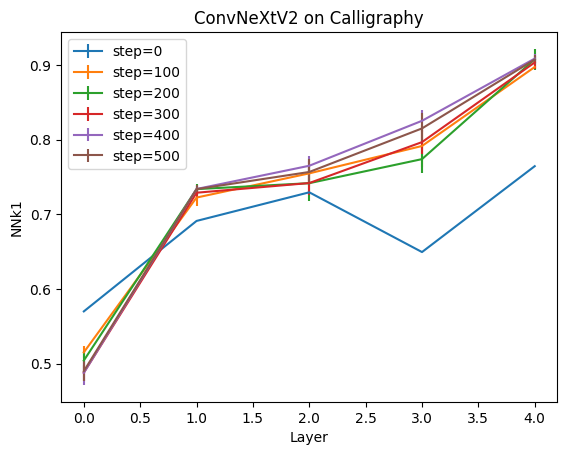

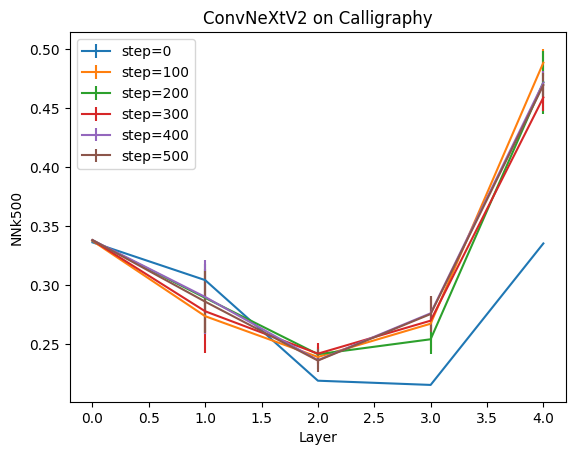

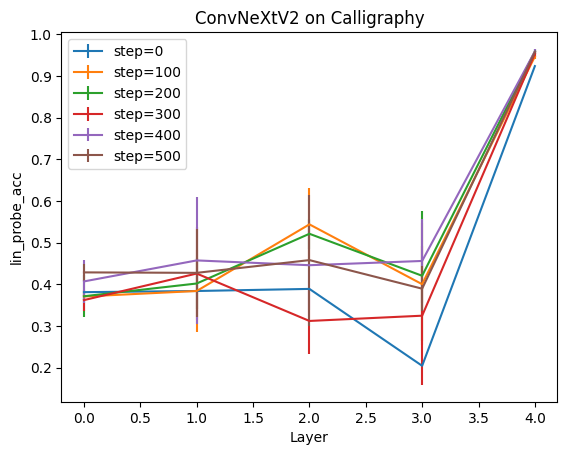

In [ ]:
run_trials(newConvNeXtV2, callig, 3)

# CiFar

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(



0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 0: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.21 
UNSEEN step 0: L1: NMI=0.10 NNk1=0.45 NNk500=0.27 lin_probe_acc=0.54 
UNSEEN step 0: L2: NMI=0.15 NNk1=0.54 NNk500=0.29 lin_probe_acc=0.51 
UNSEEN step 0: L3: NMI=0.20 NNk1=0.62 NNk500=0.30 lin_probe_acc=0.71 
UNSEEN step 0: L4: NMI=0.21 NNk1=0.66 NNk500=0.31 lin_probe_acc=0.72 
UNSEEN step 0: L5: NMI=0.23 NNk1=0.68 NNk500=0.31 lin_probe_acc=0.81 
UNSEEN step 0: L6: NMI=0.23 NNk1=0.71 NNk500=0.32 lin_probe_acc=0.86 
UNSEEN step 0: L7: NMI=0.24 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.88 
UNSEEN step 0: L8: NMI=0.31 NNk1=0.79 NNk500=0.36 lin_probe_acc=0.90 
UNSEEN step 0: L9: NMI=0.31 NNk1=0.82 NNk500=0.37 lin_probe_acc=0.92 
UNSEEN step 0: L10: NMI=0.41 NNk1=0.85 NNk500=0.41 lin_probe_acc=0.93 
UNSEEN step 0: L11: NMI=0.46 NNk1=0.88 NNk500=0.43 lin_probe_acc=0.94 
UNSEEN step 0: L12: NMI=0.65 NNk1=0.90 NNk500=0.48 lin_probe_acc=0.93 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 0: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 0: L1: NMI=0.24 NNk1=0.24 NNk500=0.08 lin_probe_acc=0.20 
SEEN step 0: L2: NMI=0.26 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.29 
SEEN step 0: L3: NMI=0.30 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.51 
SEEN step 0: L4: NMI=0.35 NNk1=0.47 NNk500=0.10 lin_probe_acc=0.64 
SEEN step 0: L5: NMI=0.39 NNk1=0.51 NNk500=0.10 lin_probe_acc=0.71 
SEEN step 0: L6: NMI=0.42 NNk1=0.54 NNk500=0.11 lin_probe_acc=0.77 
SEEN step 0: L7: NMI=0.48 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.83 
SEEN step 0: L8: NMI=0.51 NNk1=0.67 NNk500=0.13 lin_probe_acc=0.86 
SEEN step 0: L9: NMI=0.56 NNk1=0.70 NNk500=0.14 lin_probe_acc=0.89 
SEEN step 0: L10: NMI=0.59 NNk1=0.76 NNk500=0.15 lin_probe_acc=0.91 
SEEN step 0: L11: NMI=0.66 NNk1=0.85 NNk500=0.16 lin_probe_acc=0.92 
SEEN step 0: L12: NMI=0.70 NNk1=0.87 NNk500=0.15 lin_probe_acc=0.92 


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 100: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 100: L1: NMI=0.11 NNk1=0.46 NNk500=0.27 lin_probe_acc=0.36 
UNSEEN step 100: L2: NMI=0.14 NNk1=0.54 NNk500=0.29 lin_probe_acc=0.51 
UNSEEN step 100: L3: NMI=0.21 NNk1=0.64 NNk500=0.31 lin_probe_acc=0.53 
UNSEEN step 100: L4: NMI=0.20 NNk1=0.64 NNk500=0.31 lin_probe_acc=0.74 
UNSEEN step 100: L5: NMI=0.22 NNk1=0.67 NNk500=0.32 lin_probe_acc=0.61 
UNSEEN step 100: L6: NMI=0.21 NNk1=0.71 NNk500=0.32 lin_probe_acc=0.80 
UNSEEN step 100: L7: NMI=0.21 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.78 
UNSEEN step 100: L8: NMI=0.22 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.84 
UNSEEN step 100: L9: NMI=0.24 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.78 
UNSEEN step 100: L10: NMI=0.27 NNk1=0.78 NNk500=0.35 lin_probe_acc=0.83 
UNSEEN step 100: L11: NMI=0.25 NNk1=0.81 NNk500=0.37 lin_probe_acc=0.88 
UNSEEN step 100: L12: NMI=0.30 NNk1=0.83 NNk500=0.38 lin_probe_acc=0.91 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 100: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 100: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.14 
SEEN step 100: L2: NMI=0.26 NNk1=0.29 NNk500=0.08 lin_probe_acc=0.24 
SEEN step 100: L3: NMI=0.30 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.27 
SEEN step 100: L4: NMI=0.35 NNk1=0.48 NNk500=0.10 lin_probe_acc=0.54 
SEEN step 100: L5: NMI=0.42 NNk1=0.54 NNk500=0.11 lin_probe_acc=0.55 
SEEN step 100: L6: NMI=0.46 NNk1=0.59 NNk500=0.12 lin_probe_acc=0.73 
SEEN step 100: L7: NMI=0.51 NNk1=0.64 NNk500=0.14 lin_probe_acc=0.73 
SEEN step 100: L8: NMI=0.54 NNk1=0.68 NNk500=0.15 lin_probe_acc=0.78 
SEEN step 100: L9: NMI=0.58 NNk1=0.73 NNk500=0.16 lin_probe_acc=0.80 
SEEN step 100: L10: NMI=0.70 NNk1=0.87 NNk500=0.18 lin_probe_acc=0.89 
SEEN step 100: L11: NMI=0.77 NNk1=0.93 NNk500=0.19 lin_probe_acc=0.95 
SEEN step 100: L12: NMI=0.81 NNk1=0.94 NNk500=0.20 lin_probe_acc=0.95 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 139: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 139: L1: NMI=0.12 NNk1=0.46 NNk500=0.27 lin_probe_acc=0.29 
UNSEEN step 139: L2: NMI=0.15 NNk1=0.54 NNk500=0.28 lin_probe_acc=0.41 
UNSEEN step 139: L3: NMI=0.20 NNk1=0.63 NNk500=0.31 lin_probe_acc=0.66 
UNSEEN step 139: L4: NMI=0.20 NNk1=0.66 NNk500=0.31 lin_probe_acc=0.71 
UNSEEN step 139: L5: NMI=0.21 NNk1=0.69 NNk500=0.32 lin_probe_acc=0.75 
UNSEEN step 139: L6: NMI=0.23 NNk1=0.70 NNk500=0.32 lin_probe_acc=0.74 
UNSEEN step 139: L7: NMI=0.21 NNk1=0.71 NNk500=0.32 lin_probe_acc=0.67 
UNSEEN step 139: L8: NMI=0.23 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.77 
UNSEEN step 139: L9: NMI=0.22 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.79 
UNSEEN step 139: L10: NMI=0.27 NNk1=0.76 NNk500=0.35 lin_probe_acc=0.83 
UNSEEN step 139: L11: NMI=0.30 NNk1=0.81 NNk500=0.36 lin_probe_acc=0.84 
UNSEEN step 139: L12: NMI=0.28 NNk1=0.82 NNk500=0.38 lin_probe_acc=0.91 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 139: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 139: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.20 
SEEN step 139: L2: NMI=0.26 NNk1=0.28 NNk500=0.08 lin_probe_acc=0.23 
SEEN step 139: L3: NMI=0.31 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.37 
SEEN step 139: L4: NMI=0.37 NNk1=0.50 NNk500=0.10 lin_probe_acc=0.59 
SEEN step 139: L5: NMI=0.43 NNk1=0.56 NNk500=0.11 lin_probe_acc=0.66 
SEEN step 139: L6: NMI=0.49 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.73 
SEEN step 139: L7: NMI=0.54 NNk1=0.68 NNk500=0.14 lin_probe_acc=0.78 
SEEN step 139: L8: NMI=0.56 NNk1=0.71 NNk500=0.15 lin_probe_acc=0.75 
SEEN step 139: L9: NMI=0.59 NNk1=0.76 NNk500=0.16 lin_probe_acc=0.87 
SEEN step 139: L10: NMI=0.69 NNk1=0.86 NNk500=0.18 lin_probe_acc=0.89 
SEEN step 139: L11: NMI=0.77 NNk1=0.94 NNk500=0.19 lin_probe_acc=0.96 
SEEN step 139: L12: NMI=0.81 NNk1=0.94 NNk500=0.20 lin_probe_acc=0.96 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 200: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.19 
UNSEEN step 200: L1: NMI=0.09 NNk1=0.43 NNk500=0.26 lin_probe_acc=0.30 
UNSEEN step 200: L2: NMI=0.14 NNk1=0.55 NNk500=0.29 lin_probe_acc=0.40 
UNSEEN step 200: L3: NMI=0.19 NNk1=0.62 NNk500=0.30 lin_probe_acc=0.39 
UNSEEN step 200: L4: NMI=0.20 NNk1=0.65 NNk500=0.31 lin_probe_acc=0.69 
UNSEEN step 200: L5: NMI=0.22 NNk1=0.68 NNk500=0.32 lin_probe_acc=0.74 
UNSEEN step 200: L6: NMI=0.21 NNk1=0.70 NNk500=0.32 lin_probe_acc=0.72 
UNSEEN step 200: L7: NMI=0.22 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.61 
UNSEEN step 200: L8: NMI=0.22 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.78 
UNSEEN step 200: L9: NMI=0.21 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.65 
UNSEEN step 200: L10: NMI=0.25 NNk1=0.76 NNk500=0.33 lin_probe_acc=0.75 
UNSEEN step 200: L11: NMI=0.21 NNk1=0.79 NNk500=0.34 lin_probe_acc=0.83 
UNSEEN step 200: L12: NMI=0.23 NNk1=0.80 NNk500=0.36 lin_probe_acc=0.89 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 200: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 200: L1: NMI=0.24 NNk1=0.22 NNk500=0.07 lin_probe_acc=0.21 
SEEN step 200: L2: NMI=0.26 NNk1=0.29 NNk500=0.08 lin_probe_acc=0.25 
SEEN step 200: L3: NMI=0.31 NNk1=0.40 NNk500=0.09 lin_probe_acc=0.48 
SEEN step 200: L4: NMI=0.36 NNk1=0.49 NNk500=0.10 lin_probe_acc=0.53 
SEEN step 200: L5: NMI=0.43 NNk1=0.54 NNk500=0.11 lin_probe_acc=0.68 
SEEN step 200: L6: NMI=0.47 NNk1=0.60 NNk500=0.12 lin_probe_acc=0.68 
SEEN step 200: L7: NMI=0.52 NNk1=0.64 NNk500=0.14 lin_probe_acc=0.75 
SEEN step 200: L8: NMI=0.53 NNk1=0.66 NNk500=0.15 lin_probe_acc=0.64 
SEEN step 200: L9: NMI=0.57 NNk1=0.71 NNk500=0.16 lin_probe_acc=0.79 
SEEN step 200: L10: NMI=0.67 NNk1=0.84 NNk500=0.18 lin_probe_acc=0.89 
SEEN step 200: L11: NMI=0.77 NNk1=0.94 NNk500=0.19 lin_probe_acc=0.95 
SEEN step 200: L12: NMI=0.82 NNk1=0.94 NNk500=0.20 lin_probe_acc=0.95 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 278: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 278: L1: NMI=0.09 NNk1=0.44 NNk500=0.26 lin_probe_acc=0.30 
UNSEEN step 278: L2: NMI=0.17 NNk1=0.54 NNk500=0.29 lin_probe_acc=0.44 
UNSEEN step 278: L3: NMI=0.20 NNk1=0.61 NNk500=0.31 lin_probe_acc=0.54 
UNSEEN step 278: L4: NMI=0.20 NNk1=0.65 NNk500=0.31 lin_probe_acc=0.50 
UNSEEN step 278: L5: NMI=0.21 NNk1=0.67 NNk500=0.32 lin_probe_acc=0.69 
UNSEEN step 278: L6: NMI=0.20 NNk1=0.68 NNk500=0.32 lin_probe_acc=0.77 
UNSEEN step 278: L7: NMI=0.22 NNk1=0.70 NNk500=0.32 lin_probe_acc=0.67 
UNSEEN step 278: L8: NMI=0.21 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.70 
UNSEEN step 278: L9: NMI=0.23 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.70 
UNSEEN step 278: L10: NMI=0.23 NNk1=0.75 NNk500=0.33 lin_probe_acc=0.78 
UNSEEN step 278: L11: NMI=0.29 NNk1=0.81 NNk500=0.35 lin_probe_acc=0.77 
UNSEEN step 278: L12: NMI=0.36 NNk1=0.81 NNk500=0.38 lin_probe_acc=0.91 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 278: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 278: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.15 
SEEN step 278: L2: NMI=0.26 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.25 
SEEN step 278: L3: NMI=0.31 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.49 
SEEN step 278: L4: NMI=0.38 NNk1=0.50 NNk500=0.10 lin_probe_acc=0.55 
SEEN step 278: L5: NMI=0.42 NNk1=0.54 NNk500=0.11 lin_probe_acc=0.66 
SEEN step 278: L6: NMI=0.47 NNk1=0.60 NNk500=0.13 lin_probe_acc=0.74 
SEEN step 278: L7: NMI=0.52 NNk1=0.66 NNk500=0.14 lin_probe_acc=0.73 
SEEN step 278: L8: NMI=0.54 NNk1=0.68 NNk500=0.15 lin_probe_acc=0.77 
SEEN step 278: L9: NMI=0.58 NNk1=0.73 NNk500=0.16 lin_probe_acc=0.82 
SEEN step 278: L10: NMI=0.69 NNk1=0.85 NNk500=0.18 lin_probe_acc=0.89 
SEEN step 278: L11: NMI=0.78 NNk1=0.95 NNk500=0.19 lin_probe_acc=0.95 
SEEN step 278: L12: NMI=0.83 NNk1=0.94 NNk500=0.20 lin_probe_acc=0.96 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 300: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 300: L1: NMI=0.09 NNk1=0.45 NNk500=0.26 lin_probe_acc=0.40 
UNSEEN step 300: L2: NMI=0.16 NNk1=0.56 NNk500=0.29 lin_probe_acc=0.50 
UNSEEN step 300: L3: NMI=0.19 NNk1=0.63 NNk500=0.31 lin_probe_acc=0.60 
UNSEEN step 300: L4: NMI=0.21 NNk1=0.66 NNk500=0.31 lin_probe_acc=0.60 
UNSEEN step 300: L5: NMI=0.21 NNk1=0.67 NNk500=0.32 lin_probe_acc=0.76 
UNSEEN step 300: L6: NMI=0.22 NNk1=0.70 NNk500=0.32 lin_probe_acc=0.73 
UNSEEN step 300: L7: NMI=0.22 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.62 
UNSEEN step 300: L8: NMI=0.22 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.70 
UNSEEN step 300: L9: NMI=0.21 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.69 
UNSEEN step 300: L10: NMI=0.23 NNk1=0.75 NNk500=0.33 lin_probe_acc=0.71 
UNSEEN step 300: L11: NMI=0.33 NNk1=0.82 NNk500=0.36 lin_probe_acc=0.87 
UNSEEN step 300: L12: NMI=0.42 NNk1=0.82 NNk500=0.41 lin_probe_acc=0.92 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 300: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 300: L1: NMI=0.23 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.06 
SEEN step 300: L2: NMI=0.27 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.18 
SEEN step 300: L3: NMI=0.31 NNk1=0.41 NNk500=0.09 lin_probe_acc=0.35 
SEEN step 300: L4: NMI=0.37 NNk1=0.51 NNk500=0.10 lin_probe_acc=0.58 
SEEN step 300: L5: NMI=0.43 NNk1=0.55 NNk500=0.12 lin_probe_acc=0.66 
SEEN step 300: L6: NMI=0.48 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.75 
SEEN step 300: L7: NMI=0.53 NNk1=0.66 NNk500=0.14 lin_probe_acc=0.77 
SEEN step 300: L8: NMI=0.56 NNk1=0.69 NNk500=0.15 lin_probe_acc=0.76 
SEEN step 300: L9: NMI=0.59 NNk1=0.73 NNk500=0.16 lin_probe_acc=0.72 
SEEN step 300: L10: NMI=0.69 NNk1=0.85 NNk500=0.18 lin_probe_acc=0.83 
SEEN step 300: L11: NMI=0.78 NNk1=0.95 NNk500=0.19 lin_probe_acc=0.95 
SEEN step 300: L12: NMI=0.82 NNk1=0.95 NNk500=0.20 lin_probe_acc=0.95 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 400: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.19 
UNSEEN step 400: L1: NMI=0.13 NNk1=0.46 NNk500=0.27 lin_probe_acc=0.43 
UNSEEN step 400: L2: NMI=0.18 NNk1=0.56 NNk500=0.30 lin_probe_acc=0.45 
UNSEEN step 400: L3: NMI=0.20 NNk1=0.63 NNk500=0.31 lin_probe_acc=0.65 
UNSEEN step 400: L4: NMI=0.21 NNk1=0.65 NNk500=0.32 lin_probe_acc=0.66 
UNSEEN step 400: L5: NMI=0.22 NNk1=0.68 NNk500=0.32 lin_probe_acc=0.70 
UNSEEN step 400: L6: NMI=0.22 NNk1=0.71 NNk500=0.32 lin_probe_acc=0.78 
UNSEEN step 400: L7: NMI=0.22 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.81 
UNSEEN step 400: L8: NMI=0.24 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.74 
UNSEEN step 400: L9: NMI=0.22 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.73 
UNSEEN step 400: L10: NMI=0.27 NNk1=0.76 NNk500=0.34 lin_probe_acc=0.68 
UNSEEN step 400: L11: NMI=0.31 NNk1=0.82 NNk500=0.36 lin_probe_acc=0.85 
UNSEEN step 400: L12: NMI=0.24 NNk1=0.82 NNk500=0.37 lin_probe_acc=0.91 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 400: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 400: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.18 
SEEN step 400: L2: NMI=0.26 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.24 
SEEN step 400: L3: NMI=0.31 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.45 
SEEN step 400: L4: NMI=0.38 NNk1=0.50 NNk500=0.10 lin_probe_acc=0.59 
SEEN step 400: L5: NMI=0.43 NNk1=0.56 NNk500=0.11 lin_probe_acc=0.66 
SEEN step 400: L6: NMI=0.48 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.69 
SEEN step 400: L7: NMI=0.53 NNk1=0.65 NNk500=0.14 lin_probe_acc=0.71 
SEEN step 400: L8: NMI=0.54 NNk1=0.68 NNk500=0.15 lin_probe_acc=0.72 
SEEN step 400: L9: NMI=0.59 NNk1=0.73 NNk500=0.16 lin_probe_acc=0.80 
SEEN step 400: L10: NMI=0.70 NNk1=0.86 NNk500=0.18 lin_probe_acc=0.89 
SEEN step 400: L11: NMI=0.79 NNk1=0.95 NNk500=0.19 lin_probe_acc=0.95 
SEEN step 400: L12: NMI=0.83 NNk1=0.95 NNk500=0.20 lin_probe_acc=0.96 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 417: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.19 
UNSEEN step 417: L1: NMI=0.12 NNk1=0.45 NNk500=0.27 lin_probe_acc=0.39 
UNSEEN step 417: L2: NMI=0.17 NNk1=0.56 NNk500=0.30 lin_probe_acc=0.38 
UNSEEN step 417: L3: NMI=0.19 NNk1=0.64 NNk500=0.31 lin_probe_acc=0.61 
UNSEEN step 417: L4: NMI=0.21 NNk1=0.65 NNk500=0.32 lin_probe_acc=0.39 
UNSEEN step 417: L5: NMI=0.21 NNk1=0.68 NNk500=0.32 lin_probe_acc=0.76 
UNSEEN step 417: L6: NMI=0.22 NNk1=0.70 NNk500=0.32 lin_probe_acc=0.79 
UNSEEN step 417: L7: NMI=0.22 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.80 
UNSEEN step 417: L8: NMI=0.23 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.73 
UNSEEN step 417: L9: NMI=0.22 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.66 
UNSEEN step 417: L10: NMI=0.24 NNk1=0.76 NNk500=0.34 lin_probe_acc=0.77 
UNSEEN step 417: L11: NMI=0.23 NNk1=0.81 NNk500=0.35 lin_probe_acc=0.88 
UNSEEN step 417: L12: NMI=0.27 NNk1=0.81 NNk500=0.37 lin_probe_acc=0.91 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 417: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 417: L1: NMI=0.23 NNk1=0.22 NNk500=0.07 lin_probe_acc=0.15 
SEEN step 417: L2: NMI=0.27 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.21 
SEEN step 417: L3: NMI=0.32 NNk1=0.40 NNk500=0.09 lin_probe_acc=0.48 
SEEN step 417: L4: NMI=0.38 NNk1=0.51 NNk500=0.10 lin_probe_acc=0.61 
SEEN step 417: L5: NMI=0.42 NNk1=0.56 NNk500=0.12 lin_probe_acc=0.69 
SEEN step 417: L6: NMI=0.49 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.61 
SEEN step 417: L7: NMI=0.52 NNk1=0.66 NNk500=0.14 lin_probe_acc=0.73 
SEEN step 417: L8: NMI=0.55 NNk1=0.68 NNk500=0.15 lin_probe_acc=0.78 
SEEN step 417: L9: NMI=0.59 NNk1=0.74 NNk500=0.16 lin_probe_acc=0.77 
SEEN step 417: L10: NMI=0.70 NNk1=0.87 NNk500=0.18 lin_probe_acc=0.92 
SEEN step 417: L11: NMI=0.79 NNk1=0.95 NNk500=0.19 lin_probe_acc=0.95 
SEEN step 417: L12: NMI=0.84 NNk1=0.96 NNk500=0.20 lin_probe_acc=0.96 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 500: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 500: L1: NMI=0.10 NNk1=0.46 NNk500=0.27 lin_probe_acc=0.31 
UNSEEN step 500: L2: NMI=0.17 NNk1=0.56 NNk500=0.30 lin_probe_acc=0.41 
UNSEEN step 500: L3: NMI=0.20 NNk1=0.62 NNk500=0.31 lin_probe_acc=0.70 
UNSEEN step 500: L4: NMI=0.21 NNk1=0.64 NNk500=0.31 lin_probe_acc=0.70 
UNSEEN step 500: L5: NMI=0.21 NNk1=0.67 NNk500=0.32 lin_probe_acc=0.68 
UNSEEN step 500: L6: NMI=0.22 NNk1=0.70 NNk500=0.32 lin_probe_acc=0.80 
UNSEEN step 500: L7: NMI=0.22 NNk1=0.71 NNk500=0.32 lin_probe_acc=0.76 
UNSEEN step 500: L8: NMI=0.25 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.73 
UNSEEN step 500: L9: NMI=0.23 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.57 
UNSEEN step 500: L10: NMI=0.23 NNk1=0.75 NNk500=0.34 lin_probe_acc=0.84 
UNSEEN step 500: L11: NMI=0.29 NNk1=0.81 NNk500=0.35 lin_probe_acc=0.85 
UNSEEN step 500: L12: NMI=0.19 NNk1=0.82 NNk500=0.38 lin_probe_acc=0.91 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 500: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 500: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.14 
SEEN step 500: L2: NMI=0.27 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.28 
SEEN step 500: L3: NMI=0.31 NNk1=0.40 NNk500=0.09 lin_probe_acc=0.44 
SEEN step 500: L4: NMI=0.38 NNk1=0.51 NNk500=0.10 lin_probe_acc=0.58 
SEEN step 500: L5: NMI=0.43 NNk1=0.56 NNk500=0.12 lin_probe_acc=0.63 
SEEN step 500: L6: NMI=0.49 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.64 
SEEN step 500: L7: NMI=0.52 NNk1=0.67 NNk500=0.14 lin_probe_acc=0.74 
SEEN step 500: L8: NMI=0.54 NNk1=0.69 NNk500=0.15 lin_probe_acc=0.75 
SEEN step 500: L9: NMI=0.58 NNk1=0.73 NNk500=0.16 lin_probe_acc=0.77 
SEEN step 500: L10: NMI=0.69 NNk1=0.85 NNk500=0.18 lin_probe_acc=0.90 
SEEN step 500: L11: NMI=0.79 NNk1=0.96 NNk500=0.19 lin_probe_acc=0.94 
SEEN step 500: L12: NMI=0.84 NNk1=0.96 NNk500=0.20 lin_probe_acc=0.96 

Checkpoint destination directory ./Trainers/ViT_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 2889207805GF
  train_loss               =       0.4495
  train_runtime            =   0:22:26.74
  train_samples_per_second =       29.701
  train_steps_per_second   =        0.413


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(



1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 0: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.21 
UNSEEN step 0: L1: NMI=0.10 NNk1=0.45 NNk500=0.27 lin_probe_acc=0.54 
UNSEEN step 0: L2: NMI=0.15 NNk1=0.54 NNk500=0.29 lin_probe_acc=0.51 
UNSEEN step 0: L3: NMI=0.20 NNk1=0.62 NNk500=0.30 lin_probe_acc=0.71 
UNSEEN step 0: L4: NMI=0.21 NNk1=0.66 NNk500=0.31 lin_probe_acc=0.72 
UNSEEN step 0: L5: NMI=0.23 NNk1=0.68 NNk500=0.31 lin_probe_acc=0.81 
UNSEEN step 0: L6: NMI=0.23 NNk1=0.71 NNk500=0.32 lin_probe_acc=0.86 
UNSEEN step 0: L7: NMI=0.24 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.88 
UNSEEN step 0: L8: NMI=0.31 NNk1=0.79 NNk500=0.36 lin_probe_acc=0.90 
UNSEEN step 0: L9: NMI=0.31 NNk1=0.82 NNk500=0.37 lin_probe_acc=0.92 
UNSEEN step 0: L10: NMI=0.41 NNk1=0.85 NNk500=0.41 lin_probe_acc=0.93 
UNSEEN step 0: L11: NMI=0.46 NNk1=0.88 NNk500=0.43 lin_probe_acc=0.94 
UNSEEN step 0: L12: NMI=0.65 NNk1=0.90 NNk500=0.48 lin_probe_acc=0.93 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 0: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 0: L1: NMI=0.24 NNk1=0.24 NNk500=0.08 lin_probe_acc=0.20 
SEEN step 0: L2: NMI=0.26 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.29 
SEEN step 0: L3: NMI=0.30 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.51 
SEEN step 0: L4: NMI=0.35 NNk1=0.47 NNk500=0.10 lin_probe_acc=0.64 
SEEN step 0: L5: NMI=0.39 NNk1=0.51 NNk500=0.10 lin_probe_acc=0.71 
SEEN step 0: L6: NMI=0.42 NNk1=0.54 NNk500=0.11 lin_probe_acc=0.77 
SEEN step 0: L7: NMI=0.48 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.83 
SEEN step 0: L8: NMI=0.51 NNk1=0.67 NNk500=0.13 lin_probe_acc=0.86 
SEEN step 0: L9: NMI=0.56 NNk1=0.70 NNk500=0.14 lin_probe_acc=0.89 
SEEN step 0: L10: NMI=0.59 NNk1=0.76 NNk500=0.15 lin_probe_acc=0.91 
SEEN step 0: L11: NMI=0.66 NNk1=0.85 NNk500=0.16 lin_probe_acc=0.92 
SEEN step 0: L12: NMI=0.70 NNk1=0.87 NNk500=0.15 lin_probe_acc=0.92 


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 100: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 100: L1: NMI=0.08 NNk1=0.46 NNk500=0.26 lin_probe_acc=0.40 
UNSEEN step 100: L2: NMI=0.11 NNk1=0.54 NNk500=0.28 lin_probe_acc=0.36 
UNSEEN step 100: L3: NMI=0.21 NNk1=0.62 NNk500=0.30 lin_probe_acc=0.57 
UNSEEN step 100: L4: NMI=0.20 NNk1=0.65 NNk500=0.31 lin_probe_acc=0.67 
UNSEEN step 100: L5: NMI=0.23 NNk1=0.66 NNk500=0.31 lin_probe_acc=0.71 
UNSEEN step 100: L6: NMI=0.25 NNk1=0.69 NNk500=0.32 lin_probe_acc=0.67 
UNSEEN step 100: L7: NMI=0.24 NNk1=0.70 NNk500=0.31 lin_probe_acc=0.78 
UNSEEN step 100: L8: NMI=0.21 NNk1=0.71 NNk500=0.32 lin_probe_acc=0.80 
UNSEEN step 100: L9: NMI=0.21 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.65 
UNSEEN step 100: L10: NMI=0.27 NNk1=0.74 NNk500=0.32 lin_probe_acc=0.83 
UNSEEN step 100: L11: NMI=0.25 NNk1=0.77 NNk500=0.33 lin_probe_acc=0.77 
UNSEEN step 100: L12: NMI=0.26 NNk1=0.76 NNk500=0.33 lin_probe_acc=0.88 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 100: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 100: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.11 
SEEN step 100: L2: NMI=0.26 NNk1=0.28 NNk500=0.08 lin_probe_acc=0.21 
SEEN step 100: L3: NMI=0.30 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.42 
SEEN step 100: L4: NMI=0.36 NNk1=0.48 NNk500=0.10 lin_probe_acc=0.55 
SEEN step 100: L5: NMI=0.40 NNk1=0.52 NNk500=0.11 lin_probe_acc=0.64 
SEEN step 100: L6: NMI=0.47 NNk1=0.59 NNk500=0.13 lin_probe_acc=0.70 
SEEN step 100: L7: NMI=0.49 NNk1=0.62 NNk500=0.14 lin_probe_acc=0.72 
SEEN step 100: L8: NMI=0.52 NNk1=0.64 NNk500=0.14 lin_probe_acc=0.71 
SEEN step 100: L9: NMI=0.55 NNk1=0.69 NNk500=0.16 lin_probe_acc=0.78 
SEEN step 100: L10: NMI=0.68 NNk1=0.86 NNk500=0.18 lin_probe_acc=0.85 
SEEN step 100: L11: NMI=0.77 NNk1=0.93 NNk500=0.19 lin_probe_acc=0.94 
SEEN step 100: L12: NMI=0.80 NNk1=0.94 NNk500=0.20 lin_probe_acc=0.93 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 139: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 139: L1: NMI=0.10 NNk1=0.45 NNk500=0.26 lin_probe_acc=0.37 
UNSEEN step 139: L2: NMI=0.15 NNk1=0.55 NNk500=0.28 lin_probe_acc=0.56 
UNSEEN step 139: L3: NMI=0.21 NNk1=0.63 NNk500=0.31 lin_probe_acc=0.60 
UNSEEN step 139: L4: NMI=0.22 NNk1=0.65 NNk500=0.31 lin_probe_acc=0.61 
UNSEEN step 139: L5: NMI=0.21 NNk1=0.67 NNk500=0.31 lin_probe_acc=0.78 
UNSEEN step 139: L6: NMI=0.23 NNk1=0.71 NNk500=0.32 lin_probe_acc=0.72 
UNSEEN step 139: L7: NMI=0.21 NNk1=0.72 NNk500=0.31 lin_probe_acc=0.77 
UNSEEN step 139: L8: NMI=0.23 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.75 
UNSEEN step 139: L9: NMI=0.23 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.67 
UNSEEN step 139: L10: NMI=0.26 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.79 
UNSEEN step 139: L11: NMI=0.19 NNk1=0.78 NNk500=0.34 lin_probe_acc=0.77 
UNSEEN step 139: L12: NMI=0.25 NNk1=0.78 NNk500=0.34 lin_probe_acc=0.87 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 139: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 139: L1: NMI=0.24 NNk1=0.22 NNk500=0.07 lin_probe_acc=0.07 
SEEN step 139: L2: NMI=0.25 NNk1=0.27 NNk500=0.08 lin_probe_acc=0.29 
SEEN step 139: L3: NMI=0.31 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.36 
SEEN step 139: L4: NMI=0.36 NNk1=0.46 NNk500=0.10 lin_probe_acc=0.50 
SEEN step 139: L5: NMI=0.42 NNk1=0.52 NNk500=0.11 lin_probe_acc=0.43 
SEEN step 139: L6: NMI=0.48 NNk1=0.58 NNk500=0.13 lin_probe_acc=0.72 
SEEN step 139: L7: NMI=0.50 NNk1=0.62 NNk500=0.14 lin_probe_acc=0.66 
SEEN step 139: L8: NMI=0.52 NNk1=0.66 NNk500=0.14 lin_probe_acc=0.73 
SEEN step 139: L9: NMI=0.56 NNk1=0.71 NNk500=0.16 lin_probe_acc=0.73 
SEEN step 139: L10: NMI=0.69 NNk1=0.87 NNk500=0.18 lin_probe_acc=0.85 
SEEN step 139: L11: NMI=0.77 NNk1=0.94 NNk500=0.19 lin_probe_acc=0.94 
SEEN step 139: L12: NMI=0.81 NNk1=0.94 NNk500=0.20 lin_probe_acc=0.95 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 200: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.19 
UNSEEN step 200: L1: NMI=0.09 NNk1=0.46 NNk500=0.26 lin_probe_acc=0.22 
UNSEEN step 200: L2: NMI=0.16 NNk1=0.54 NNk500=0.29 lin_probe_acc=0.46 
UNSEEN step 200: L3: NMI=0.21 NNk1=0.64 NNk500=0.31 lin_probe_acc=0.58 
UNSEEN step 200: L4: NMI=0.22 NNk1=0.66 NNk500=0.32 lin_probe_acc=0.60 
UNSEEN step 200: L5: NMI=0.24 NNk1=0.68 NNk500=0.33 lin_probe_acc=0.77 
UNSEEN step 200: L6: NMI=0.23 NNk1=0.71 NNk500=0.33 lin_probe_acc=0.67 
UNSEEN step 200: L7: NMI=0.21 NNk1=0.71 NNk500=0.32 lin_probe_acc=0.79 
UNSEEN step 200: L8: NMI=0.21 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.60 
UNSEEN step 200: L9: NMI=0.21 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.62 
UNSEEN step 200: L10: NMI=0.22 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.69 
UNSEEN step 200: L11: NMI=0.22 NNk1=0.80 NNk500=0.34 lin_probe_acc=0.88 
UNSEEN step 200: L12: NMI=0.23 NNk1=0.78 NNk500=0.35 lin_probe_acc=0.87 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 200: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 200: L1: NMI=0.24 NNk1=0.22 NNk500=0.07 lin_probe_acc=0.10 
SEEN step 200: L2: NMI=0.25 NNk1=0.28 NNk500=0.08 lin_probe_acc=0.25 
SEEN step 200: L3: NMI=0.31 NNk1=0.40 NNk500=0.09 lin_probe_acc=0.42 
SEEN step 200: L4: NMI=0.36 NNk1=0.48 NNk500=0.10 lin_probe_acc=0.54 
SEEN step 200: L5: NMI=0.42 NNk1=0.53 NNk500=0.11 lin_probe_acc=0.64 
SEEN step 200: L6: NMI=0.49 NNk1=0.61 NNk500=0.13 lin_probe_acc=0.68 
SEEN step 200: L7: NMI=0.50 NNk1=0.64 NNk500=0.14 lin_probe_acc=0.71 
SEEN step 200: L8: NMI=0.53 NNk1=0.66 NNk500=0.14 lin_probe_acc=0.77 
SEEN step 200: L9: NMI=0.57 NNk1=0.68 NNk500=0.15 lin_probe_acc=0.70 
SEEN step 200: L10: NMI=0.69 NNk1=0.87 NNk500=0.18 lin_probe_acc=0.87 
SEEN step 200: L11: NMI=0.78 NNk1=0.94 NNk500=0.19 lin_probe_acc=0.95 
SEEN step 200: L12: NMI=0.82 NNk1=0.94 NNk500=0.20 lin_probe_acc=0.94 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 278: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 278: L1: NMI=0.09 NNk1=0.47 NNk500=0.27 lin_probe_acc=0.35 
UNSEEN step 278: L2: NMI=0.16 NNk1=0.56 NNk500=0.29 lin_probe_acc=0.39 
UNSEEN step 278: L3: NMI=0.21 NNk1=0.63 NNk500=0.31 lin_probe_acc=0.48 
UNSEEN step 278: L4: NMI=0.22 NNk1=0.65 NNk500=0.32 lin_probe_acc=0.70 
UNSEEN step 278: L5: NMI=0.22 NNk1=0.68 NNk500=0.32 lin_probe_acc=0.71 
UNSEEN step 278: L6: NMI=0.23 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.72 
UNSEEN step 278: L7: NMI=0.23 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.74 
UNSEEN step 278: L8: NMI=0.23 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.73 
UNSEEN step 278: L9: NMI=0.24 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.71 
UNSEEN step 278: L10: NMI=0.24 NNk1=0.75 NNk500=0.33 lin_probe_acc=0.70 
UNSEEN step 278: L11: NMI=0.19 NNk1=0.81 NNk500=0.35 lin_probe_acc=0.89 
UNSEEN step 278: L12: NMI=0.20 NNk1=0.80 NNk500=0.37 lin_probe_acc=0.89 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 278: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 278: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.15 
SEEN step 278: L2: NMI=0.25 NNk1=0.29 NNk500=0.08 lin_probe_acc=0.23 
SEEN step 278: L3: NMI=0.31 NNk1=0.40 NNk500=0.09 lin_probe_acc=0.47 
SEEN step 278: L4: NMI=0.37 NNk1=0.48 NNk500=0.10 lin_probe_acc=0.56 
SEEN step 278: L5: NMI=0.40 NNk1=0.53 NNk500=0.11 lin_probe_acc=0.68 
SEEN step 278: L6: NMI=0.49 NNk1=0.61 NNk500=0.13 lin_probe_acc=0.67 
SEEN step 278: L7: NMI=0.51 NNk1=0.64 NNk500=0.14 lin_probe_acc=0.73 
SEEN step 278: L8: NMI=0.53 NNk1=0.66 NNk500=0.14 lin_probe_acc=0.71 
SEEN step 278: L9: NMI=0.56 NNk1=0.70 NNk500=0.15 lin_probe_acc=0.76 
SEEN step 278: L10: NMI=0.70 NNk1=0.86 NNk500=0.18 lin_probe_acc=0.87 
SEEN step 278: L11: NMI=0.79 NNk1=0.94 NNk500=0.20 lin_probe_acc=0.95 
SEEN step 278: L12: NMI=0.82 NNk1=0.94 NNk500=0.20 lin_probe_acc=0.95 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 300: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 300: L1: NMI=0.09 NNk1=0.47 NNk500=0.27 lin_probe_acc=0.43 
UNSEEN step 300: L2: NMI=0.16 NNk1=0.55 NNk500=0.29 lin_probe_acc=0.33 
UNSEEN step 300: L3: NMI=0.20 NNk1=0.63 NNk500=0.31 lin_probe_acc=0.60 
UNSEEN step 300: L4: NMI=0.22 NNk1=0.64 NNk500=0.32 lin_probe_acc=0.65 
UNSEEN step 300: L5: NMI=0.23 NNk1=0.69 NNk500=0.32 lin_probe_acc=0.68 
UNSEEN step 300: L6: NMI=0.22 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.55 
UNSEEN step 300: L7: NMI=0.22 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.74 
UNSEEN step 300: L8: NMI=0.23 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.52 
UNSEEN step 300: L9: NMI=0.24 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.54 
UNSEEN step 300: L10: NMI=0.28 NNk1=0.75 NNk500=0.34 lin_probe_acc=0.67 
UNSEEN step 300: L11: NMI=0.18 NNk1=0.78 NNk500=0.34 lin_probe_acc=0.84 
UNSEEN step 300: L12: NMI=0.19 NNk1=0.78 NNk500=0.35 lin_probe_acc=0.89 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 300: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 300: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.18 
SEEN step 300: L2: NMI=0.25 NNk1=0.28 NNk500=0.08 lin_probe_acc=0.20 
SEEN step 300: L3: NMI=0.32 NNk1=0.40 NNk500=0.09 lin_probe_acc=0.45 
SEEN step 300: L4: NMI=0.37 NNk1=0.50 NNk500=0.10 lin_probe_acc=0.55 
SEEN step 300: L5: NMI=0.41 NNk1=0.54 NNk500=0.11 lin_probe_acc=0.65 
SEEN step 300: L6: NMI=0.49 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.73 
SEEN step 300: L7: NMI=0.50 NNk1=0.64 NNk500=0.14 lin_probe_acc=0.75 
SEEN step 300: L8: NMI=0.53 NNk1=0.66 NNk500=0.14 lin_probe_acc=0.67 
SEEN step 300: L9: NMI=0.56 NNk1=0.71 NNk500=0.15 lin_probe_acc=0.66 
SEEN step 300: L10: NMI=0.70 NNk1=0.86 NNk500=0.18 lin_probe_acc=0.87 
SEEN step 300: L11: NMI=0.78 NNk1=0.94 NNk500=0.20 lin_probe_acc=0.95 
SEEN step 300: L12: NMI=0.83 NNk1=0.95 NNk500=0.20 lin_probe_acc=0.95 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 400: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.19 
UNSEEN step 400: L1: NMI=0.11 NNk1=0.45 NNk500=0.26 lin_probe_acc=0.30 
UNSEEN step 400: L2: NMI=0.17 NNk1=0.54 NNk500=0.29 lin_probe_acc=0.31 
UNSEEN step 400: L3: NMI=0.22 NNk1=0.63 NNk500=0.31 lin_probe_acc=0.62 
UNSEEN step 400: L4: NMI=0.21 NNk1=0.65 NNk500=0.32 lin_probe_acc=0.67 
UNSEEN step 400: L5: NMI=0.24 NNk1=0.69 NNk500=0.33 lin_probe_acc=0.68 
UNSEEN step 400: L6: NMI=0.22 NNk1=0.71 NNk500=0.33 lin_probe_acc=0.62 
UNSEEN step 400: L7: NMI=0.23 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.67 
UNSEEN step 400: L8: NMI=0.22 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.70 
UNSEEN step 400: L9: NMI=0.23 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.67 
UNSEEN step 400: L10: NMI=0.24 NNk1=0.74 NNk500=0.34 lin_probe_acc=0.78 
UNSEEN step 400: L11: NMI=0.19 NNk1=0.79 NNk500=0.33 lin_probe_acc=0.89 
UNSEEN step 400: L12: NMI=0.10 NNk1=0.78 NNk500=0.34 lin_probe_acc=0.88 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 400: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 400: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.15 
SEEN step 400: L2: NMI=0.25 NNk1=0.29 NNk500=0.08 lin_probe_acc=0.13 
SEEN step 400: L3: NMI=0.32 NNk1=0.41 NNk500=0.09 lin_probe_acc=0.38 
SEEN step 400: L4: NMI=0.37 NNk1=0.49 NNk500=0.10 lin_probe_acc=0.54 
SEEN step 400: L5: NMI=0.43 NNk1=0.53 NNk500=0.11 lin_probe_acc=0.58 
SEEN step 400: L6: NMI=0.49 NNk1=0.61 NNk500=0.13 lin_probe_acc=0.68 
SEEN step 400: L7: NMI=0.51 NNk1=0.64 NNk500=0.14 lin_probe_acc=0.72 
SEEN step 400: L8: NMI=0.53 NNk1=0.66 NNk500=0.14 lin_probe_acc=0.70 
SEEN step 400: L9: NMI=0.56 NNk1=0.70 NNk500=0.15 lin_probe_acc=0.78 
SEEN step 400: L10: NMI=0.70 NNk1=0.88 NNk500=0.18 lin_probe_acc=0.91 
SEEN step 400: L11: NMI=0.79 NNk1=0.94 NNk500=0.20 lin_probe_acc=0.96 
SEEN step 400: L12: NMI=0.84 NNk1=0.96 NNk500=0.20 lin_probe_acc=0.96 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 417: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.19 
UNSEEN step 417: L1: NMI=0.11 NNk1=0.45 NNk500=0.26 lin_probe_acc=0.38 
UNSEEN step 417: L2: NMI=0.15 NNk1=0.55 NNk500=0.29 lin_probe_acc=0.56 
UNSEEN step 417: L3: NMI=0.21 NNk1=0.64 NNk500=0.31 lin_probe_acc=0.48 
UNSEEN step 417: L4: NMI=0.21 NNk1=0.65 NNk500=0.32 lin_probe_acc=0.56 
UNSEEN step 417: L5: NMI=0.23 NNk1=0.68 NNk500=0.33 lin_probe_acc=0.76 
UNSEEN step 417: L6: NMI=0.23 NNk1=0.71 NNk500=0.33 lin_probe_acc=0.78 
UNSEEN step 417: L7: NMI=0.22 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.76 
UNSEEN step 417: L8: NMI=0.23 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.74 
UNSEEN step 417: L9: NMI=0.23 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.77 
UNSEEN step 417: L10: NMI=0.24 NNk1=0.74 NNk500=0.34 lin_probe_acc=0.67 
UNSEEN step 417: L11: NMI=0.18 NNk1=0.79 NNk500=0.33 lin_probe_acc=0.84 
UNSEEN step 417: L12: NMI=0.14 NNk1=0.79 NNk500=0.34 lin_probe_acc=0.90 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 417: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 417: L1: NMI=0.24 NNk1=0.22 NNk500=0.07 lin_probe_acc=0.06 
SEEN step 417: L2: NMI=0.25 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.25 
SEEN step 417: L3: NMI=0.32 NNk1=0.41 NNk500=0.09 lin_probe_acc=0.46 
SEEN step 417: L4: NMI=0.38 NNk1=0.50 NNk500=0.10 lin_probe_acc=0.51 
SEEN step 417: L5: NMI=0.43 NNk1=0.54 NNk500=0.11 lin_probe_acc=0.68 
SEEN step 417: L6: NMI=0.49 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.71 
SEEN step 417: L7: NMI=0.50 NNk1=0.64 NNk500=0.14 lin_probe_acc=0.77 
SEEN step 417: L8: NMI=0.52 NNk1=0.66 NNk500=0.14 lin_probe_acc=0.70 
SEEN step 417: L9: NMI=0.56 NNk1=0.71 NNk500=0.16 lin_probe_acc=0.71 
SEEN step 417: L10: NMI=0.70 NNk1=0.88 NNk500=0.18 lin_probe_acc=0.93 
SEEN step 417: L11: NMI=0.79 NNk1=0.95 NNk500=0.20 lin_probe_acc=0.96 
SEEN step 417: L12: NMI=0.85 NNk1=0.96 NNk500=0.20 lin_probe_acc=0.96 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 500: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 500: L1: NMI=0.11 NNk1=0.45 NNk500=0.26 lin_probe_acc=0.39 
UNSEEN step 500: L2: NMI=0.14 NNk1=0.55 NNk500=0.29 lin_probe_acc=0.44 
UNSEEN step 500: L3: NMI=0.21 NNk1=0.63 NNk500=0.31 lin_probe_acc=0.63 
UNSEEN step 500: L4: NMI=0.22 NNk1=0.65 NNk500=0.32 lin_probe_acc=0.68 
UNSEEN step 500: L5: NMI=0.22 NNk1=0.67 NNk500=0.33 lin_probe_acc=0.58 
UNSEEN step 500: L6: NMI=0.23 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.75 
UNSEEN step 500: L7: NMI=0.23 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.73 
UNSEEN step 500: L8: NMI=0.23 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.66 
UNSEEN step 500: L9: NMI=0.23 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.73 
UNSEEN step 500: L10: NMI=0.24 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.67 
UNSEEN step 500: L11: NMI=0.17 NNk1=0.77 NNk500=0.33 lin_probe_acc=0.83 
UNSEEN step 500: L12: NMI=0.09 NNk1=0.77 NNk500=0.33 lin_probe_acc=0.89 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 500: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 500: L1: NMI=0.24 NNk1=0.22 NNk500=0.07 lin_probe_acc=0.15 
SEEN step 500: L2: NMI=0.26 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.21 
SEEN step 500: L3: NMI=0.32 NNk1=0.40 NNk500=0.09 lin_probe_acc=0.41 
SEEN step 500: L4: NMI=0.38 NNk1=0.49 NNk500=0.10 lin_probe_acc=0.53 
SEEN step 500: L5: NMI=0.42 NNk1=0.54 NNk500=0.11 lin_probe_acc=0.66 
SEEN step 500: L6: NMI=0.49 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.70 
SEEN step 500: L7: NMI=0.50 NNk1=0.64 NNk500=0.14 lin_probe_acc=0.76 
SEEN step 500: L8: NMI=0.53 NNk1=0.66 NNk500=0.14 lin_probe_acc=0.71 
SEEN step 500: L9: NMI=0.55 NNk1=0.70 NNk500=0.15 lin_probe_acc=0.78 
SEEN step 500: L10: NMI=0.70 NNk1=0.87 NNk500=0.18 lin_probe_acc=0.82 
SEEN step 500: L11: NMI=0.79 NNk1=0.95 NNk500=0.20 lin_probe_acc=0.95 
SEEN step 500: L12: NMI=0.85 NNk1=0.96 NNk500=0.20 lin_probe_acc=0.96 

Checkpoint destination directory ./Trainers/ViT_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 2889207805GF
  train_loss               =       0.4569
  train_runtime            =   0:22:22.46
  train_samples_per_second =       29.796
  train_steps_per_second   =        0.414


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(



2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 0: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.21 
UNSEEN step 0: L1: NMI=0.10 NNk1=0.45 NNk500=0.27 lin_probe_acc=0.54 
UNSEEN step 0: L2: NMI=0.15 NNk1=0.54 NNk500=0.29 lin_probe_acc=0.51 
UNSEEN step 0: L3: NMI=0.20 NNk1=0.62 NNk500=0.30 lin_probe_acc=0.71 
UNSEEN step 0: L4: NMI=0.21 NNk1=0.66 NNk500=0.31 lin_probe_acc=0.72 
UNSEEN step 0: L5: NMI=0.23 NNk1=0.68 NNk500=0.31 lin_probe_acc=0.81 
UNSEEN step 0: L6: NMI=0.23 NNk1=0.71 NNk500=0.32 lin_probe_acc=0.86 
UNSEEN step 0: L7: NMI=0.24 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.88 
UNSEEN step 0: L8: NMI=0.31 NNk1=0.79 NNk500=0.36 lin_probe_acc=0.90 
UNSEEN step 0: L9: NMI=0.31 NNk1=0.82 NNk500=0.37 lin_probe_acc=0.92 
UNSEEN step 0: L10: NMI=0.41 NNk1=0.85 NNk500=0.41 lin_probe_acc=0.93 
UNSEEN step 0: L11: NMI=0.46 NNk1=0.88 NNk500=0.43 lin_probe_acc=0.94 
UNSEEN step 0: L12: NMI=0.65 NNk1=0.90 NNk500=0.48 lin_probe_acc=0.93 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 0: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 0: L1: NMI=0.24 NNk1=0.24 NNk500=0.08 lin_probe_acc=0.20 
SEEN step 0: L2: NMI=0.26 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.29 
SEEN step 0: L3: NMI=0.30 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.51 
SEEN step 0: L4: NMI=0.35 NNk1=0.47 NNk500=0.10 lin_probe_acc=0.64 
SEEN step 0: L5: NMI=0.39 NNk1=0.51 NNk500=0.10 lin_probe_acc=0.71 
SEEN step 0: L6: NMI=0.42 NNk1=0.54 NNk500=0.11 lin_probe_acc=0.77 
SEEN step 0: L7: NMI=0.48 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.83 
SEEN step 0: L8: NMI=0.51 NNk1=0.67 NNk500=0.13 lin_probe_acc=0.86 
SEEN step 0: L9: NMI=0.56 NNk1=0.70 NNk500=0.14 lin_probe_acc=0.89 
SEEN step 0: L10: NMI=0.59 NNk1=0.76 NNk500=0.15 lin_probe_acc=0.91 
SEEN step 0: L11: NMI=0.66 NNk1=0.85 NNk500=0.16 lin_probe_acc=0.92 
SEEN step 0: L12: NMI=0.70 NNk1=0.87 NNk500=0.15 lin_probe_acc=0.92 


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 100: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 100: L1: NMI=0.11 NNk1=0.46 NNk500=0.26 lin_probe_acc=0.30 
UNSEEN step 100: L2: NMI=0.16 NNk1=0.56 NNk500=0.29 lin_probe_acc=0.46 
UNSEEN step 100: L3: NMI=0.20 NNk1=0.64 NNk500=0.31 lin_probe_acc=0.55 
UNSEEN step 100: L4: NMI=0.21 NNk1=0.67 NNk500=0.32 lin_probe_acc=0.65 
UNSEEN step 100: L5: NMI=0.22 NNk1=0.69 NNk500=0.32 lin_probe_acc=0.73 
UNSEEN step 100: L6: NMI=0.22 NNk1=0.71 NNk500=0.33 lin_probe_acc=0.69 
UNSEEN step 100: L7: NMI=0.24 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.69 
UNSEEN step 100: L8: NMI=0.23 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.77 
UNSEEN step 100: L9: NMI=0.23 NNk1=0.76 NNk500=0.33 lin_probe_acc=0.75 
UNSEEN step 100: L10: NMI=0.26 NNk1=0.79 NNk500=0.35 lin_probe_acc=0.82 
UNSEEN step 100: L11: NMI=0.19 NNk1=0.80 NNk500=0.35 lin_probe_acc=0.86 
UNSEEN step 100: L12: NMI=0.24 NNk1=0.80 NNk500=0.35 lin_probe_acc=0.91 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 100: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 100: L1: NMI=0.25 NNk1=0.24 NNk500=0.07 lin_probe_acc=0.17 
SEEN step 100: L2: NMI=0.25 NNk1=0.28 NNk500=0.08 lin_probe_acc=0.26 
SEEN step 100: L3: NMI=0.30 NNk1=0.40 NNk500=0.09 lin_probe_acc=0.38 
SEEN step 100: L4: NMI=0.36 NNk1=0.47 NNk500=0.10 lin_probe_acc=0.56 
SEEN step 100: L5: NMI=0.42 NNk1=0.55 NNk500=0.11 lin_probe_acc=0.70 
SEEN step 100: L6: NMI=0.50 NNk1=0.63 NNk500=0.13 lin_probe_acc=0.76 
SEEN step 100: L7: NMI=0.53 NNk1=0.67 NNk500=0.14 lin_probe_acc=0.73 
SEEN step 100: L8: NMI=0.55 NNk1=0.69 NNk500=0.15 lin_probe_acc=0.76 
SEEN step 100: L9: NMI=0.61 NNk1=0.75 NNk500=0.17 lin_probe_acc=0.83 
SEEN step 100: L10: NMI=0.69 NNk1=0.88 NNk500=0.18 lin_probe_acc=0.90 
SEEN step 100: L11: NMI=0.76 NNk1=0.93 NNk500=0.19 lin_probe_acc=0.94 
SEEN step 100: L12: NMI=0.79 NNk1=0.93 NNk500=0.20 lin_probe_acc=0.94 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 139: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 139: L1: NMI=0.09 NNk1=0.44 NNk500=0.26 lin_probe_acc=0.42 
UNSEEN step 139: L2: NMI=0.11 NNk1=0.55 NNk500=0.28 lin_probe_acc=0.41 
UNSEEN step 139: L3: NMI=0.20 NNk1=0.61 NNk500=0.31 lin_probe_acc=0.51 
UNSEEN step 139: L4: NMI=0.20 NNk1=0.65 NNk500=0.31 lin_probe_acc=0.54 
UNSEEN step 139: L5: NMI=0.23 NNk1=0.68 NNk500=0.32 lin_probe_acc=0.70 
UNSEEN step 139: L6: NMI=0.23 NNk1=0.70 NNk500=0.32 lin_probe_acc=0.78 
UNSEEN step 139: L7: NMI=0.24 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.75 
UNSEEN step 139: L8: NMI=0.24 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.77 
UNSEEN step 139: L9: NMI=0.21 NNk1=0.75 NNk500=0.33 lin_probe_acc=0.71 
UNSEEN step 139: L10: NMI=0.26 NNk1=0.78 NNk500=0.34 lin_probe_acc=0.80 
UNSEEN step 139: L11: NMI=0.25 NNk1=0.81 NNk500=0.34 lin_probe_acc=0.91 
UNSEEN step 139: L12: NMI=0.27 NNk1=0.82 NNk500=0.36 lin_probe_acc=0.92 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 139: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 139: L1: NMI=0.23 NNk1=0.21 NNk500=0.07 lin_probe_acc=0.19 
SEEN step 139: L2: NMI=0.25 NNk1=0.27 NNk500=0.08 lin_probe_acc=0.12 
SEEN step 139: L3: NMI=0.30 NNk1=0.38 NNk500=0.09 lin_probe_acc=0.41 
SEEN step 139: L4: NMI=0.34 NNk1=0.48 NNk500=0.10 lin_probe_acc=0.60 
SEEN step 139: L5: NMI=0.43 NNk1=0.55 NNk500=0.11 lin_probe_acc=0.69 
SEEN step 139: L6: NMI=0.48 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.69 
SEEN step 139: L7: NMI=0.51 NNk1=0.66 NNk500=0.14 lin_probe_acc=0.69 
SEEN step 139: L8: NMI=0.54 NNk1=0.69 NNk500=0.15 lin_probe_acc=0.78 
SEEN step 139: L9: NMI=0.60 NNk1=0.75 NNk500=0.16 lin_probe_acc=0.82 
SEEN step 139: L10: NMI=0.68 NNk1=0.85 NNk500=0.18 lin_probe_acc=0.90 
SEEN step 139: L11: NMI=0.77 NNk1=0.95 NNk500=0.19 lin_probe_acc=0.95 
SEEN step 139: L12: NMI=0.82 NNk1=0.95 NNk500=0.20 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 200: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.19 
UNSEEN step 200: L1: NMI=0.08 NNk1=0.45 NNk500=0.26 lin_probe_acc=0.36 
UNSEEN step 200: L2: NMI=0.16 NNk1=0.56 NNk500=0.29 lin_probe_acc=0.44 
UNSEEN step 200: L3: NMI=0.20 NNk1=0.63 NNk500=0.31 lin_probe_acc=0.63 
UNSEEN step 200: L4: NMI=0.21 NNk1=0.66 NNk500=0.32 lin_probe_acc=0.71 
UNSEEN step 200: L5: NMI=0.23 NNk1=0.69 NNk500=0.32 lin_probe_acc=0.70 
UNSEEN step 200: L6: NMI=0.21 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.80 
UNSEEN step 200: L7: NMI=0.23 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.75 
UNSEEN step 200: L8: NMI=0.22 NNk1=0.75 NNk500=0.33 lin_probe_acc=0.74 
UNSEEN step 200: L9: NMI=0.20 NNk1=0.75 NNk500=0.33 lin_probe_acc=0.75 
UNSEEN step 200: L10: NMI=0.23 NNk1=0.79 NNk500=0.34 lin_probe_acc=0.72 
UNSEEN step 200: L11: NMI=0.20 NNk1=0.78 NNk500=0.33 lin_probe_acc=0.83 
UNSEEN step 200: L12: NMI=0.20 NNk1=0.77 NNk500=0.33 lin_probe_acc=0.90 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 200: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 200: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.16 
SEEN step 200: L2: NMI=0.25 NNk1=0.29 NNk500=0.08 lin_probe_acc=0.23 
SEEN step 200: L3: NMI=0.30 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.42 
SEEN step 200: L4: NMI=0.37 NNk1=0.48 NNk500=0.10 lin_probe_acc=0.51 
SEEN step 200: L5: NMI=0.44 NNk1=0.55 NNk500=0.11 lin_probe_acc=0.66 
SEEN step 200: L6: NMI=0.48 NNk1=0.61 NNk500=0.13 lin_probe_acc=0.67 
SEEN step 200: L7: NMI=0.51 NNk1=0.65 NNk500=0.14 lin_probe_acc=0.67 
SEEN step 200: L8: NMI=0.54 NNk1=0.68 NNk500=0.15 lin_probe_acc=0.72 
SEEN step 200: L9: NMI=0.59 NNk1=0.74 NNk500=0.16 lin_probe_acc=0.76 
SEEN step 200: L10: NMI=0.68 NNk1=0.87 NNk500=0.18 lin_probe_acc=0.88 
SEEN step 200: L11: NMI=0.78 NNk1=0.95 NNk500=0.19 lin_probe_acc=0.94 
SEEN step 200: L12: NMI=0.83 NNk1=0.94 NNk500=0.20 lin_probe_acc=0.95 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 278: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 278: L1: NMI=0.09 NNk1=0.44 NNk500=0.26 lin_probe_acc=0.45 
UNSEEN step 278: L2: NMI=0.16 NNk1=0.55 NNk500=0.29 lin_probe_acc=0.44 
UNSEEN step 278: L3: NMI=0.19 NNk1=0.62 NNk500=0.31 lin_probe_acc=0.48 
UNSEEN step 278: L4: NMI=0.20 NNk1=0.65 NNk500=0.32 lin_probe_acc=0.70 
UNSEEN step 278: L5: NMI=0.22 NNk1=0.68 NNk500=0.32 lin_probe_acc=0.69 
UNSEEN step 278: L6: NMI=0.22 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.74 
UNSEEN step 278: L7: NMI=0.21 NNk1=0.73 NNk500=0.32 lin_probe_acc=0.79 
UNSEEN step 278: L8: NMI=0.25 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.78 
UNSEEN step 278: L9: NMI=0.21 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.71 
UNSEEN step 278: L10: NMI=0.28 NNk1=0.77 NNk500=0.34 lin_probe_acc=0.79 
UNSEEN step 278: L11: NMI=0.21 NNk1=0.81 NNk500=0.35 lin_probe_acc=0.90 
UNSEEN step 278: L12: NMI=0.20 NNk1=0.82 NNk500=0.38 lin_probe_acc=0.92 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 278: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 278: L1: NMI=0.24 NNk1=0.22 NNk500=0.07 lin_probe_acc=0.17 
SEEN step 278: L2: NMI=0.26 NNk1=0.29 NNk500=0.08 lin_probe_acc=0.29 
SEEN step 278: L3: NMI=0.29 NNk1=0.40 NNk500=0.09 lin_probe_acc=0.43 
SEEN step 278: L4: NMI=0.35 NNk1=0.48 NNk500=0.10 lin_probe_acc=0.56 
SEEN step 278: L5: NMI=0.40 NNk1=0.53 NNk500=0.11 lin_probe_acc=0.55 
SEEN step 278: L6: NMI=0.47 NNk1=0.59 NNk500=0.13 lin_probe_acc=0.71 
SEEN step 278: L7: NMI=0.51 NNk1=0.62 NNk500=0.14 lin_probe_acc=0.76 
SEEN step 278: L8: NMI=0.53 NNk1=0.64 NNk500=0.14 lin_probe_acc=0.70 
SEEN step 278: L9: NMI=0.56 NNk1=0.70 NNk500=0.16 lin_probe_acc=0.76 
SEEN step 278: L10: NMI=0.66 NNk1=0.83 NNk500=0.17 lin_probe_acc=0.87 
SEEN step 278: L11: NMI=0.79 NNk1=0.95 NNk500=0.19 lin_probe_acc=0.94 
SEEN step 278: L12: NMI=0.83 NNk1=0.95 NNk500=0.20 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 300: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 300: L1: NMI=0.11 NNk1=0.44 NNk500=0.27 lin_probe_acc=0.46 
UNSEEN step 300: L2: NMI=0.17 NNk1=0.55 NNk500=0.29 lin_probe_acc=0.46 
UNSEEN step 300: L3: NMI=0.19 NNk1=0.63 NNk500=0.31 lin_probe_acc=0.56 
UNSEEN step 300: L4: NMI=0.20 NNk1=0.66 NNk500=0.32 lin_probe_acc=0.71 
UNSEEN step 300: L5: NMI=0.20 NNk1=0.68 NNk500=0.32 lin_probe_acc=0.65 
UNSEEN step 300: L6: NMI=0.22 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.79 
UNSEEN step 300: L7: NMI=0.20 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.68 
UNSEEN step 300: L8: NMI=0.26 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.74 
UNSEEN step 300: L9: NMI=0.25 NNk1=0.75 NNk500=0.33 lin_probe_acc=0.74 
UNSEEN step 300: L10: NMI=0.29 NNk1=0.78 NNk500=0.35 lin_probe_acc=0.85 
UNSEEN step 300: L11: NMI=0.31 NNk1=0.82 NNk500=0.36 lin_probe_acc=0.84 
UNSEEN step 300: L12: NMI=0.30 NNk1=0.84 NNk500=0.40 lin_probe_acc=0.92 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 300: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 300: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.19 
SEEN step 300: L2: NMI=0.26 NNk1=0.29 NNk500=0.08 lin_probe_acc=0.19 
SEEN step 300: L3: NMI=0.31 NNk1=0.38 NNk500=0.09 lin_probe_acc=0.45 
SEEN step 300: L4: NMI=0.36 NNk1=0.48 NNk500=0.10 lin_probe_acc=0.56 
SEEN step 300: L5: NMI=0.41 NNk1=0.54 NNk500=0.11 lin_probe_acc=0.65 
SEEN step 300: L6: NMI=0.48 NNk1=0.61 NNk500=0.13 lin_probe_acc=0.72 
SEEN step 300: L7: NMI=0.52 NNk1=0.64 NNk500=0.14 lin_probe_acc=0.70 
SEEN step 300: L8: NMI=0.53 NNk1=0.68 NNk500=0.14 lin_probe_acc=0.71 
SEEN step 300: L9: NMI=0.58 NNk1=0.73 NNk500=0.16 lin_probe_acc=0.79 
SEEN step 300: L10: NMI=0.68 NNk1=0.85 NNk500=0.18 lin_probe_acc=0.86 
SEEN step 300: L11: NMI=0.78 NNk1=0.95 NNk500=0.19 lin_probe_acc=0.95 
SEEN step 300: L12: NMI=0.83 NNk1=0.96 NNk500=0.20 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 400: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.19 
UNSEEN step 400: L1: NMI=0.11 NNk1=0.45 NNk500=0.26 lin_probe_acc=0.40 
UNSEEN step 400: L2: NMI=0.16 NNk1=0.55 NNk500=0.29 lin_probe_acc=0.49 
UNSEEN step 400: L3: NMI=0.21 NNk1=0.63 NNk500=0.31 lin_probe_acc=0.62 
UNSEEN step 400: L4: NMI=0.21 NNk1=0.66 NNk500=0.32 lin_probe_acc=0.69 
UNSEEN step 400: L5: NMI=0.25 NNk1=0.69 NNk500=0.32 lin_probe_acc=0.61 
UNSEEN step 400: L6: NMI=0.23 NNk1=0.71 NNk500=0.32 lin_probe_acc=0.81 
UNSEEN step 400: L7: NMI=0.22 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.82 
UNSEEN step 400: L8: NMI=0.21 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.80 
UNSEEN step 400: L9: NMI=0.21 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.77 
UNSEEN step 400: L10: NMI=0.28 NNk1=0.78 NNk500=0.34 lin_probe_acc=0.66 
UNSEEN step 400: L11: NMI=0.27 NNk1=0.81 NNk500=0.35 lin_probe_acc=0.85 
UNSEEN step 400: L12: NMI=0.32 NNk1=0.83 NNk500=0.38 lin_probe_acc=0.90 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 400: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 400: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.15 
SEEN step 400: L2: NMI=0.26 NNk1=0.29 NNk500=0.08 lin_probe_acc=0.20 
SEEN step 400: L3: NMI=0.30 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.29 
SEEN step 400: L4: NMI=0.37 NNk1=0.47 NNk500=0.10 lin_probe_acc=0.61 
SEEN step 400: L5: NMI=0.44 NNk1=0.55 NNk500=0.11 lin_probe_acc=0.64 
SEEN step 400: L6: NMI=0.50 NNk1=0.62 NNk500=0.13 lin_probe_acc=0.74 
SEEN step 400: L7: NMI=0.52 NNk1=0.65 NNk500=0.14 lin_probe_acc=0.71 
SEEN step 400: L8: NMI=0.54 NNk1=0.67 NNk500=0.15 lin_probe_acc=0.74 
SEEN step 400: L9: NMI=0.59 NNk1=0.73 NNk500=0.16 lin_probe_acc=0.80 
SEEN step 400: L10: NMI=0.69 NNk1=0.86 NNk500=0.18 lin_probe_acc=0.89 
SEEN step 400: L11: NMI=0.80 NNk1=0.96 NNk500=0.20 lin_probe_acc=0.95 
SEEN step 400: L12: NMI=0.84 NNk1=0.96 NNk500=0.20 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 417: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.19 
UNSEEN step 417: L1: NMI=0.11 NNk1=0.45 NNk500=0.26 lin_probe_acc=0.40 
UNSEEN step 417: L2: NMI=0.16 NNk1=0.55 NNk500=0.29 lin_probe_acc=0.24 
UNSEEN step 417: L3: NMI=0.21 NNk1=0.63 NNk500=0.31 lin_probe_acc=0.58 
UNSEEN step 417: L4: NMI=0.21 NNk1=0.66 NNk500=0.32 lin_probe_acc=0.72 
UNSEEN step 417: L5: NMI=0.23 NNk1=0.69 NNk500=0.32 lin_probe_acc=0.71 
UNSEEN step 417: L6: NMI=0.23 NNk1=0.71 NNk500=0.33 lin_probe_acc=0.69 
UNSEEN step 417: L7: NMI=0.21 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.72 
UNSEEN step 417: L8: NMI=0.21 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.68 
UNSEEN step 417: L9: NMI=0.23 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.69 
UNSEEN step 417: L10: NMI=0.22 NNk1=0.78 NNk500=0.34 lin_probe_acc=0.84 
UNSEEN step 417: L11: NMI=0.32 NNk1=0.81 NNk500=0.35 lin_probe_acc=0.88 
UNSEEN step 417: L12: NMI=0.24 NNk1=0.83 NNk500=0.38 lin_probe_acc=0.91 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 417: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 417: L1: NMI=0.24 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.08 
SEEN step 417: L2: NMI=0.25 NNk1=0.29 NNk500=0.08 lin_probe_acc=0.17 
SEEN step 417: L3: NMI=0.31 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.43 
SEEN step 417: L4: NMI=0.37 NNk1=0.47 NNk500=0.10 lin_probe_acc=0.53 
SEEN step 417: L5: NMI=0.42 NNk1=0.55 NNk500=0.11 lin_probe_acc=0.57 
SEEN step 417: L6: NMI=0.49 NNk1=0.63 NNk500=0.13 lin_probe_acc=0.77 
SEEN step 417: L7: NMI=0.52 NNk1=0.65 NNk500=0.14 lin_probe_acc=0.73 
SEEN step 417: L8: NMI=0.53 NNk1=0.68 NNk500=0.14 lin_probe_acc=0.74 
SEEN step 417: L9: NMI=0.60 NNk1=0.73 NNk500=0.16 lin_probe_acc=0.76 
SEEN step 417: L10: NMI=0.68 NNk1=0.86 NNk500=0.18 lin_probe_acc=0.91 
SEEN step 417: L11: NMI=0.79 NNk1=0.95 NNk500=0.20 lin_probe_acc=0.95 
SEEN step 417: L12: NMI=0.84 NNk1=0.96 NNk500=0.20 lin_probe_acc=0.96 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  km.fit(x)



UNSEEN step 500: L0: NMI=0.00 NNk1=0.21 NNk500=0.20 lin_probe_acc=0.20 
UNSEEN step 500: L1: NMI=0.12 NNk1=0.46 NNk500=0.26 lin_probe_acc=0.48 
UNSEEN step 500: L2: NMI=0.16 NNk1=0.55 NNk500=0.29 lin_probe_acc=0.51 
UNSEEN step 500: L3: NMI=0.20 NNk1=0.64 NNk500=0.31 lin_probe_acc=0.66 
UNSEEN step 500: L4: NMI=0.21 NNk1=0.66 NNk500=0.32 lin_probe_acc=0.64 
UNSEEN step 500: L5: NMI=0.22 NNk1=0.69 NNk500=0.32 lin_probe_acc=0.79 
UNSEEN step 500: L6: NMI=0.23 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.66 
UNSEEN step 500: L7: NMI=0.22 NNk1=0.72 NNk500=0.33 lin_probe_acc=0.72 
UNSEEN step 500: L8: NMI=0.21 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.73 
UNSEEN step 500: L9: NMI=0.24 NNk1=0.74 NNk500=0.33 lin_probe_acc=0.65 
UNSEEN step 500: L10: NMI=0.23 NNk1=0.77 NNk500=0.34 lin_probe_acc=0.59 
UNSEEN step 500: L11: NMI=0.32 NNk1=0.82 NNk500=0.35 lin_probe_acc=0.89 
UNSEEN step 500: L12: NMI=0.37 NNk1=0.83 NNk500=0.38 lin_probe_acc=0.91 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22

<ipython-input-29-fc7aeea22ca4>:82: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (95). Possibly due to duplicate points in X.
  km.fit(x)



SEEN step 500: L0: NMI=0.00 NNk1=0.05 NNk500=0.05 lin_probe_acc=0.05 
SEEN step 500: L1: NMI=0.23 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.11 
SEEN step 500: L2: NMI=0.26 NNk1=0.29 NNk500=0.08 lin_probe_acc=0.15 
SEEN step 500: L3: NMI=0.31 NNk1=0.39 NNk500=0.09 lin_probe_acc=0.43 
SEEN step 500: L4: NMI=0.37 NNk1=0.48 NNk500=0.10 lin_probe_acc=0.60 
SEEN step 500: L5: NMI=0.43 NNk1=0.55 NNk500=0.11 lin_probe_acc=0.63 
SEEN step 500: L6: NMI=0.49 NNk1=0.63 NNk500=0.13 lin_probe_acc=0.71 
SEEN step 500: L7: NMI=0.52 NNk1=0.65 NNk500=0.14 lin_probe_acc=0.76 
SEEN step 500: L8: NMI=0.54 NNk1=0.68 NNk500=0.14 lin_probe_acc=0.69 
SEEN step 500: L9: NMI=0.59 NNk1=0.73 NNk500=0.16 lin_probe_acc=0.82 
SEEN step 500: L10: NMI=0.68 NNk1=0.85 NNk500=0.18 lin_probe_acc=0.91 
SEEN step 500: L11: NMI=0.79 NNk1=0.96 NNk500=0.20 lin_probe_acc=0.96 
SEEN step 500: L12: NMI=0.84 NNk1=0.96 NNk500=0.20 lin_probe_acc=0.97 

Checkpoint destination directory ./Trainers/ViT_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 2889207805GF
  train_loss               =       0.4558
  train_runtime            =   0:22:04.70
  train_samples_per_second =       30.195
  train_steps_per_second   =         0.42
6


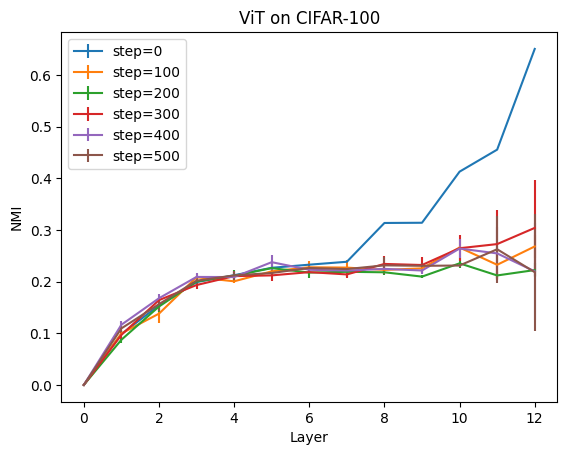

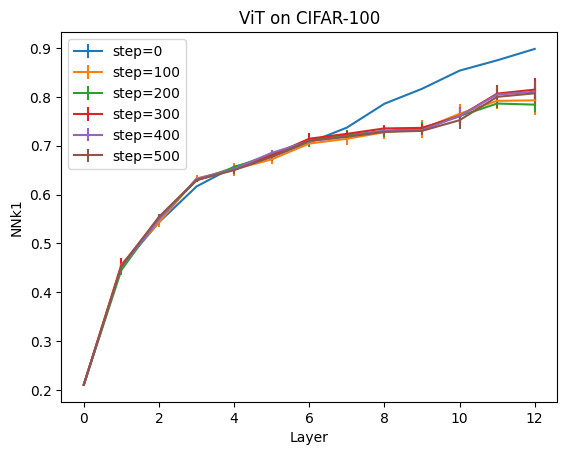

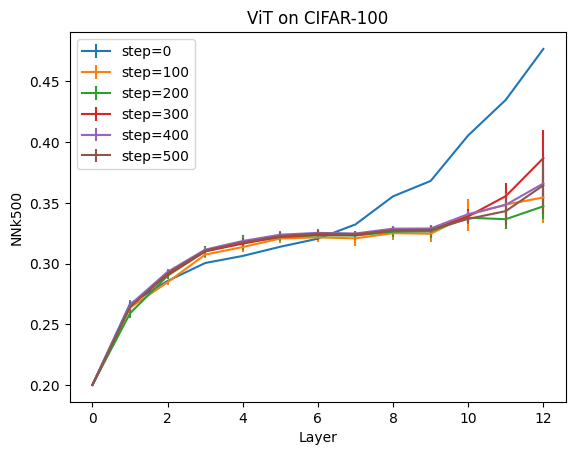

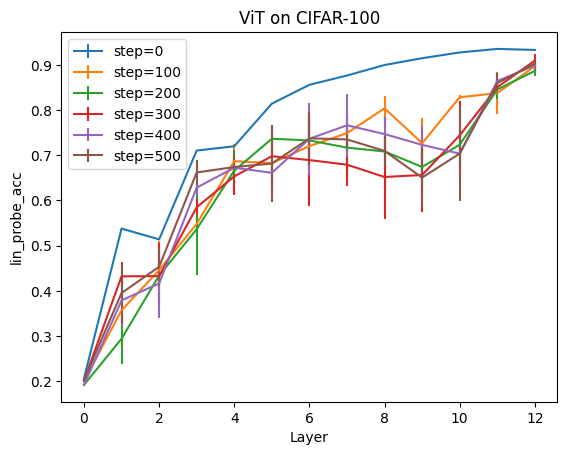

In [ ]:
# [ResNet, ViT, Swin, PViT, CvT, PoolFormer, ConvNeXtV2]
run_trials(newViT, cifar, 3)

preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/71.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([95, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=Tru


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.03 NNk1=0.27 NNk500=0.22 lin_probe_acc=0.27 
UNSEEN step 0: L1: NMI=0.01 NNk1=0.26 NNk500=0.21 lin_probe_acc=0.29 
UNSEEN step 0: L2: NMI=0.01 NNk1=0.25 NNk500=0.21 lin_probe_acc=0.30 
UNSEEN step 0: L3: NMI=0.00 NNk1=0.31 NNk500=0.20 lin_probe_acc=0.31 
UNSEEN step 0: L4: NMI=0.00 NNk1=0.36 NNk500=0.21 lin_probe_acc=0.45 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.20 NNk1=0.10 NNk500=0.06 lin_probe_acc=0.06 
SEEN step 0: L1: NMI=0.19 NNk1=0.12 NNk500=0.06 lin_probe_acc=0.10 
SEEN step 0: L2: NMI=0.18 NNk1=0.12 NNk500=0.06 lin_probe_acc=0.12 
SEEN step 0: L3: NMI=0.13 NNk1=0.14 NNk500=0.05 lin_probe_acc=0.18 
SEEN step 0: L4: NMI=0.20 NNk1=0.38 NNk500=0.06 lin_probe_acc=0.51 


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.03 NNk1=0.26 NNk500=0.22 lin_probe_acc=0.27 
UNSEEN step 100: L1: NMI=0.03 NNk1=0.27 NNk500=0.22 lin_probe_acc=0.33 
UNSEEN step 100: L2: NMI=0.04 NNk1=0.27 NNk500=0.22 lin_probe_acc=0.35 
UNSEEN step 100: L3: NMI=0.01 NNk1=0.33 NNk500=0.21 lin_probe_acc=0.24 
UNSEEN step 100: L4: NMI=0.01 NNk1=0.61 NNk500=0.25 lin_probe_acc=0.74 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.20 NNk1=0.10 NNk500=0.06 lin_probe_acc=0.08 
SEEN step 100: L1: NMI=0.19 NNk1=0.12 NNk500=0.06 lin_probe_acc=0.10 
SEEN step 100: L2: NMI=0.20 NNk1=0.14 NNk500=0.06 lin_probe_acc=0.12 
SEEN step 100: L3: NMI=0.13 NNk1=0.22 NNk500=0.06 lin_probe_acc=0.11 
SEEN step 100: L4: NMI=0.64 NNk1=0.82 NNk500=0.13 lin_probe_acc=0.85 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([95, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.03 NNk1=0.27 NNk500=0.22 lin_probe_acc=0.27 
UNSEEN step 0: L1: NMI=0.01 NNk1=0.26 NNk500=0.21 lin_probe_acc=0.29 
UNSEEN step 0: L2: NMI=0.01 NNk1=0.25 NNk500=0.21 lin_probe_acc=0.30 
UNSEEN step 0: L3: NMI=0.00 NNk1=0.31 NNk500=0.20 lin_probe_acc=0.31 
UNSEEN step 0: L4: NMI=0.00 NNk1=0.36 NNk500=0.21 lin_probe_acc=0.45 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.20 NNk1=0.10 NNk500=0.06 lin_probe_acc=0.06 
SEEN step 0: L1: NMI=0.19 NNk1=0.12 NNk500=0.06 lin_probe_acc=0.10 
SEEN step 0: L2: NMI=0.18 NNk1=0.12 NNk500=0.06 lin_probe_acc=0.12 
SEEN step 0: L3: NMI=0.13 NNk1=0.14 NNk500=0.05 lin_probe_acc=0.18 
SEEN step 0: L4: NMI=0.20 NNk1=0.38 NNk500=0.06 lin_probe_acc=0.51 


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.04 NNk1=0.27 NNk500=0.22 lin_probe_acc=0.23 
UNSEEN step 100: L1: NMI=0.02 NNk1=0.27 NNk500=0.21 lin_probe_acc=0.31 
UNSEEN step 100: L2: NMI=0.03 NNk1=0.28 NNk500=0.21 lin_probe_acc=0.36 
UNSEEN step 100: L3: NMI=0.01 NNk1=0.32 NNk500=0.21 lin_probe_acc=0.27 
UNSEEN step 100: L4: NMI=0.01 NNk1=0.60 NNk500=0.24 lin_probe_acc=0.73 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.20 NNk1=0.09 NNk500=0.06 lin_probe_acc=0.09 
SEEN step 100: L1: NMI=0.19 NNk1=0.12 NNk500=0.06 lin_probe_acc=0.10 
SEEN step 100: L2: NMI=0.20 NNk1=0.14 NNk500=0.06 lin_probe_acc=0.13 
SEEN step 100: L3: NMI=0.14 NNk1=0.20 NNk500=0.06 lin_probe_acc=0.18 
SEEN step 100: L4: NMI=0.52 NNk1=0.81 NNk500=0.10 lin_probe_acc=0.86 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 

Checkpoint destination directory ./Trainers/Swin_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 928363980GF
  train_loss               =      0.2712
  train_runtime            =  0:10:40.83
  train_samples_per_second =      62.418
  train_steps_per_second   =       0.868


Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([95, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=Tru


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.03 NNk1=0.27 NNk500=0.22 lin_probe_acc=0.27 
UNSEEN step 0: L1: NMI=0.01 NNk1=0.26 NNk500=0.21 lin_probe_acc=0.29 
UNSEEN step 0: L2: NMI=0.01 NNk1=0.25 NNk500=0.21 lin_probe_acc=0.30 
UNSEEN step 0: L3: NMI=0.00 NNk1=0.31 NNk500=0.20 lin_probe_acc=0.31 
UNSEEN step 0: L4: NMI=0.00 NNk1=0.36 NNk500=0.21 lin_probe_acc=0.45 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.20 NNk1=0.10 NNk500=0.06 lin_probe_acc=0.06 
SEEN step 0: L1: NMI=0.19 NNk1=0.12 NNk500=0.06 lin_probe_acc=0.10 
SEEN step 0: L2: NMI=0.18 NNk1=0.12 NNk500=0.06 lin_probe_acc=0.12 
SEEN step 0: L3: NMI=0.13 NNk1=0.14 NNk500=0.05 lin_probe_acc=0.18 
SEEN step 0: L4: NMI=0.20 NNk1=0.38 NNk500=0.06 lin_probe_acc=0.51 


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.04 NNk1=0.26 NNk500=0.22 lin_probe_acc=0.27 
UNSEEN step 100: L1: NMI=0.02 NNk1=0.26 NNk500=0.21 lin_probe_acc=0.28 
UNSEEN step 100: L2: NMI=0.03 NNk1=0.28 NNk500=0.22 lin_probe_acc=0.37 
UNSEEN step 100: L3: NMI=0.01 NNk1=0.32 NNk500=0.20 lin_probe_acc=0.31 
UNSEEN step 100: L4: NMI=0.01 NNk1=0.59 NNk500=0.25 lin_probe_acc=0.59 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.20 NNk1=0.09 NNk500=0.06 lin_probe_acc=0.08 
SEEN step 100: L1: NMI=0.20 NNk1=0.12 NNk500=0.06 lin_probe_acc=0.12 
SEEN step 100: L2: NMI=0.20 NNk1=0.13 NNk500=0.07 lin_probe_acc=0.12 
SEEN step 100: L3: NMI=0.13 NNk1=0.22 NNk500=0.06 lin_probe_acc=0.15 
SEEN step 100: L4: NMI=0.61 NNk1=0.81 NNk500=0.12 lin_probe_acc=0.86 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 

Checkpoint destination directory ./Trainers/Swin_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 928363980GF
  train_loss               =       0.259
  train_runtime            =  0:10:36.18
  train_samples_per_second =      62.874
  train_steps_per_second   =       0.874
6


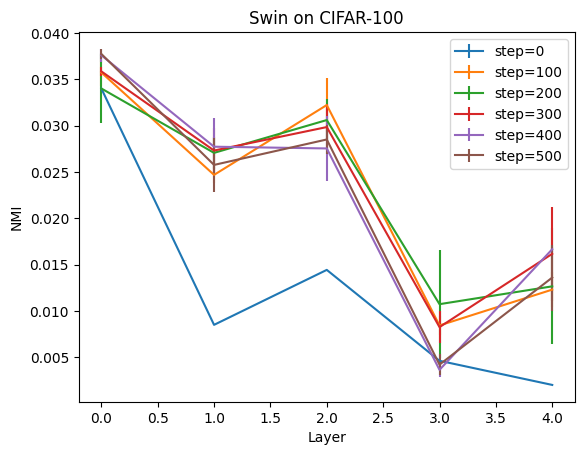

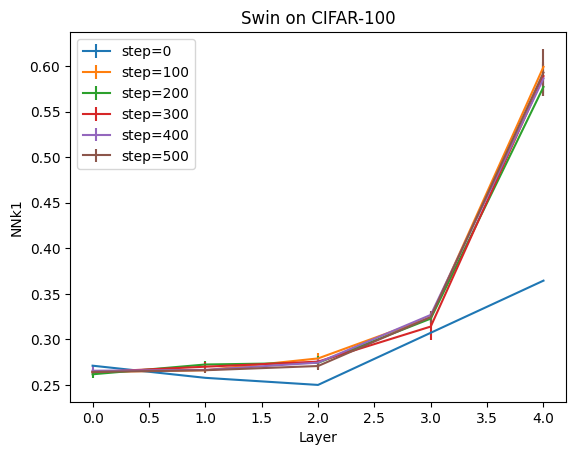

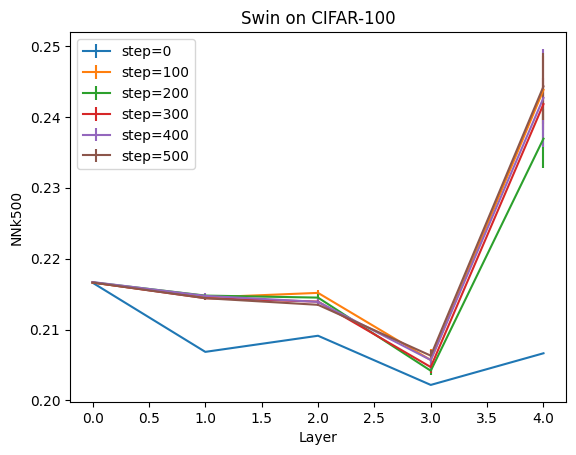

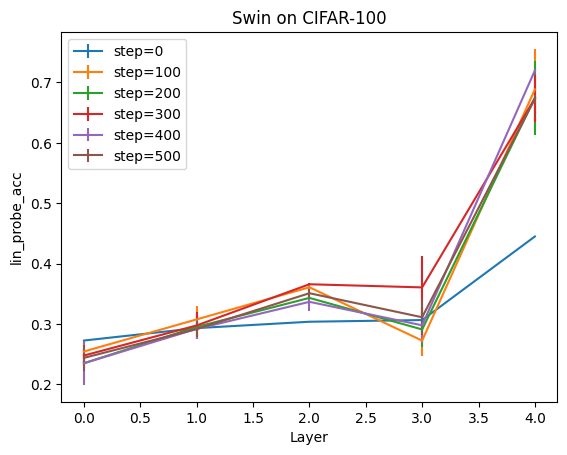

In [ ]:
run_trials(newSwin, cifar, 3)

preprocessor_config.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/52.9M [00:00<?, ?B/s]

Some weights of PvtForImageClassification were not initialized from the model checkpoint at Zetatech/pvt-tiny-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([95, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sa


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.03 NNk1=0.31 NNk500=0.22 lin_probe_acc=0.31 
UNSEEN step 0: L1: NMI=0.02 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.34 
UNSEEN step 0: L2: NMI=0.02 NNk1=0.30 NNk500=0.21 lin_probe_acc=0.36 
UNSEEN step 0: L3: NMI=0.02 NNk1=0.28 NNk500=0.21 lin_probe_acc=0.42 
UNSEEN step 0: L4: NMI=0.02 NNk1=0.29 NNk500=0.21 lin_probe_acc=0.51 
UNSEEN step 0: L5: NMI=0.03 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.50 
UNSEEN step 0: L6: NMI=0.28 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.79 
UNSEEN step 0: L7: NMI=0.23 NNk1=0.70 NNk500=0.30 lin_probe_acc=0.79 
UNSEEN step 0: L8: NMI=0.25 NNk1=0.70 NNk500=0.31 lin_probe_acc=0.79 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.19 NNk1=0.14 NNk500=0.06 lin_probe_acc=0.12 
SEEN step 0: L1: NMI=0.20 NNk1=0.15 NNk500=


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.02 NNk1=0.31 NNk500=0.22 lin_probe_acc=0.25 
UNSEEN step 100: L1: NMI=0.02 NNk1=0.32 NNk500=0.21 lin_probe_acc=0.36 
UNSEEN step 100: L2: NMI=0.02 NNk1=0.30 NNk500=0.21 lin_probe_acc=0.39 
UNSEEN step 100: L3: NMI=0.02 NNk1=0.29 NNk500=0.21 lin_probe_acc=0.39 
UNSEEN step 100: L4: NMI=0.03 NNk1=0.30 NNk500=0.21 lin_probe_acc=0.51 
UNSEEN step 100: L5: NMI=0.04 NNk1=0.32 NNk500=0.22 lin_probe_acc=0.54 
UNSEEN step 100: L6: NMI=0.21 NNk1=0.74 NNk500=0.34 lin_probe_acc=0.79 
UNSEEN step 100: L7: NMI=0.17 NNk1=0.69 NNk500=0.31 lin_probe_acc=0.81 
UNSEEN step 100: L8: NMI=0.18 NNk1=0.69 NNk500=0.31 lin_probe_acc=0.80 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.20 NNk1=0.12 NNk500=0.06 lin_probe_acc=0.12 
SEEN step 100: L1: NMI=

Some weights of PvtForImageClassification were not initialized from the model checkpoint at Zetatech/pvt-tiny-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([95, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sa


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.03 NNk1=0.31 NNk500=0.22 lin_probe_acc=0.31 
UNSEEN step 0: L1: NMI=0.02 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.34 
UNSEEN step 0: L2: NMI=0.02 NNk1=0.30 NNk500=0.21 lin_probe_acc=0.36 
UNSEEN step 0: L3: NMI=0.02 NNk1=0.28 NNk500=0.21 lin_probe_acc=0.42 
UNSEEN step 0: L4: NMI=0.02 NNk1=0.29 NNk500=0.21 lin_probe_acc=0.51 
UNSEEN step 0: L5: NMI=0.03 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.50 
UNSEEN step 0: L6: NMI=0.28 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.79 
UNSEEN step 0: L7: NMI=0.23 NNk1=0.70 NNk500=0.30 lin_probe_acc=0.79 
UNSEEN step 0: L8: NMI=0.25 NNk1=0.70 NNk500=0.31 lin_probe_acc=0.79 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.19 NNk1=0.14 NNk500=0.06 lin_probe_acc=0.12 
SEEN step 0: L1: NMI=0.20 NNk1=0.15 NNk500=


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.03 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.31 
UNSEEN step 100: L1: NMI=0.02 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.34 
UNSEEN step 100: L2: NMI=0.02 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.35 
UNSEEN step 100: L3: NMI=0.02 NNk1=0.30 NNk500=0.21 lin_probe_acc=0.39 
UNSEEN step 100: L4: NMI=0.02 NNk1=0.30 NNk500=0.21 lin_probe_acc=0.50 
UNSEEN step 100: L5: NMI=0.02 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.55 
UNSEEN step 100: L6: NMI=0.22 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.83 
UNSEEN step 100: L7: NMI=0.17 NNk1=0.69 NNk500=0.30 lin_probe_acc=0.80 
UNSEEN step 100: L8: NMI=0.12 NNk1=0.69 NNk500=0.30 lin_probe_acc=0.80 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.20 NNk1=0.13 NNk500=0.06 lin_probe_acc=0.12 
SEEN step 100: L1: NMI=

Checkpoint destination directory ./Trainers/PViT_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 429487239GF
  train_loss               =      0.3085
  train_runtime            =  0:09:22.66
  train_samples_per_second =       71.09
  train_steps_per_second   =       0.988


Some weights of PvtForImageClassification were not initialized from the model checkpoint at Zetatech/pvt-tiny-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([95, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sa


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.03 NNk1=0.31 NNk500=0.22 lin_probe_acc=0.31 
UNSEEN step 0: L1: NMI=0.02 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.34 
UNSEEN step 0: L2: NMI=0.02 NNk1=0.30 NNk500=0.21 lin_probe_acc=0.36 
UNSEEN step 0: L3: NMI=0.02 NNk1=0.28 NNk500=0.21 lin_probe_acc=0.42 
UNSEEN step 0: L4: NMI=0.02 NNk1=0.29 NNk500=0.21 lin_probe_acc=0.51 
UNSEEN step 0: L5: NMI=0.03 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.50 
UNSEEN step 0: L6: NMI=0.28 NNk1=0.73 NNk500=0.33 lin_probe_acc=0.79 
UNSEEN step 0: L7: NMI=0.23 NNk1=0.70 NNk500=0.30 lin_probe_acc=0.79 
UNSEEN step 0: L8: NMI=0.25 NNk1=0.70 NNk500=0.31 lin_probe_acc=0.79 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.19 NNk1=0.14 NNk500=0.06 lin_probe_acc=0.12 
SEEN step 0: L1: NMI=0.20 NNk1=0.15 NNk500=


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.02 NNk1=0.30 NNk500=0.22 lin_probe_acc=0.30 
UNSEEN step 100: L1: NMI=0.02 NNk1=0.31 NNk500=0.21 lin_probe_acc=0.33 
UNSEEN step 100: L2: NMI=0.02 NNk1=0.30 NNk500=0.21 lin_probe_acc=0.34 
UNSEEN step 100: L3: NMI=0.01 NNk1=0.29 NNk500=0.21 lin_probe_acc=0.42 
UNSEEN step 100: L4: NMI=0.02 NNk1=0.29 NNk500=0.21 lin_probe_acc=0.51 
UNSEEN step 100: L5: NMI=0.04 NNk1=0.32 NNk500=0.22 lin_probe_acc=0.53 
UNSEEN step 100: L6: NMI=0.24 NNk1=0.74 NNk500=0.34 lin_probe_acc=0.82 
UNSEEN step 100: L7: NMI=0.20 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.81 
UNSEEN step 100: L8: NMI=0.21 NNk1=0.70 NNk500=0.32 lin_probe_acc=0.82 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.20 NNk1=0.13 NNk500=0.06 lin_probe_acc=0.11 
SEEN step 100: L1: NMI=

Checkpoint destination directory ./Trainers/PViT_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 429487239GF
  train_loss               =      0.3017
  train_runtime            =  0:09:23.66
  train_samples_per_second =      70.964
  train_steps_per_second   =       0.986
6


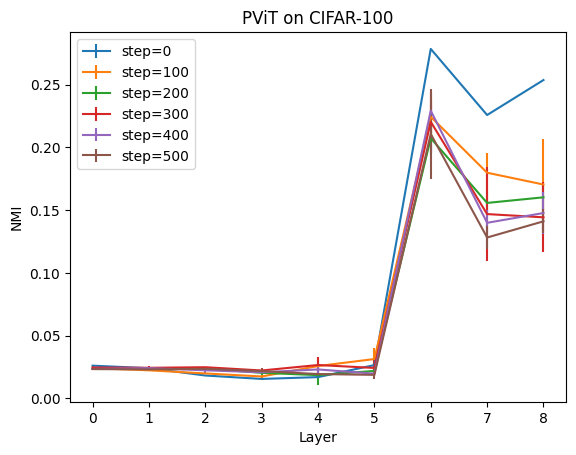

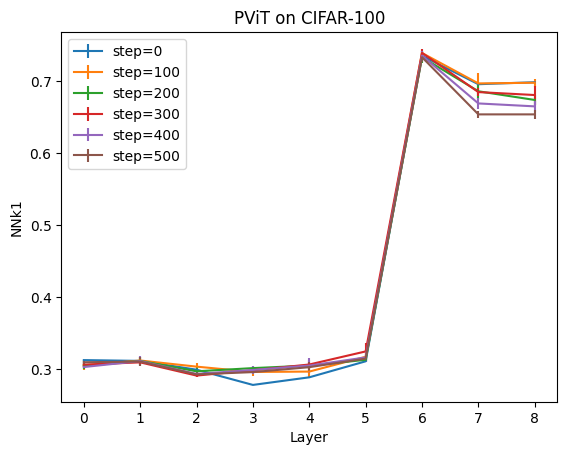

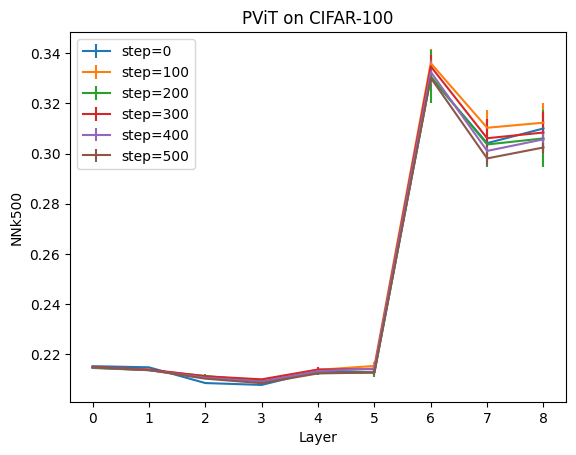

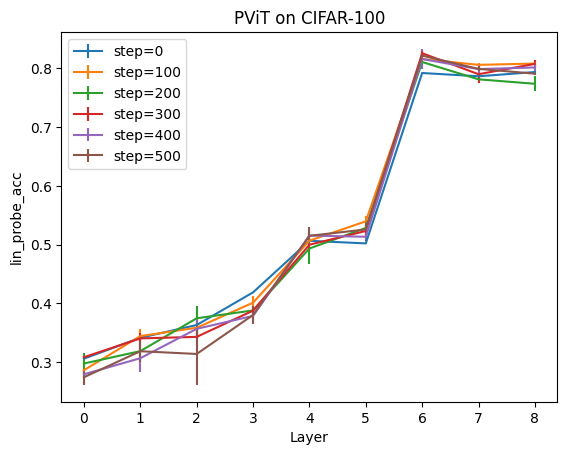

In [ ]:
run_trials(newPViT, cifar, 3)

preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/70.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/127M [00:00<?, ?B/s]

Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([95, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.08 NNk1=0.43 NNk500=0.25 lin_probe_acc=0.43 
UNSEEN step 0: L1: NMI=0.07 NNk1=0.48 NNk500=0.25 lin_probe_acc=0.52 
UNSEEN step 0: L2: NMI=0.01 NNk1=0.40 NNk500=0.23 lin_probe_acc=0.48 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.26 NNk1=0.23 NNk500=0.08 lin_probe_acc=0.28 
SEEN step 0: L1: NMI=0.30 NNk1=0.35 NNk500=0.09 lin_probe_acc=0.41 
SEEN step 0: L2: NMI=0.28 NNk1=0.32 NNk500=0.08 lin_probe_acc=0.47 


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.04 NNk1=0.44 NNk500=0.24 lin_probe_acc=0.45 
UNSEEN step 100: L1: NMI=0.09 NNk1=0.55 NNk500=0.27 lin_probe_acc=0.57 
UNSEEN step 100: L2: NMI=0.23 NNk1=0.68 NNk500=0.32 lin_probe_acc=0.77 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.24 NNk1=0.24 NNk500=0.07 lin_probe_acc=0.33 
SEEN step 100: L1: NMI=0.31 NNk1=0.37 NNk500=0.09 lin_probe_acc=0.46 
SEEN step 100: L2: NMI=0.71 NNk1=0.88 NNk500=0.19 lin_probe_acc=0.89 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 139: L0: NMI=0.06 NNk1=0.43 NNk500=0.25 lin_probe_acc=0.52 
UNSEEN step 139: L1: NMI=0.09 NNk1=0.53 NNk500=0.27 lin_probe_acc=0.66 
UNSEEN step 139: L2: NMI=0.10 NNk1=0.55 NNk500=0.26 lin_probe_acc=0.64 
0
0 1 2 3 4 5

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([95, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is de


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.08 NNk1=0.43 NNk500=0.25 lin_probe_acc=0.43 
UNSEEN step 0: L1: NMI=0.07 NNk1=0.48 NNk500=0.25 lin_probe_acc=0.52 
UNSEEN step 0: L2: NMI=0.01 NNk1=0.40 NNk500=0.23 lin_probe_acc=0.48 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.26 NNk1=0.23 NNk500=0.08 lin_probe_acc=0.28 
SEEN step 0: L1: NMI=0.30 NNk1=0.35 NNk500=0.09 lin_probe_acc=0.41 
SEEN step 0: L2: NMI=0.28 NNk1=0.32 NNk500=0.08 lin_probe_acc=0.47 


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.04 NNk1=0.47 NNk500=0.24 lin_probe_acc=0.54 
UNSEEN step 100: L1: NMI=0.09 NNk1=0.52 NNk500=0.27 lin_probe_acc=0.63 
UNSEEN step 100: L2: NMI=0.11 NNk1=0.67 NNk500=0.28 lin_probe_acc=0.78 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.25 NNk1=0.24 NNk500=0.07 lin_probe_acc=0.24 
SEEN step 100: L1: NMI=0.32 NNk1=0.37 NNk500=0.09 lin_probe_acc=0.50 
SEEN step 100: L2: NMI=0.71 NNk1=0.88 NNk500=0.19 lin_probe_acc=0.90 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 139: L0: NMI=0.06 NNk1=0.42 NNk500=0.24 lin_probe_acc=0.45 
UNSEEN step 139: L1: NMI=0.10 NNk1=0.52 NNk500=0.27 lin_probe_acc=0.58 
UNSEEN step 139: L2: NMI=0.07 NNk1=0.56 NNk500=0.26 lin_probe_acc=0.64 
1
0 1 2 3 4 5

Checkpoint destination directory ./Trainers/CvT_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1052242546GF
  train_loss               =       0.9074
  train_runtime            =   0:09:20.33
  train_samples_per_second =       71.386
  train_steps_per_second   =        0.992


Some weights of CvtForImageClassification were not initialized from the model checkpoint at microsoft/cvt-21 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 384]) in the checkpoint and torch.Size([95, 384]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.08 NNk1=0.43 NNk500=0.25 lin_probe_acc=0.43 
UNSEEN step 0: L1: NMI=0.07 NNk1=0.48 NNk500=0.25 lin_probe_acc=0.52 
UNSEEN step 0: L2: NMI=0.01 NNk1=0.40 NNk500=0.23 lin_probe_acc=0.48 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.26 NNk1=0.23 NNk500=0.08 lin_probe_acc=0.28 
SEEN step 0: L1: NMI=0.30 NNk1=0.35 NNk500=0.09 lin_probe_acc=0.41 
SEEN step 0: L2: NMI=0.28 NNk1=0.32 NNk500=0.08 lin_probe_acc=0.47 


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.04 NNk1=0.46 NNk500=0.24 lin_probe_acc=0.53 
UNSEEN step 100: L1: NMI=0.09 NNk1=0.53 NNk500=0.27 lin_probe_acc=0.62 
UNSEEN step 100: L2: NMI=0.17 NNk1=0.68 NNk500=0.31 lin_probe_acc=0.81 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.24 NNk1=0.25 NNk500=0.07 lin_probe_acc=0.28 
SEEN step 100: L1: NMI=0.32 NNk1=0.37 NNk500=0.09 lin_probe_acc=0.47 
SEEN step 100: L2: NMI=0.71 NNk1=0.88 NNk500=0.19 lin_probe_acc=0.89 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 139: L0: NMI=0.07 NNk1=0.46 NNk500=0.24 lin_probe_acc=0.50 
UNSEEN step 139: L1: NMI=0.10 NNk1=0.54 NNk500=0.27 lin_probe_acc=0.68 
UNSEEN step 139: L2: NMI=0.09 NNk1=0.55 NNk500=0.27 lin_probe_acc=0.64 
2
0 1 2 3 4 5

Checkpoint destination directory ./Trainers/CvT_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =          4.0
  total_flos               = 1052242546GF
  train_loss               =       0.8922
  train_runtime            =   0:09:16.05
  train_samples_per_second =       71.935
  train_steps_per_second   =          1.0
6


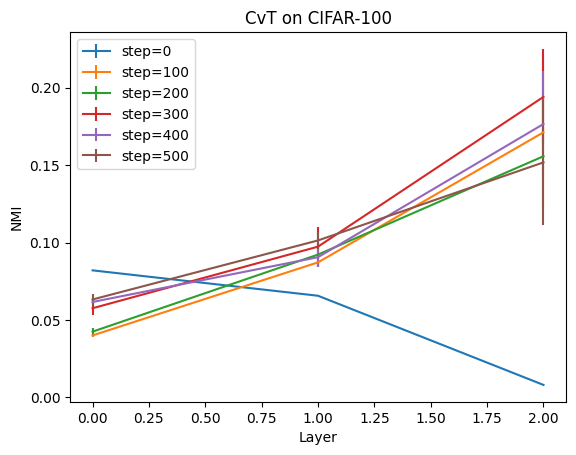

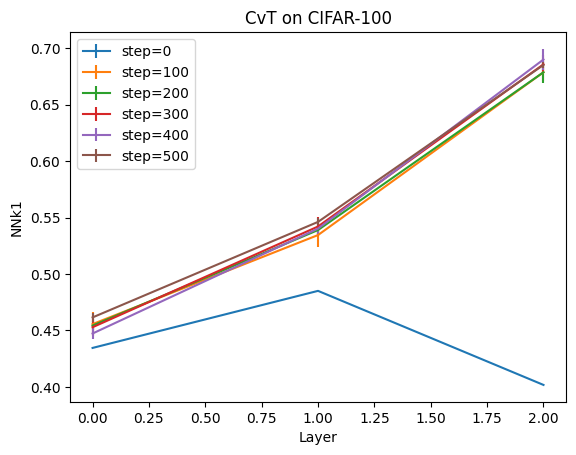

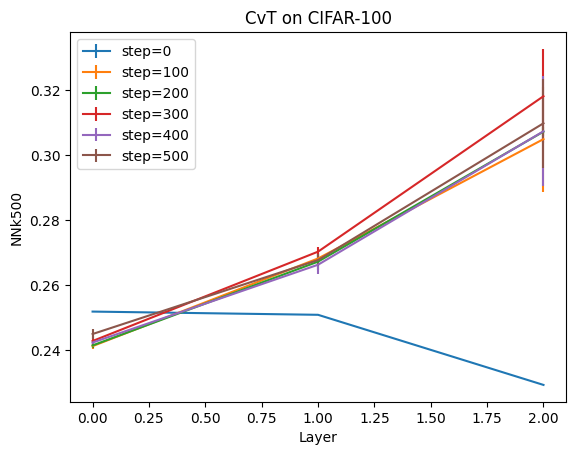

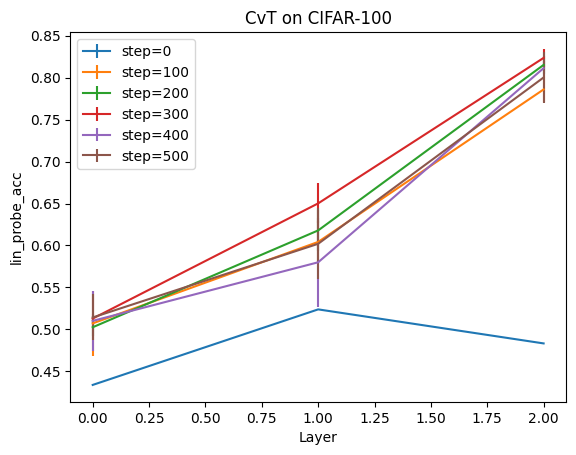

In [ ]:
run_trials(newCvT, cifar, 3)

preprocessor_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


config.json:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.7M [00:00<?, ?B/s]

Some weights of PoolFormerForImageClassification were not initialized from the model checkpoint at sail/poolformer_s12 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([95, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedab


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.06 NNk1=0.40 NNk500=0.24 lin_probe_acc=0.52 
UNSEEN step 0: L1: NMI=0.09 NNk1=0.50 NNk500=0.26 lin_probe_acc=0.55 
UNSEEN step 0: L2: NMI=0.23 NNk1=0.69 NNk500=0.31 lin_probe_acc=0.80 
UNSEEN step 0: L3: NMI=0.07 NNk1=0.66 NNk500=0.28 lin_probe_acc=0.79 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.25 NNk1=0.22 NNk500=0.08 lin_probe_acc=0.21 
SEEN step 0: L1: NMI=0.29 NNk1=0.31 NNk500=0.08 lin_probe_acc=0.40 
SEEN step 0: L2: NMI=0.53 NNk1=0.66 NNk500=0.13 lin_probe_acc=0.79 
SEEN step 0: L3: NMI=0.55 NNk1=0.73 NNk500=0.13 lin_probe_acc=0.84 


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.07 NNk1=0.42 NNk500=0.25 lin_probe_acc=0.49 
UNSEEN step 100: L1: NMI=0.08 NNk1=0.50 NNk500=0.26 lin_probe_acc=0.55 
UNSEEN step 100: L2: NMI=0.25 NNk1=0.75 NNk500=0.33 lin_probe_acc=0.81 
UNSEEN step 100: L3: NMI=0.16 NNk1=0.71 NNk500=0.31 lin_probe_acc=0.84 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.25 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.18 
SEEN step 100: L1: NMI=0.28 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.45 
SEEN step 100: L2: NMI=0.61 NNk1=0.75 NNk500=0.17 lin_probe_acc=0.85 
SEEN step 100: L3: NMI=0.68 NNk1=0.83 NNk500=0.19 lin_probe_acc=0.87 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 139: L0: NMI=0.07 NNk1=0.42 NNk500=0.25 lin_probe_acc=0.42 
UNSEEN step 139

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of PoolFormerForImageClassification were not initialized from the model checkpoint at sail/poolformer_s12 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([95, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelera


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.06 NNk1=0.40 NNk500=0.24 lin_probe_acc=0.52 
UNSEEN step 0: L1: NMI=0.09 NNk1=0.50 NNk500=0.26 lin_probe_acc=0.55 
UNSEEN step 0: L2: NMI=0.23 NNk1=0.69 NNk500=0.31 lin_probe_acc=0.80 
UNSEEN step 0: L3: NMI=0.07 NNk1=0.66 NNk500=0.28 lin_probe_acc=0.79 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.25 NNk1=0.22 NNk500=0.08 lin_probe_acc=0.21 
SEEN step 0: L1: NMI=0.29 NNk1=0.31 NNk500=0.08 lin_probe_acc=0.40 
SEEN step 0: L2: NMI=0.53 NNk1=0.66 NNk500=0.13 lin_probe_acc=0.79 
SEEN step 0: L3: NMI=0.55 NNk1=0.73 NNk500=0.13 lin_probe_acc=0.84 


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.07 NNk1=0.41 NNk500=0.25 lin_probe_acc=0.44 
UNSEEN step 100: L1: NMI=0.08 NNk1=0.49 NNk500=0.26 lin_probe_acc=0.56 
UNSEEN step 100: L2: NMI=0.19 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.81 
UNSEEN step 100: L3: NMI=0.13 NNk1=0.68 NNk500=0.29 lin_probe_acc=0.79 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.25 NNk1=0.23 NNk500=0.07 lin_probe_acc=0.25 
SEEN step 100: L1: NMI=0.28 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.42 
SEEN step 100: L2: NMI=0.60 NNk1=0.74 NNk500=0.17 lin_probe_acc=0.84 
SEEN step 100: L3: NMI=0.67 NNk1=0.82 NNk500=0.19 lin_probe_acc=0.86 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 139: L0: NMI=0.09 NNk1=0.41 NNk500=0.25 lin_probe_acc=0.47 
UNSEEN step 139

Checkpoint destination directory ./Trainers/PoolFormer_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 385273113GF
  train_loss               =      0.3761
  train_runtime            =  0:06:32.05
  train_samples_per_second =     102.026
  train_steps_per_second   =       1.418


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of PoolFormerForImageClassification were not initialized from the model checkpoint at sail/poolformer_s12 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([95, 512]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelera


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.06 NNk1=0.40 NNk500=0.24 lin_probe_acc=0.52 
UNSEEN step 0: L1: NMI=0.09 NNk1=0.50 NNk500=0.26 lin_probe_acc=0.55 
UNSEEN step 0: L2: NMI=0.23 NNk1=0.69 NNk500=0.31 lin_probe_acc=0.80 
UNSEEN step 0: L3: NMI=0.07 NNk1=0.66 NNk500=0.28 lin_probe_acc=0.79 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.25 NNk1=0.22 NNk500=0.08 lin_probe_acc=0.21 
SEEN step 0: L1: NMI=0.29 NNk1=0.31 NNk500=0.08 lin_probe_acc=0.40 
SEEN step 0: L2: NMI=0.53 NNk1=0.66 NNk500=0.13 lin_probe_acc=0.79 
SEEN step 0: L3: NMI=0.55 NNk1=0.73 NNk500=0.13 lin_probe_acc=0.84 


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.07 NNk1=0.40 NNk500=0.25 lin_probe_acc=0.49 
UNSEEN step 100: L1: NMI=0.10 NNk1=0.49 NNk500=0.26 lin_probe_acc=0.59 
UNSEEN step 100: L2: NMI=0.19 NNk1=0.72 NNk500=0.32 lin_probe_acc=0.79 
UNSEEN step 100: L3: NMI=0.13 NNk1=0.66 NNk500=0.30 lin_probe_acc=0.81 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.25 NNk1=0.22 NNk500=0.07 lin_probe_acc=0.27 
SEEN step 100: L1: NMI=0.28 NNk1=0.30 NNk500=0.08 lin_probe_acc=0.44 
SEEN step 100: L2: NMI=0.62 NNk1=0.75 NNk500=0.17 lin_probe_acc=0.83 
SEEN step 100: L3: NMI=0.68 NNk1=0.84 NNk500=0.19 lin_probe_acc=0.88 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 139: L0: NMI=0.09 NNk1=0.43 NNk500=0.25 lin_probe_acc=0.52 
UNSEEN step 139

Checkpoint destination directory ./Trainers/PoolFormer_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 385273113GF
  train_loss               =      0.3631
  train_runtime            =  0:06:25.70
  train_samples_per_second =     103.707
  train_steps_per_second   =       1.442
6


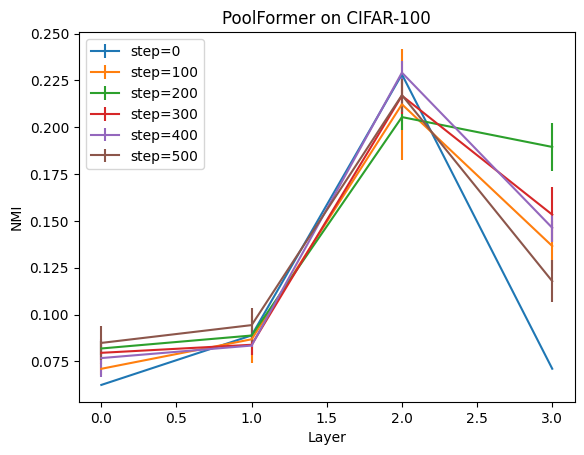

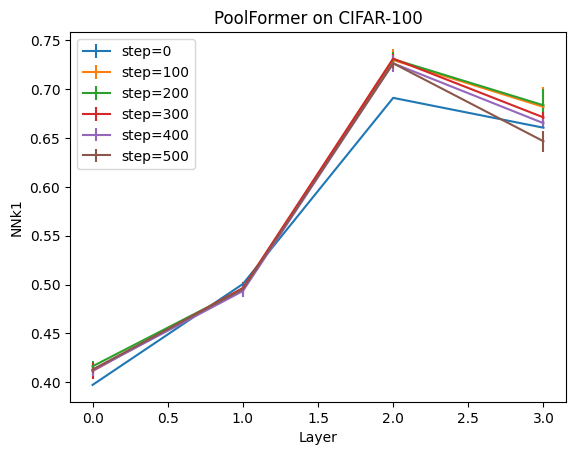

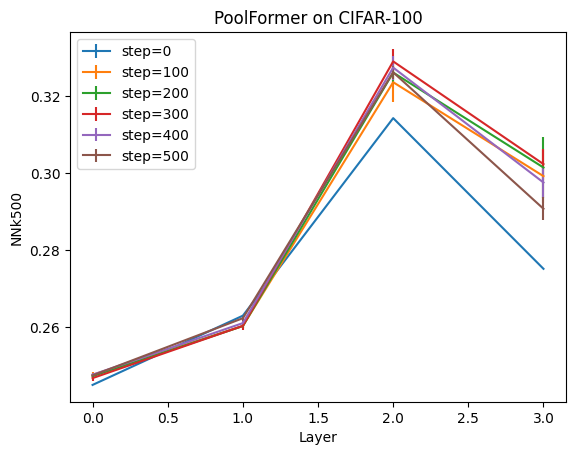

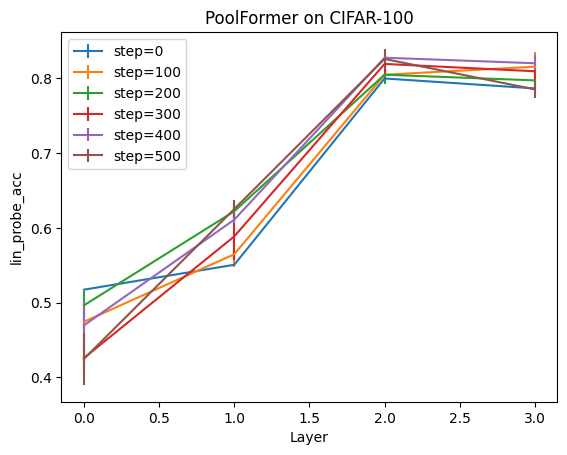

In [ ]:
run_trials(newPoolFormer, cifar, 3)

preprocessor_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([95, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.09 NNk1=0.34 NNk500=0.25 lin_probe_acc=0.31 
UNSEEN step 0: L1: NMI=0.08 NNk1=0.47 NNk500=0.25 lin_probe_acc=0.43 
UNSEEN step 0: L2: NMI=0.01 NNk1=0.51 NNk500=0.24 lin_probe_acc=0.43 
UNSEEN step 0: L3: NMI=0.02 NNk1=0.58 NNk500=0.21 lin_probe_acc=0.54 
UNSEEN step 0: L4: NMI=0.15 NNk1=0.68 NNk500=0.29 lin_probe_acc=0.82 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.22 NNk1=0.15 NNk500=0.07 lin_probe_acc=0.08 
SEEN step 0: L1: NMI=0.26 NNk1=0.27 NNk500=0.08 lin_probe_acc=0.24 
SEEN step 0: L2: NMI=0.28 NNk1=0.34 NNk500=0.07 lin_probe_acc=0.29 
SEEN step 0: L3: NMI=0.28 NNk1=0.54 NNk500=0.06 lin_probe_acc=0.33 
SEEN step 0: L4: NMI=0.64 NNk1=0.82 NNk500=0.15 lin_probe_acc=0.88 


0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.08 NNk1=0.34 NNk500=0.25 lin_probe_acc=0.21 
UNSEEN step 100: L1: NMI=0.07 NNk1=0.46 NNk500=0.25 lin_probe_acc=0.26 
UNSEEN step 100: L2: NMI=0.05 NNk1=0.50 NNk500=0.24 lin_probe_acc=0.46 
UNSEEN step 100: L3: NMI=0.02 NNk1=0.50 NNk500=0.21 lin_probe_acc=0.37 
UNSEEN step 100: L4: NMI=0.11 NNk1=0.69 NNk500=0.30 lin_probe_acc=0.81 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.22 NNk1=0.14 NNk500=0.07 lin_probe_acc=0.15 
SEEN step 100: L1: NMI=0.25 NNk1=0.24 NNk500=0.07 lin_probe_acc=0.22 
SEEN step 100: L2: NMI=0.28 NNk1=0.34 NNk500=0.07 lin_probe_acc=0.27 
SEEN step 100: L3: NMI=0.31 NNk1=0.68 NNk500=0.07 lin_probe_acc=0.59 
SEEN step 100: L4: NMI=0.76 NNk1=0.91 NNk500=0.19 lin_probe_acc=0.93 
0
0 1 2 3 4 5 6 7 8 9 10 11 12 

Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([95, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.09 NNk1=0.34 NNk500=0.25 lin_probe_acc=0.31 
UNSEEN step 0: L1: NMI=0.08 NNk1=0.47 NNk500=0.25 lin_probe_acc=0.43 
UNSEEN step 0: L2: NMI=0.01 NNk1=0.51 NNk500=0.24 lin_probe_acc=0.43 
UNSEEN step 0: L3: NMI=0.02 NNk1=0.58 NNk500=0.21 lin_probe_acc=0.54 
UNSEEN step 0: L4: NMI=0.15 NNk1=0.68 NNk500=0.29 lin_probe_acc=0.82 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.22 NNk1=0.15 NNk500=0.07 lin_probe_acc=0.08 
SEEN step 0: L1: NMI=0.26 NNk1=0.27 NNk500=0.08 lin_probe_acc=0.24 
SEEN step 0: L2: NMI=0.28 NNk1=0.34 NNk500=0.07 lin_probe_acc=0.29 
SEEN step 0: L3: NMI=0.28 NNk1=0.54 NNk500=0.06 lin_probe_acc=0.33 
SEEN step 0: L4: NMI=0.64 NNk1=0.82 NNk500=0.15 lin_probe_acc=0.88 


1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.08 NNk1=0.34 NNk500=0.25 lin_probe_acc=0.30 
UNSEEN step 100: L1: NMI=0.08 NNk1=0.48 NNk500=0.25 lin_probe_acc=0.33 
UNSEEN step 100: L2: NMI=0.01 NNk1=0.48 NNk500=0.24 lin_probe_acc=0.44 
UNSEEN step 100: L3: NMI=0.02 NNk1=0.52 NNk500=0.21 lin_probe_acc=0.57 
UNSEEN step 100: L4: NMI=0.14 NNk1=0.66 NNk500=0.30 lin_probe_acc=0.82 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.22 NNk1=0.15 NNk500=0.07 lin_probe_acc=0.13 
SEEN step 100: L1: NMI=0.24 NNk1=0.26 NNk500=0.08 lin_probe_acc=0.22 
SEEN step 100: L2: NMI=0.28 NNk1=0.33 NNk500=0.07 lin_probe_acc=0.32 
SEEN step 100: L3: NMI=0.35 NNk1=0.71 NNk500=0.08 lin_probe_acc=0.63 
SEEN step 100: L4: NMI=0.75 NNk1=0.91 NNk500=0.19 lin_probe_acc=0.93 
1
0 1 2 3 4 5 6 7 8 9 10 11 12 

Checkpoint destination directory ./Trainers/ConvNeXtV2_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 940043792GF
  train_loss               =      0.2653
  train_runtime            =  0:12:02.89
  train_samples_per_second =      55.333
  train_steps_per_second   =       0.769


Some weights of ConvNextV2ForImageClassification were not initialized from the model checkpoint at facebook/convnextv2-tiny-1k-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([95]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([95, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 0: L0: NMI=0.09 NNk1=0.34 NNk500=0.25 lin_probe_acc=0.31 
UNSEEN step 0: L1: NMI=0.08 NNk1=0.47 NNk500=0.25 lin_probe_acc=0.43 
UNSEEN step 0: L2: NMI=0.01 NNk1=0.51 NNk500=0.24 lin_probe_acc=0.43 
UNSEEN step 0: L3: NMI=0.02 NNk1=0.58 NNk500=0.21 lin_probe_acc=0.54 
UNSEEN step 0: L4: NMI=0.15 NNk1=0.68 NNk500=0.29 lin_probe_acc=0.82 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 0: L0: NMI=0.22 NNk1=0.15 NNk500=0.07 lin_probe_acc=0.08 
SEEN step 0: L1: NMI=0.26 NNk1=0.27 NNk500=0.08 lin_probe_acc=0.24 
SEEN step 0: L2: NMI=0.28 NNk1=0.34 NNk500=0.07 lin_probe_acc=0.29 
SEEN step 0: L3: NMI=0.28 NNk1=0.54 NNk500=0.06 lin_probe_acc=0.33 
SEEN step 0: L4: NMI=0.64 NNk1=0.82 NNk500=0.15 lin_probe_acc=0.88 


2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 0 1 2 3 4 5 6 7 8 
UNSEEN step 100: L0: NMI=0.09 NNk1=0.34 NNk500=0.25 lin_probe_acc=0.34 
UNSEEN step 100: L1: NMI=0.05 NNk1=0.43 NNk500=0.25 lin_probe_acc=0.35 
UNSEEN step 100: L2: NMI=0.01 NNk1=0.50 NNk500=0.23 lin_probe_acc=0.47 
UNSEEN step 100: L3: NMI=0.02 NNk1=0.53 NNk500=0.21 lin_probe_acc=0.45 
UNSEEN step 100: L4: NMI=0.17 NNk1=0.67 NNk500=0.30 lin_probe_acc=0.79 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 
SEEN step 100: L0: NMI=0.22 NNk1=0.14 NNk500=0.07 lin_probe_acc=0.16 
SEEN step 100: L1: NMI=0.24 NNk1=0.24 NNk500=0.07 lin_probe_acc=0.18 
SEEN step 100: L2: NMI=0.28 NNk1=0.33 NNk500=0.08 lin_probe_acc=0.16 
SEEN step 100: L3: NMI=0.31 NNk1=0.70 NNk500=0.07 lin_probe_acc=0.53 
SEEN step 100: L4: NMI=0.76 NNk1=0.92 NNk500=0.19 lin_probe_acc=0.92 
2
0 1 2 3 4 5 6 7 8 9 10 11 12 

Checkpoint destination directory ./Trainers/ConvNeXtV2_cifarTrainer/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.


***** train metrics *****
  epoch                    =         4.0
  total_flos               = 940043792GF
  train_loss               =      0.2649
  train_runtime            =  0:12:01.44
  train_samples_per_second =      55.444
  train_steps_per_second   =       0.771
6


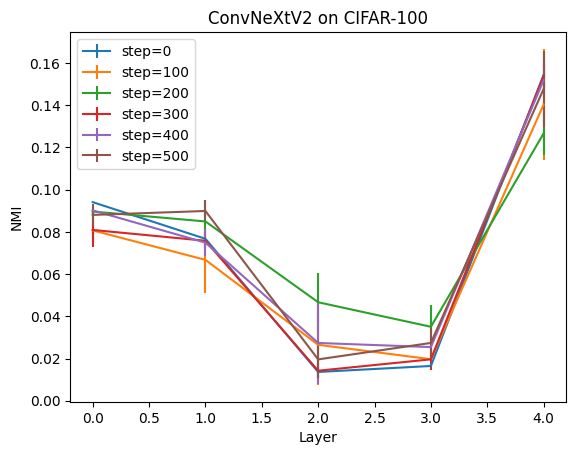

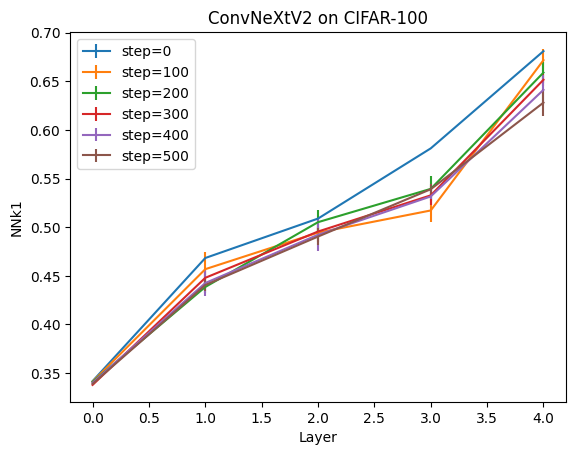

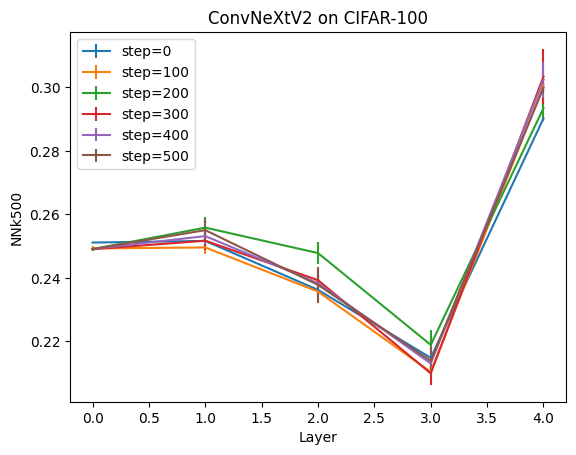

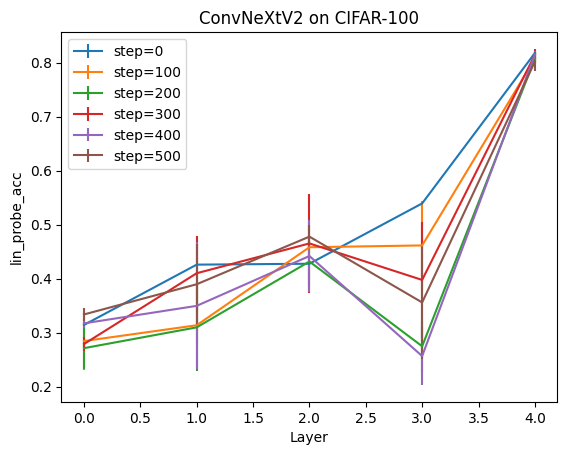

In [ ]:
run_trials(newConvNeXtV2, cifar, 3)

Save results

In [ ]:
# to save training accuracies:
# 1. put screenshot in downloaded file
# 2. add list of accuracies to following pickle file
accs_fname = MODEL.get_dir() + f'training_accs.pkl'
accs = [ACCSTEP0, ACCSTEP100, ...]
with open(accs_fname,'wb') as f:
  pickle.dump(accs,f)

In [ ]:
!zip -q -r alldata.zip data/

In [ ]:
files.download('alldata.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>